# Import Librairies

In [ ]:
# import libraries
import keras_tuner as kt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from datetime import datetime
from datetime import timedelta

from keras.callbacks import EarlyStopping
from keras.layers import Conv1D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import MaxPooling1D
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.utils import np_utils

from matplotlib.pyplot import figure

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.metrics import RootMeanSquaredError

# Load the Data

In [ ]:
#load data
data = pd.read_csv('weather.csv', sep="\s*[,]\s*", skipinitialspace=True, engine='python',
                   names=["Date_Time", "Temp_In_1", "Temp_Out", "Temp_CPU", "Count", "Temp_In_2", "Air_Pressure", "Humidity"])


# Exploratory Data Analysis - Data Cleaning
1. Check shape of the data
2. Verify columns types
3. Check for Null values
4. Check and remove extra white spaces
5. Check and remove for duplicates
6. Convert string Date_Time to a datetime type variable and sort data by datetime
7. Calculate and check time difference between two consecutive observations (Time difference should be around 1 min)
8. Add missing observations with NULL values for the six variables and count=1 and remove duplicate datetime
9. Recalculating and checking time difference with the new data
10. Impute Missing values
11. Denoising the time series

## 1. Data Cleaning: Check shape of the data

In [ ]:
# Check shape of the data
print("Shape of data", data.shape)

Shape of data (545437, 8)


## 2. Data Cleaning: Check columns types

In [ ]:
# Verifying column types
print("Data column types:")
print(data.dtypes, "\n")

Data column types:
Date_Time        object
Temp_In_1       float64
Temp_Out        float64
Temp_CPU        float64
Count             int64
Temp_In_2       float64
Air_Pressure    float64
Humidity        float64
dtype: object 



## 3. Data Cleaning: Check for Null values

In [ ]:
# Checking for NULL values for csv
print("Checking NULL values for data:")
print(data.isnull().sum(), "\n")

Checking NULL values for data:
Date_Time       0
Temp_In_1       0
Temp_Out        0
Temp_CPU        0
Count           0
Temp_In_2       0
Air_Pressure    0
Humidity        0
dtype: int64 



## 4. Data Cleaning: Check and remove extra white spaces

In [ ]:
# checking extra white space in Date_Time
for i in range(len(data)):
    if data['Date_Time'][i].rfind('\x00') != -1:
        print("i =",i)

i = 427898


In [ ]:
# checking Date_Time at i=427898
data['Date_Time'][427898]

'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Sat 10 Sep 2022 08:05:32 PM BST'

In [ ]:
# removing the extra white space found in Date_Time for observation at index 427898
data.at[427898, 'Date_Time'] = data.at[427898, 'Date_Time'].replace('\x00','')

## 5. Data Cleaning: Check and remove duplicates

In [ ]:
# check for duplicates
print("Number of duplicates in data:", data.duplicated().sum())

Number of duplicates in data: 1


In [ ]:
# Removing duplicates
data_unique = data.drop_duplicates(ignore_index=True)

## 6. Data Cleaning: Convert string Date_Time to a datetime type variable and sort data by datetime

In [ ]:
# function create a new variable DateTime to convert string to datetime type
def convert_Date_Time(dataset):
    List = ['None'] * len(dataset)
    for i in range(len(dataset)):
        string = dataset.at[i,'Date_Time']
        if string[28:31] == "GMT":
            string_format = "%a %d %b %Y %I:%M:%S %p %Z"
            converted_time = datetime.strptime(string, string_format)
            List[i] = converted_time
        elif string[28:31] == "BST":
            string_format = "%a %d %b %Y %I:%M:%S %p"
            converted_time_bst = datetime.strptime(string[0:27], string_format)
            converted_time_utc = converted_time_bst + timedelta(hours=-1)
            List[i] = converted_time_utc
    dataset.insert(1, 'DateTime', List)
    return dataset

In [ ]:
# convert string Date_Time to datetime type
data_amended = data_unique.copy()
data_amended = convert_Date_Time(data_amended)

In [ ]:
# sort data by DateTime
data_amended = data_amended.sort_values(by=['DateTime'], ignore_index=True)

## 7. Data Cleaning: Calculate and check time difference between two consecutive observations (Time difference should be around 1 min)

In [ ]:
# function to calculate time interval between two consecutive observations
def calculate_time_interval(dataset):
    interval_list = ['None'] * len(dataset)
    for i in range(len(dataset)-1):
        interval = dataset.at[i+1,'DateTime']-dataset.at[i,'DateTime']
        interval_list[i] = interval
    dataset.insert(2, 'Time_Interval', interval_list)
    return dataset

In [ ]:
# calculate interval times
data_amended = calculate_time_interval(data_amended)

In [ ]:
# function to check time difference between two consecutive observation
def check_time_difference(dataset):
    index = []
    for i in range(len(dataset)-1):
        difference = dataset.at[i,'Time_Interval'].total_seconds()
        if difference > 0 and difference <120:
            continue
        else:
            index.append(i)
    print("Concerned index with a difference of 0 seconds or more than 120 seconds:")
    print(index)
    return index

In [ ]:
# return index where time difference is 0 or greater than 120 seconds
indexes = check_time_difference(data_amended)

Concerned index with a difference of 0 seconds or more than 120 seconds:
[427897, 427922, 427933, 427936, 427937, 427939, 427940]


## 8. Data Cleaning: Add missing observations with NULL values for the six variables and count=1 and remove duplicate datetime

In [ ]:
# list of data to be verified
diff1 = data_amended.iloc[427897:427899,]
diff2 = data_amended.iloc[427922:427924,]
diff3 = data_amended.iloc[427932:427936,]
diff4 = data_amended.iloc[427936:427942,]

Date_Time to be added:
1. Sat 10 Sep 2022 07:58:02 PM BST
2. Sat 10 Sep 2022 07:59:02 PM BST
3. Sat 10 Sep 2022 08:00:02 PM BST
4. Sat 10 Sep 2022 08:01:02 PM BST
5. Sat 10 Sep 2022 08:02:02 PM BST
6. Sat 10 Sep 2022 08:03:02 PM BST
7. Sat 10 Sep 2022 08:04:02 PM BST
8. Sat 10 Sep 2022 08:30:02 PM BST
9. Sat 10 Sep 2022 08:44:03 PM BST
10. Sat 10 Sep 2022 08:46:46 PM BST
11. Sat 10 Sep 2022 08:47:46 PM BST

Date_Time to be removed
1. One of Sat 10 Sep 2022 08:41:03 PM BST - index 427934
2. Two of Sat 10 Sep 2022 08:45:46 PM BST and Sat 10 Sep 2022 08:45:49 PM BST - indexes 427939(Count=3), 427938
3. One of Sat 10 Sep 2022 08:48:13 PM BST - index 427941

In [ ]:
# remove same Date_Time observations
data_preprocess = data_amended.copy()
data_preprocess = data_preprocess.drop([427934,427938,427939,427941],axis=0)

In [ ]:
# new observations to be added
names=["Date_Time", "DateTime", "Time_Interval", "Temp_In_1", "Temp_Out", "Temp_CPU", "Count", "Temp_In_2", "Air_Pressure", "Humidity"]
Obs1 = pd.DataFrame([['Sat 10 Sep 2022 07:58:02 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)
Obs2 = pd.DataFrame([['Sat 10 Sep 2022 07:59:02 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)
Obs3 = pd.DataFrame([['Sat 10 Sep 2022 08:00:02 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)
Obs4 = pd.DataFrame([['Sat 10 Sep 2022 08:01:02 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)
Obs5 = pd.DataFrame([['Sat 10 Sep 2022 08:02:02 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)
Obs6 = pd.DataFrame([['Sat 10 Sep 2022 08:03:02 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)
Obs7 = pd.DataFrame([['Sat 10 Sep 2022 08:04:02 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)
Obs8 = pd.DataFrame([['Sat 10 Sep 2022 08:30:02 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)
Obs9 = pd.DataFrame([['Sat 10 Sep 2022 08:44:03 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)
Obs10 = pd.DataFrame([['Sat 10 Sep 2022 08:46:46 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)
Obs11 = pd.DataFrame([['Sat 10 Sep 2022 08:47:46 PM BST', np.nan, np.nan, np.nan, np.nan, np.nan, 1, np.nan, np.nan, np.nan]], columns=names)

In [ ]:
# add new observations to data
data_preprocess = pd.concat([data_preprocess, Obs1, Obs2, Obs3, Obs4, Obs5, Obs6, Obs7, Obs8, Obs9, Obs10, Obs11], ignore_index=True)

## 9. Data Cleaning: Recalculating and checking time difference with the new data

In [ ]:
# recalculate DateTime, sort by DateTime and calculate Time_Interval
data_preprocess = data_preprocess.drop(['DateTime', 'Time_Interval'], axis=1)
data_preprocess = convert_Date_Time(data_preprocess)
data_preprocess = data_preprocess.sort_values(by=['DateTime'], ignore_index=True)
data_preprocess = calculate_time_interval(data_preprocess)
index_difference = check_time_difference(data_preprocess)

Concerned index with a difference of 0 seconds or more than 120 seconds:
[]


## 10. Data Cleaning: Imputation of missing values

In [ ]:
# Splitting Data into train and test set before imputation
# creating a function to split the data into train (17 Nov 2021 to 30 Sep 2022) and test (1 Oct 2022 to 1 Dec 2022)
def split_train_test(dataset):
    for i in range(len(dataset)):
        if dataset['Date_Time'][i].rfind('Sat 01 Oct 2022') == -1:
            continue
        else:
            first_index = i
            break
    train_data = dataset.iloc[:first_index]
    test_data = dataset.iloc[first_index:,]
    return train_data, test_data

In [ ]:
# Splitting Data into train and test set before imputation
train, test = split_train_test(data_preprocess)

In [ ]:
# finding indexes of missing values in train data
train[train['Temp_In_1'].isnull()].index.tolist()

[427898,
 427899,
 427900,
 427901,
 427902,
 427903,
 427904,
 427930,
 427944,
 427946,
 427947]

In [ ]:
# finding indexes of missing values in test data
test[test['Temp_In_1'].isnull()].index.tolist()

[]

### 10a. Finding out best imputation method between SimpleImputer (mean), LOCF, NOCB, Linear Interpolation, Spline Interpolation, KNNImputer

In [ ]:
# select a random subset of 1 day (1140) records to evaluate imputation methods
random.seed(100)
value = random.randint(0, len(train)-1140)
subset_O = train.iloc[value:value+1140,].copy()
subset_M = subset_O.copy()

# selecting random indexes to be missing
indexes=[]
for i in range(11):
    index = random.randint(value, value+1140)
    indexes.append(index)

# data with random missing values:
features = ['Temp_In_1', 'Temp_Out', 'Temp_CPU', 'Temp_In_2', 'Air_Pressure', 'Humidity']
for i in indexes:
    for feature in features:
        subset_M.at[i, feature] = np.nan

In [ ]:
# impute subset_M with the six different methods

# impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(subset_M[["Temp_In_1", "Temp_Out", "Temp_CPU", "Temp_In_2", "Air_Pressure", "Humidity"]])
mean = imputer.transform(subset_M[["Temp_In_1", "Temp_Out", "Temp_CPU", "Temp_In_2", "Air_Pressure", "Humidity"]])

mean_imputation = subset_M.copy()
mean_imputation['Temp_In_1'] = mean[:,0]
mean_imputation['Temp_Out'] = mean[:,1]
mean_imputation['Temp_CPU'] = mean[:,2]
mean_imputation['Temp_In_2'] = mean[:,3]
mean_imputation['Air_Pressure'] = mean[:,4]
mean_imputation['Humidity'] = mean[:,5]

# impute missing values using "Last Observartion Carried Forward"
LOCF_imputation = subset_M.fillna(method='ffill')

# impute missing values using "Next Observartion Carried Backward"
NOCB_imputation = subset_M.fillna(method='bfill')

# imputing missing values with Spline Interpolation
spline_imputation = subset_M.copy()
features = ["Temp_In_1", "Temp_Out", "Temp_CPU", "Temp_In_2", "Air_Pressure", "Humidity"]
for feature in features:
    spline_imputation[feature] = spline_imputation[feature].interpolate(option='spline')

# imputing missing values with Linear Interpolation
linear_imputation = subset_M.copy()
features = ["Temp_In_1", "Temp_Out", "Temp_CPU", "Temp_In_2", "Air_Pressure", "Humidity"]
for feature in features:
    linear_imputation[feature] = linear_imputation[feature].interpolate(method='linear')

# imputing missing values with KNN Imputer
knn_imputer = KNNImputer(n_neighbors=150, weights="distance")
knn = knn_imputer.fit_transform(subset_M[['Temp_In_1', 'Temp_Out', 'Temp_CPU', 'Temp_In_2', 'Air_Pressure', 'Humidity']])

knn_imputation = subset_M.copy()
knn_imputation['Temp_In_1'] = knn[:,0]
knn_imputation['Temp_Out'] = knn[:,1]
knn_imputation['Temp_CPU'] = knn[:,2]
knn_imputation['Temp_In_2'] = knn[:,3]
knn_imputation['Air_Pressure'] = knn[:,4]
knn_imputation['Humidity'] = knn[:,5]

In [ ]:
# calculating RMSE for each method - lower RMSE implies better model
methods = ["Mean", "LOCF", "NOCB", "Spline", "Linear", "KNN"]
imputations_RMSE = pd.DataFrame(columns=["Method", "Temp_In_1", "Temp_Out", "Temp_CPU", "Temp_In_2", "Air_Pressure", "Humidity"], index=range(6))
imputations_RMSE['Method'] = methods

# function to calculate RMSE for each feature
def calculate_RMSE(impute_dataset, index):
    features = ["Temp_In_1", "Temp_Out", "Temp_CPU", "Temp_In_2", "Air_Pressure", "Humidity"]
    for feature in features:
        y_actual = []
        y_pred = []
        for i in indexes:
            y_actual.append(subset_O.at[i,feature])
            y_pred.append(impute_dataset.at[i,feature])
        MSE = mean_squared_error(y_actual, y_pred)
        RMSE_cal = math.sqrt(MSE)
        imputations_RMSE.at[index,feature] = RMSE_cal

# calculating RMSE for each method
calculate_RMSE(mean_imputation,0)
calculate_RMSE(LOCF_imputation,1)
calculate_RMSE(NOCB_imputation,2)
calculate_RMSE(spline_imputation,3)
calculate_RMSE(linear_imputation,4)
calculate_RMSE(knn_imputation,5)

# view imputations_RMSE
imputations_RMSE #spline or linear had lowest RMSE for each feature

,Method,Temp_In_1,Temp_Out,Temp_CPU,Temp_In_2,Air_Pressure,Humidity
0,Mean,0.449958,0.359232,0.628496,0.501049,4.959395,0.992702
1,LOCF,0.0,0.030151,0.517215,0.024495,0.020671,0.126023
2,NOCB,0.0,0.060302,0.576786,0.019306,0.026458,0.182234
3,Spline,0.0,0.03371,0.395962,0.014848,0.015954,0.033303
4,Linear,0.0,0.03371,0.395962,0.014848,0.015954,0.033303
5,KNN,0.449958,0.359232,0.628496,0.501049,4.959395,0.992702


### 10b. Impute using Linear Interpolation

In [ ]:
# imputing missing values with linear interpolation
train_imputed_linear = train.copy()
features = ["Date_Time", "Temp_In_1", "Temp_Out", "Temp_CPU", "Count", "Temp_In_2", "Air_Pressure", "Humidity"]
for feature in features:
    train_imputed_linear[feature] = train_imputed_linear[feature].interpolate(method='linear')

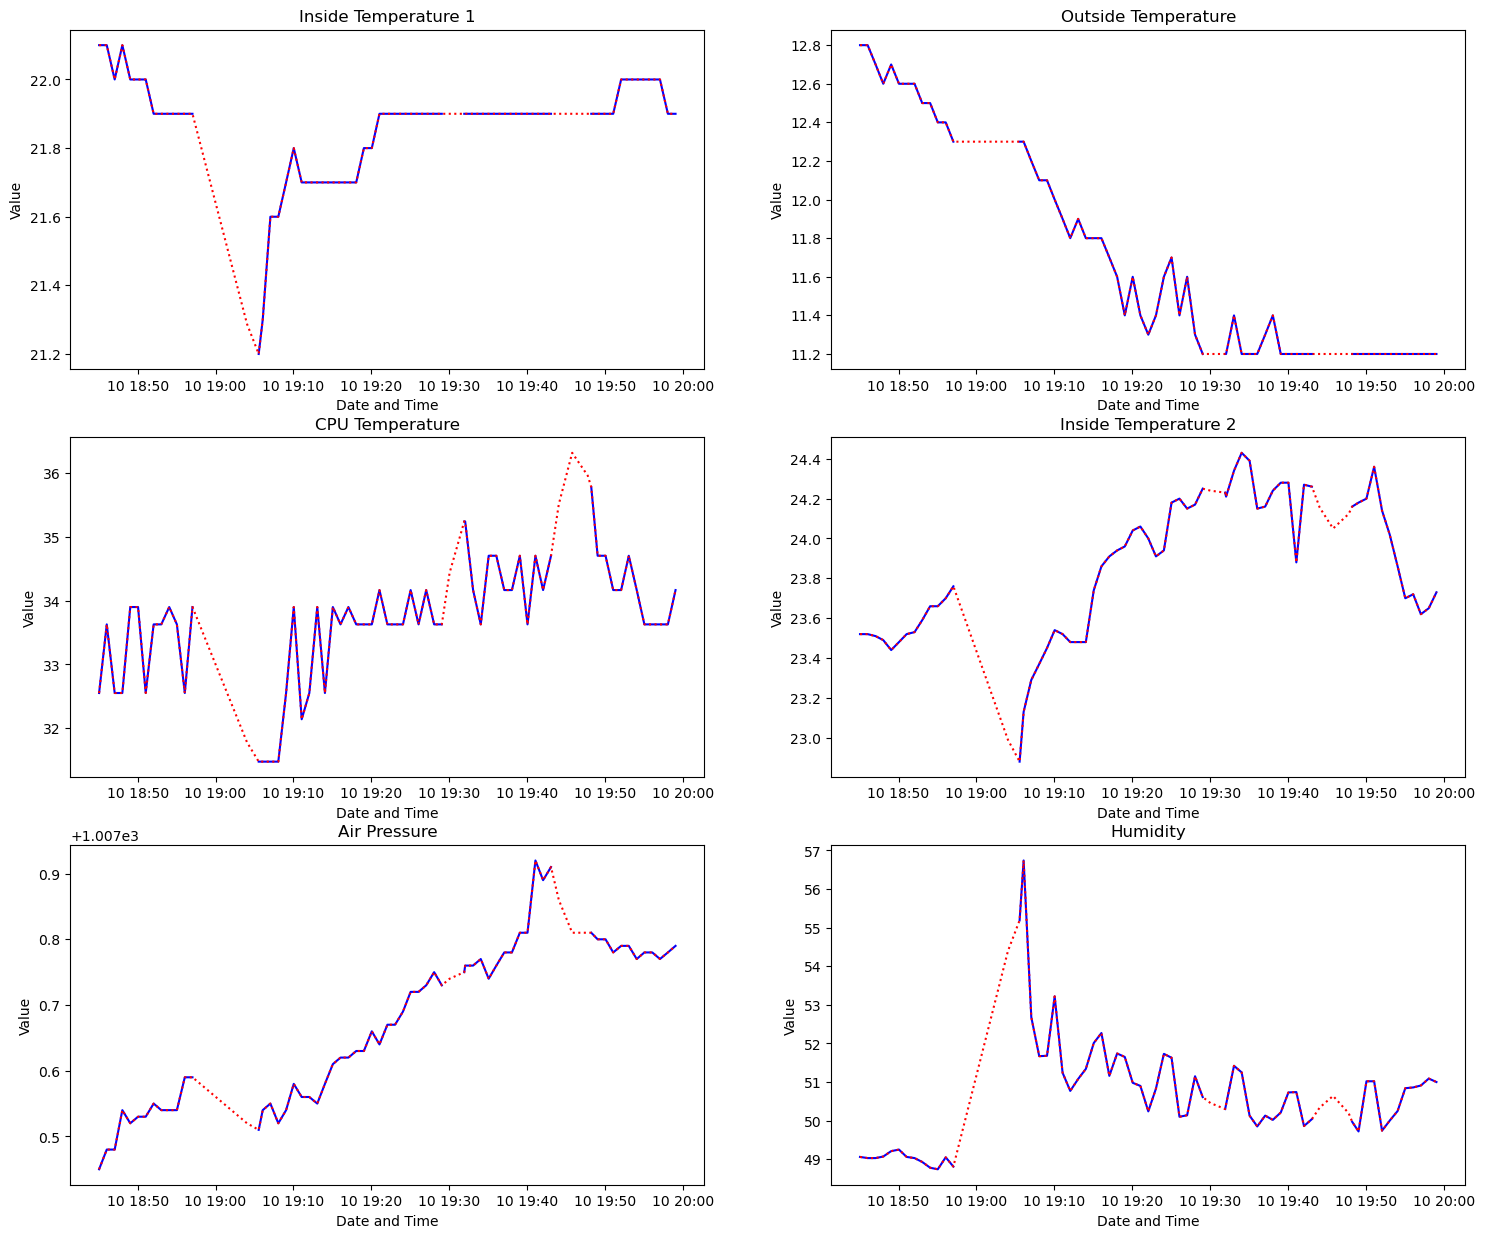

In [ ]:
# visualise imputation values
# set figure size
plt.rcParams["figure.figsize"] = (18,15)

# plot showing original vs linear imputed data
fig, ((ax1, ax2), (ax3, ax4) , (ax5, ax6)) = plt.subplots(3, 2)

ax1.plot(train.iloc[427885:427960,1], train.iloc[427885:427960,3], color='blue', linestyle='-')
ax1.plot(train_imputed_linear.iloc[427885:427960,1], train_imputed_linear.iloc[427885:427960,3], color='red', linestyle='dotted')
ax1.set_title('Inside Temperature 1')
ax1.set_xlabel('Date and Time')
ax1.set_ylabel('Value')

ax2.plot(train.iloc[427885:427960,1], train.iloc[427885:427960,4], color='blue', linestyle='-')
ax2.plot(train_imputed_linear.iloc[427885:427960,1], train_imputed_linear.iloc[427885:427960,4], color='red', linestyle='dotted')
ax2.set_title('Outside Temperature')
ax2.set_xlabel('Date and Time')
ax2.set_ylabel('Value')

ax3.plot(train.iloc[427885:427960,1], train.iloc[427885:427960,5], color='blue', linestyle='-')
ax3.plot(train_imputed_linear.iloc[427885:427960,1], train_imputed_linear.iloc[427885:427960,5], color='red', linestyle='dotted')
ax3.set_title('CPU Temperature')
ax3.set_xlabel('Date and Time')
ax3.set_ylabel('Value')

ax4.plot(train.iloc[427885:427960,1], train.iloc[427885:427960,7], color='blue', linestyle='-')
ax4.plot(train_imputed_linear.iloc[427885:427960,1], train_imputed_linear.iloc[427885:427960,7], color='red', linestyle='dotted')
ax4.set_title('Inside Temperature 2')
ax4.set_xlabel('Date and Time')
ax4.set_ylabel('Value')

ax5.plot(train.iloc[427885:427960,1], train.iloc[427885:427960,8], color='blue', linestyle='-')
ax5.plot(train_imputed_linear.iloc[427885:427960,1], train_imputed_linear.iloc[427885:427960,8], color='red', linestyle='dotted')
ax5.set_title('Air Pressure')
ax5.set_xlabel('Date and Time')
ax5.set_ylabel('Value')

ax6.plot(train.iloc[427885:427960,1], train.iloc[427885:427960,9], color='blue', linestyle='-')
ax6.plot(train_imputed_linear.iloc[427885:427960,1], train_imputed_linear.iloc[427885:427960,9], color='red', linestyle='dotted')
ax6.set_title('Humidity')
ax6.set_xlabel('Date and Time')
ax6.set_ylabel('Value')

plt.savefig('imputation.png')

In [ ]:
# remerge train_imputed and test together
data_imputed_linear = pd.concat([train_imputed_linear, test])

### 11.Data Cleaning: Denoising the time series

In [ ]:
# Denoising using rolling mean with 10 observations
denoised_TempIn1 = data_imputed_linear['Temp_In_1'].rolling(10).mean()
denoised_TempOut = data_imputed_linear['Temp_Out'].rolling(10).mean()
denoised_TempCPU = data_imputed_linear['Temp_CPU'].rolling(10).mean()
denoised_TempIn2 = data_imputed_linear['Temp_In_2'].rolling(10).mean()
denoised_AP = data_imputed_linear['Air_Pressure'].rolling(10).mean()
denoised_Humidity = data_imputed_linear['Humidity'].rolling(10).mean()

In [ ]:
# Storing all denoised features in a single data frame
data_denoised = data_imputed_linear.copy()
data_denoised['Temp_In_1'] = denoised_TempIn1
data_denoised['Temp_Out'] = denoised_TempOut
data_denoised['Temp_CPU'] = denoised_TempCPU
data_denoised['Temp_In_2'] = denoised_TempIn2
data_denoised['Air_Pressure'] = denoised_AP
data_denoised['Humidity'] = denoised_Humidity

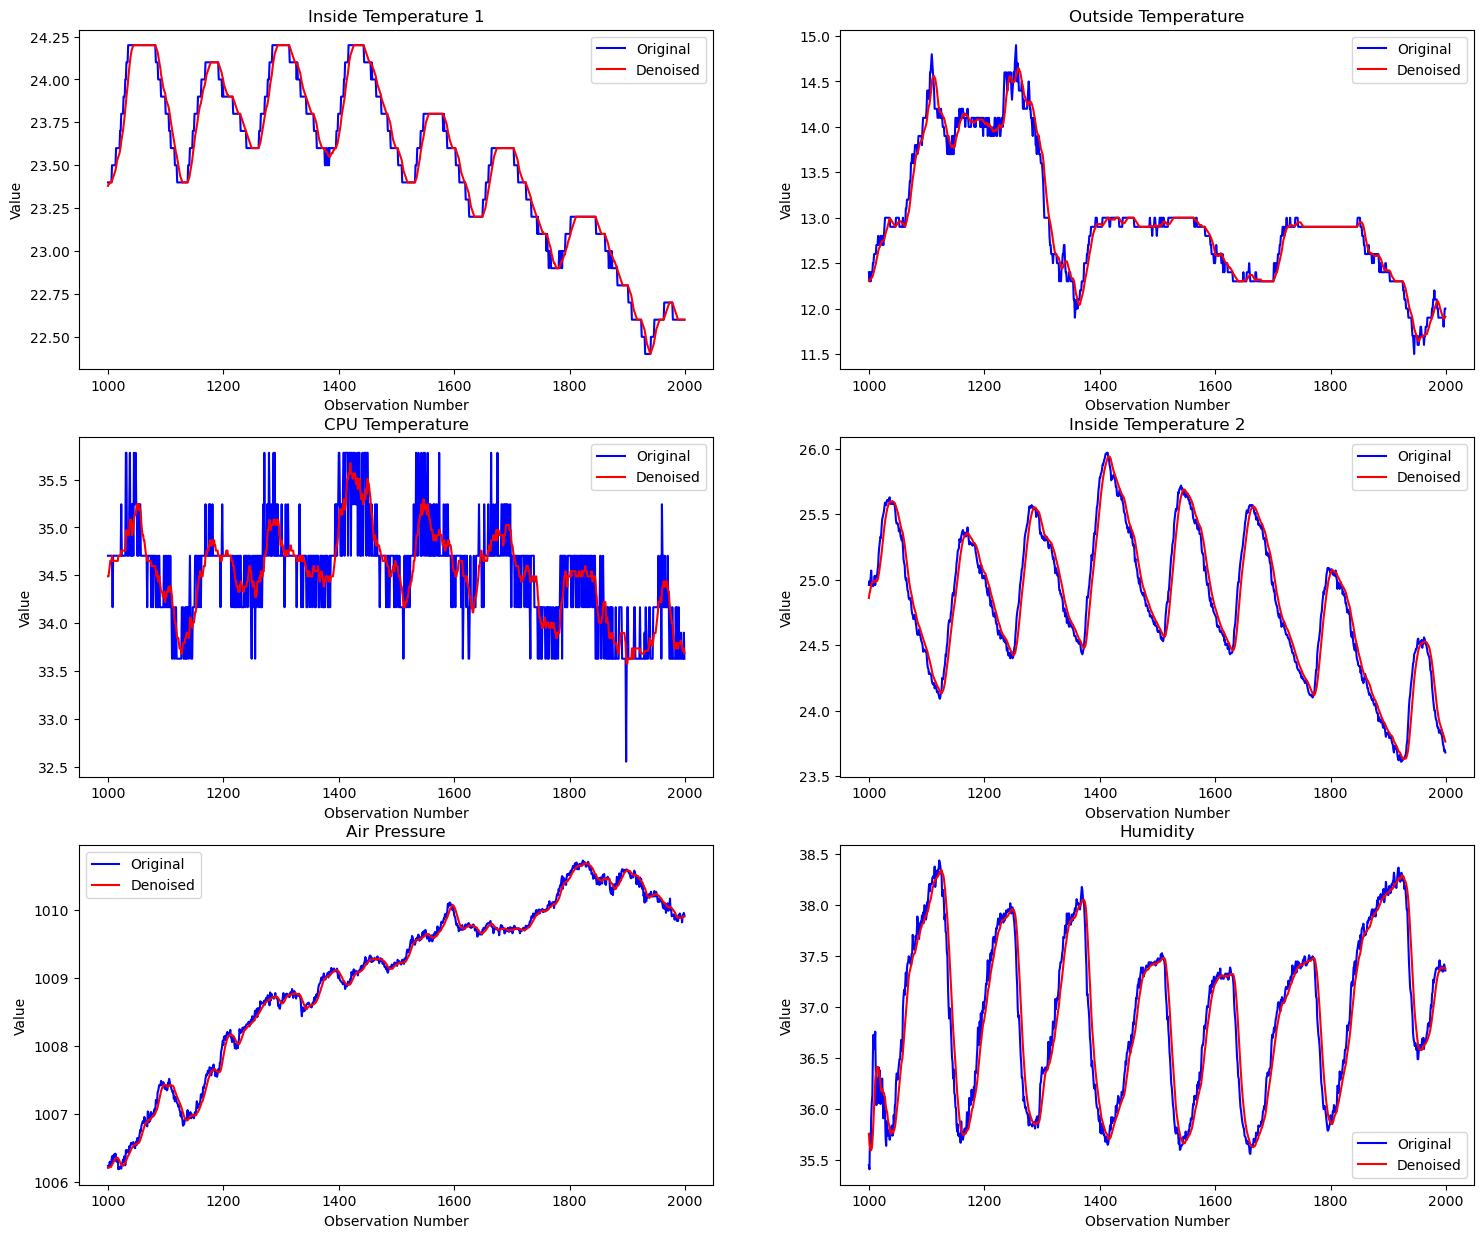

In [ ]:
# visualize denoising
# set figure size
plt.rcParams["figure.figsize"] = (18,15)

# plot showing original vs linear imputed data
fig, ((ax1, ax2), (ax3, ax4) , (ax5, ax6)) = plt.subplots(3, 2)

ax1.plot(data_imputed_linear.iloc[1000:2000,3], color='blue', label="Original")
ax1.plot(data_denoised.iloc[1000:2000,3], color='red', label="Denoised")
ax1.set_title('Inside Temperature 1')
ax1.set_xlabel('Observation Number')
ax1.set_ylabel('Value')
ax1.legend()

ax2.plot(data_imputed_linear.iloc[1000:2000,4], color='blue', label="Original")
ax2.plot(data_denoised.iloc[1000:2000,4], color='red', label="Denoised")
ax2.set_title('Outside Temperature')
ax2.set_xlabel('Observation Number')
ax2.set_ylabel('Value')
ax2.legend()

ax3.plot(data_imputed_linear.iloc[1000:2000,5], color='blue', label="Original")
ax3.plot(data_denoised.iloc[1000:2000,5], color='red', label="Denoised")
ax3.set_title('CPU Temperature')
ax3.set_xlabel('Observation Number')
ax3.set_ylabel('Value')
ax3.legend()

ax4.plot(data_imputed_linear.iloc[1000:2000,7], color='blue', label="Original")
ax4.plot(data_denoised.iloc[1000:2000,7], color='red', label="Denoised")
ax4.set_title('Inside Temperature 2')
ax4.set_xlabel('Observation Number')
ax4.set_ylabel('Value')
ax4.legend()

ax5.plot(data_imputed_linear.iloc[1000:2000,8], color='blue', label="Original")
ax5.plot(data_denoised.iloc[1000:2000,8], color='red', label="Denoised")
ax5.set_title('Air Pressure')
ax5.set_xlabel('Observation Number')
ax5.set_ylabel('Value')
ax5.legend()

ax6.plot(data_imputed_linear.iloc[1000:2000,9], color='blue', label="Original")
ax6.plot(data_denoised.iloc[1000:2000,9], color='red', label="Denoised")
ax6.set_title('Humidity')
ax6.set_xlabel('Observation Number')
ax6.set_ylabel('Value')
ax6.legend()

plt.savefig('denoising.png')

# Exploratory Data Analysis - Data Pre-processing for Time Series Modelling:
1. Data Selection based on time prediction interval
2. Standardisation of Train and Test Data (StandardScaler)
3. Standardisation of Train and Test Data (MinMaxScaler)
4. Normalisation of Train and Test Data
5. Split train and test data into inputs and outputs

## 1. Data Pre-processing: selecting data based on time prediction interval

In [ ]:
# creating a function to select the data required depending on the prediction interval
def select_data(dataset, interval):
    index = list(range(0,len(dataset),interval))
    filtered_data = dataset.filter(items=index, axis=0)
    filtered_data = filtered_data.reset_index(drop=True)
    return filtered_data

## 2. Data Pre-processing: standardising train and test data using StandardScaler(), i.e., Mean=0, variance=1

In [ ]:
# creating a function to standardise the train data and test data and return scaled data as a panda DataFrame
def standardscaler_train_test(train_dataset, test_dataset):
    # initialising the scaler
    scaler = StandardScaler()

    # fit the scaler based on train_dataset
    scaler = scaler.fit(train_dataset[["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"]])

    # transform the train and test data
    scaled_train_data = scaler.transform(train_dataset[["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"]])
    scaled_test_data = scaler.transform(test_dataset[["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"]])

    # convert scaled data to pandas Dataframe
    pd_scaled_train_data = pd.DataFrame(scaled_train_data, columns=["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"])
    pd_scaled_test_data = pd.DataFrame(scaled_test_data, columns=["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"])

    # add Date_Time, DateTime, Time_Interval
    pd_scaled_train_data.insert(0, "Date_Time", train_dataset['Date_Time'].tolist(), True)
    pd_scaled_train_data.insert(1, "DateTime", train_dataset['DateTime'].tolist(), True)
    pd_scaled_train_data.insert(2, "Time_Interval", train_dataset['Time_Interval'].tolist(), True)

    pd_scaled_test_data.insert(0, "Date_Time", test_dataset['Date_Time'].tolist(), True)
    pd_scaled_test_data.insert(1, "DateTime", test_dataset['DateTime'].tolist(), True)
    pd_scaled_test_data.insert(2, "Time_Interval", test_dataset['Time_Interval'].tolist(), True)

    return pd_scaled_train_data, pd_scaled_test_data, scaler

## 3. Data Pre-processing: standardising train and test data using MinMaxScaler(), i.e., output range=[0,1] or [-1,1]

In [ ]:
def minmaxscaler_train_test(train_dataset, test_dataset):
    # initialising the scaler
    scaler = MinMaxScaler()

    # fit the scaler based on train_dataset
    scaler = scaler.fit(train_dataset[["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"]])

    # transform the train and test data
    scaled_train_data = scaler.transform(train_dataset[["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"]])
    scaled_test_data = scaler.transform(test_dataset[["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"]])

    # convert scaled data to pandas Dataframe
    pd_scaled_train_data = pd.DataFrame(scaled_train_data, columns=["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"])
    pd_scaled_test_data = pd.DataFrame(scaled_test_data, columns=["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"])

    # add Date_Time, DateTime, Time_Interval
    pd_scaled_train_data.insert(0, "Date_Time", train_dataset['Date_Time'].tolist(), True)
    pd_scaled_train_data.insert(1, "DateTime", train_dataset['DateTime'].tolist(), True)
    pd_scaled_train_data.insert(2, "Time_Interval", train_dataset['Time_Interval'].tolist(), True)

    pd_scaled_test_data.insert(0, "Date_Time", test_dataset['Date_Time'].tolist(), True)
    pd_scaled_test_data.insert(1, "DateTime", test_dataset['DateTime'].tolist(), True)
    pd_scaled_test_data.insert(2, "Time_Interval", test_dataset['Time_Interval'].tolist(), True)

    return pd_scaled_train_data, pd_scaled_test_data, scaler

## 4. Data Preprocessing: Normalisation of Train and Test Data

In [ ]:
# creating a function to normalise training and test data and return normalised data as a panda DataFrame
def normalise_data(train, test):
    norm_train = normalize(train[["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"]])
    norm_test = normalize(test[["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"]])
    pandas_norm_train = pd.DataFrame(norm_train, columns=["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"])
    pandas_norm_test = pd.DataFrame(norm_test, columns=["Temp_In_1", "Temp_Out", "Temp_CPU","Count", "Temp_In_2", "Air_Pressure", "Humidity"])
    return pandas_norm_train, pandas_norm_test

## 11. Split data into inputs X and ouputs Y

In [ ]:
# creating a function to split the data into inputs and outputs (1 input -> next output)
def split_input_output(dataset):
    inputs = ['None'] * (len(dataset)-1)
    outputs = ['None'] * (len(dataset)-1)
    for i in range(len(dataset)):
        observation = ['None'] * 6
        observation[0] = dataset.at[i,'Temp_In_1']
        observation[1] = dataset.at[i,'Temp_Out']
        observation[2] = dataset.at[i,'Temp_CPU']
        observation[3] = dataset.at[i,'Temp_In_2']
        observation[4] = dataset.at[i,'Air_Pressure']
        observation[5] = dataset.at[i,'Humidity']
        if i == 0:
            inputs[i] = observation
        elif i == (len(dataset)-1):
            outputs[i-1] = observation
        else:
            inputs[i] = observation
            outputs[i-1] = observation
    return inputs, outputs

In [ ]:
# creating a function to split the data into inputs and outputs (num_x inputs -> num_y outputs)
def split_inputs_outputs(dataset, num_x, num_y):
    x = ['None'] * (len(dataset)-num_x)
    y = ['None'] * (len(dataset)-num_x)
    matrix = [0] * len(dataset)

    # merge all features in a single array for each observation
    for i in range(len(dataset)):
        observation = ['None'] * 6
        observation[0] = dataset.at[i,'Temp_In_1']
        observation[1] = dataset.at[i,'Temp_Out']
        observation[2] = dataset.at[i,'Temp_CPU']
        observation[3] = dataset.at[i,'Temp_In_2']
        observation[4] = dataset.at[i,'Air_Pressure']
        observation[5] = dataset.at[i,'Humidity']
        matrix[i] = observation

    # put num_x inputs together in a single observation and num_y outputs together in a single observation
    for j in range(len(dataset)):
        if j+num_x+num_y > len(dataset):
            break
        else:
            x[j]=matrix[j:j+num_x]
            y[j]=matrix[j+num_x:j+num_x+num_y]
    return np.array(x), np.array(y)


# Modelling: Classic Machine Learning Model

## 1. Model 1: Support Vector Regression

In [ ]:
# creating a function to split the feacture into inputs and outputs (num_x inputs -> num_y outputs)
def SVR_split_inputs_outputs(dataset, num_x, num_y):
    x = ['None'] * (len(dataset)-num_x)
    y = ['None'] * (len(dataset)-num_x)
    matrix = [0] * (len(dataset))

    # merge all features in a single array for each observation
    for i in range(len(dataset)):
        matrix[i] = dataset[i]

    # put num_x inputs together in a single observation and num_y outputs together in a single observation
    for j in range(len(dataset)):
        if j+num_x+num_y> len(dataset):
            break
        else:
            x[j]=matrix[j:j+num_x]
            y[j]=matrix[j+num_x:j+num_x+num_y]
    return x, y

In [ ]:
# creating a function for SVR hyperparameter tuning
def SVR_hyperparameter(train_data_X, train_data_Y):
    # define parameter grid
    kernel = ['rbf', 'poly']
    C = [1,10,100,1000,10000]
    gamma = ['scale', 'auto']

    # Create the param grid
    param_grid = {'kernel': kernel,
                  'C':C,
                  'gamma':gamma}

    # fitting the GridSearch
    SVR_GridSearch = GridSearchCV(estimator=SVR(), param_grid=param_grid, cv=3, verbose=2, n_jobs=4)
    SVR_GridSearch.fit(train_data_X, np.ravel(train_data_Y))

    # get the best parameters
    best_params = SVR_GridSearch.best_params_

    return(best_params)

In [ ]:
# creating a function for fit SVR Model, generate prediction and metrics on Test and train data
def SVR_Model_Feature(train_X, train_Y, test_X, test_Y, kernel, gamma, C):
    # fit model to data
    SupportVectorRegression = SVR(kernel=kernel, gamma=gamma, C=C)
    SVR_fit = SupportVectorRegression.fit(train_X, np.ravel(train_Y))

    # generate predictions on test data
    predictions_test = SVR_fit.predict(test_X)

    # calculating R^2, MSE and MAE
    r2 = r2_score(test_Y, predictions_test)
    print("The r2 on test data is:", r2)

    mse = mean_squared_error(test_Y, predictions_test)
    print("The MSE on test data is:",mse)

    mae = mean_absolute_error(test_Y, predictions_test)
    print("The MAE on test data is:",mae)


    # generate predictions on train data
    predictions_train = SVR_fit.predict(train_X)

    # calculating R^2, MSE and MAE
    r2 = r2_score(train_Y, predictions_train)
    print("The r2 on train data is:", r2)

    mse = mean_squared_error(train_Y, predictions_train)
    print("The MSE on train data is:",mse)

    mae = mean_absolute_error(train_Y, predictions_train)
    print("The MAE on train data is:",mae)


    return predictions_test, predictions_train


### Model 1.1
Model: Support Vector Regression  
Time Interval: 5 minute  
Train: 2 day data, Test: 1 day data  
Pre-processing: Standardisation and Denoising

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_denoised,5) # filtering data to be equal to 5 minute interval

# select a one-day data for train, and the next day data for test
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test
train_5min_2day = train_5min[len(train_5min)-576:len(train_5min)]
test_5min_1day = test_5min[0:288]

# standardise data
std_train_5min, std_test_5min, standardscaler = standardscaler_train_test(train_5min_2day, test_5min_1day)

In [ ]:
# split data into inputs and outputs for each feature variable
train_X_TempIn1, train_Y_TempIn1 = SVR_split_inputs_outputs(std_train_5min['Temp_In_1'], 2, 1)
test_X_TempIn1, test_Y_TempIn1 = SVR_split_inputs_outputs(std_test_5min['Temp_In_1'], 2, 1)

train_X_TempOut, train_Y_TempOut = SVR_split_inputs_outputs(std_train_5min['Temp_Out'], 2, 1)
test_X_TempOut, test_Y_TempOut = SVR_split_inputs_outputs(std_test_5min['Temp_Out'], 2, 1)

train_X_TempCPU, train_Y_TempCPU = SVR_split_inputs_outputs(std_train_5min['Temp_CPU'], 2, 1)
test_X_TempCPU, test_Y_TempCPU = SVR_split_inputs_outputs(std_test_5min['Temp_CPU'], 2, 1)

train_X_TempIn2, train_Y_TempIn2 = SVR_split_inputs_outputs(std_train_5min['Temp_In_2'], 2, 1)
test_X_TempIn2, test_Y_TempIn2 = SVR_split_inputs_outputs(std_test_5min['Temp_In_2'], 2, 1)

train_X_AP, train_Y_AP = SVR_split_inputs_outputs(std_train_5min['Air_Pressure'], 2, 1)
test_X_AP, test_Y_AP = SVR_split_inputs_outputs(std_test_5min['Air_Pressure'], 2, 1)

train_X_Humidity, train_Y_Humidity = SVR_split_inputs_outputs(std_train_5min['Humidity'], 2, 1)
test_X_Humidity, test_Y_Humidity = SVR_split_inputs_outputs(std_test_5min['Humidity'], 2, 1)

In [ ]:
# Finding optimal parameters for each feacture
Opt_TempIn1 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn1)
print("Optimal parameters for Temp_In_1:")
print(Opt_TempIn1)

Opt_TempOut = SVR_hyperparameter(train_X_TempOut, train_Y_TempOut)
print("Optimal parameters for Temp_Out:")
print(Opt_TempOut)

Opt_TempCPU = SVR_hyperparameter(train_X_TempCPU, train_Y_TempCPU)
print("Optimal parameters for Temp_CPU:")
print(Opt_TempCPU)

Opt_TempIn2 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn2)
print("Optimal parameters for Temp_In_2:")
print(Opt_TempIn2)

Opt_AP = SVR_hyperparameter(train_X_AP, train_Y_AP)
print("Optimal parameters for Air_Pressure")
print(Opt_AP)

Opt_Humidity = SVR_hyperparameter(train_X_Humidity, train_Y_Humidity)
print("Optimal parameters for Humidity:")
print(Opt_Humidity)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_1:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_Out:
{'C': 10000, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_CPU:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_2:
{'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Air_Pressure
{'C': 100, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Humidity:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# fitting SVR and generating predictions and metrics for each feature#

# SVR for Temp_In_1
print("Feature = Temp_In_1")
TempIn1_Preds_test, TempIn1_Preds_train = SVR_Model_Feature(train_X_TempIn1, train_Y_TempIn1, test_X_TempIn1, test_Y_TempIn1, kernel='rbf', gamma='auto', C=10)

# SVR for Temp_Out
print("Feature = Temp_Out")
TempOut_Preds_test, TempOut_Preds_train = SVR_Model_Feature(train_X_TempOut, train_Y_TempOut, test_X_TempOut, test_Y_TempOut, kernel='rbf', gamma='auto', C=10000)

# SVR for Temp_CPU
print("Feature = Temp_CPU")
TempCPU_Preds_test, TempCPU_Preds_train = SVR_Model_Feature(train_X_TempCPU, train_Y_TempCPU, test_X_TempCPU, test_Y_TempCPU, kernel='rbf', gamma='auto', C=100)

# SVR for Temp_In_2
print("Feature = Temp_In_2")
TempIn2_Preds_test, TempIn2_Preds_train = SVR_Model_Feature(train_X_TempIn2, train_Y_TempIn2, test_X_TempIn2, test_Y_TempIn2, kernel='poly', gamma='auto', C=1)

# SVR for Air_Pressure
print("Feature = Air_Pressure")
AP_Preds_test, AP_Preds_train = SVR_Model_Feature(train_X_AP, train_Y_AP, test_X_AP, test_Y_AP, kernel='poly', gamma='auto', C=100)

# SVR for Humidity
print("Feature = Humidity")
Humidity_Preds_test, Humidity_Preds_train = SVR_Model_Feature(train_X_Humidity, train_Y_Humidity, test_X_Humidity, test_Y_Humidity, kernel='rbf', gamma='auto', C=100)

Feature = Temp_In_1
The r2 on test data is: 0.8160169867397834
The MSE on test data is: 0.25708614531621377
The MAE on test data is: 0.2236149753430938
The r2 on train data is: 0.9982176236760812
The MSE on train data is: 0.0017870109861397197
The MAE on train data is: 0.033249408848331774
Feature = Temp_Out
The r2 on test data is: 0.9293665741445013
The MSE on test data is: 0.1127682095525561
The MAE on test data is: 0.15277067679361314
The r2 on train data is: 0.9964197715727086
The MSE on train data is: 0.0035926312380309628
The MAE on train data is: 0.03997423762103528
Feature = Temp_CPU
The r2 on test data is: 0.879759035357223
The MSE on test data is: 0.1934453266532496
The MAE on test data is: 0.22195647618811523
The r2 on train data is: 0.9812427729083686
The MSE on train data is: 0.01879642607958186
The MAE on train data is: 0.10949956455460409
Feature = Temp_In_2
The r2 on test data is: -0.06107007913245832
The MSE on test data is: 1.597376863981164
The MAE on test data is: 0

### Model 1.2  
Model: Support Vector Regression  
Time Interval: 5 minute  
Train: 2 day data, Test: 1 day data  
Pre-processing: Min-Max Scaler and Denoising

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_denoised,5) # filtering data to be equal to 5 minute interval

# select a one-day data for train, and the next day data for test
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test
train_5min_2day = train_5min[len(train_5min)-576:len(train_5min)]
test_5min_1day = test_5min[0:288]

# standardise data
std_train_5min, std_test_5min, standardscaler = minmaxscaler_train_test(train_5min_2day, test_5min_1day)

In [ ]:
# split data into inputs and outputs for each feature variable
train_X_TempIn1, train_Y_TempIn1 = SVR_split_inputs_outputs(std_train_5min['Temp_In_1'], 2, 1)
test_X_TempIn1, test_Y_TempIn1 = SVR_split_inputs_outputs(std_test_5min['Temp_In_1'], 2, 1)

train_X_TempOut, train_Y_TempOut = SVR_split_inputs_outputs(std_train_5min['Temp_Out'], 2, 1)
test_X_TempOut, test_Y_TempOut = SVR_split_inputs_outputs(std_test_5min['Temp_Out'], 2, 1)

train_X_TempCPU, train_Y_TempCPU = SVR_split_inputs_outputs(std_train_5min['Temp_CPU'], 2, 1)
test_X_TempCPU, test_Y_TempCPU = SVR_split_inputs_outputs(std_test_5min['Temp_CPU'], 2, 1)

train_X_TempIn2, train_Y_TempIn2 = SVR_split_inputs_outputs(std_train_5min['Temp_In_2'], 2, 1)
test_X_TempIn2, test_Y_TempIn2 = SVR_split_inputs_outputs(std_test_5min['Temp_In_2'], 2, 1)

train_X_AP, train_Y_AP = SVR_split_inputs_outputs(std_train_5min['Air_Pressure'], 2, 1)
test_X_AP, test_Y_AP = SVR_split_inputs_outputs(std_test_5min['Air_Pressure'], 2, 1)

train_X_Humidity, train_Y_Humidity = SVR_split_inputs_outputs(std_train_5min['Humidity'], 2, 1)
test_X_Humidity, test_Y_Humidity = SVR_split_inputs_outputs(std_test_5min['Humidity'], 2, 1)

In [ ]:
# Finding optimal parameters for each feacture
Opt_TempIn1 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn1)
print("Optimal parameters for Temp_In_1:")
print(Opt_TempIn1)

Opt_TempOut = SVR_hyperparameter(train_X_TempOut, train_Y_TempOut)
print("Optimal parameters for Temp_Out:")
print(Opt_TempOut)

Opt_TempCPU = SVR_hyperparameter(train_X_TempCPU, train_Y_TempCPU)
print("Optimal parameters for Temp_CPU:")
print(Opt_TempCPU)

Opt_TempIn2 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn2)
print("Optimal parameters for Temp_In_2:")
print(Opt_TempIn2)

Opt_AP = SVR_hyperparameter(train_X_AP, train_Y_AP)
print("Optimal parameters for Air_Pressure")
print(Opt_AP)

Opt_Humidity = SVR_hyperparameter(train_X_Humidity, train_Y_Humidity)
print("Optimal parameters for Humidity:")
print(Opt_Humidity)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_1:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_Out:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_CPU:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_2:
{'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Air_Pressure
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Humidity:
{'C': 10000, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# fitting SVR and generating predictions and metrics for each feature

# SVR for Temp_In_1
print("Feature = Temp_In_1")
TempIn1_Preds_test, TempIn1_Preds_train = SVR_Model_Feature(train_X_TempIn1, train_Y_TempIn1, test_X_TempIn1, test_Y_TempIn1, kernel='rbf', gamma='auto', C=1)

# SVR for Temp_Out
print("Feature = Temp_Out")
TempOut_Preds_test, TempOut_Preds_train = SVR_Model_Feature(train_X_TempOut, train_Y_TempOut, test_X_TempOut, test_Y_TempOut, kernel='rbf', gamma='auto', C=100)

# SVR for Temp_CPU
print("Feature = Temp_CPU")
TempCPU_Preds_test, TempCPU_Preds_train = SVR_Model_Feature(train_X_TempCPU, train_Y_TempCPU, test_X_TempCPU, test_Y_TempCPU, kernel='rbf', gamma='auto', C=100)

# SVR for Temp_In_2
print("Feature = Temp_In_2")
TempIn2_Preds_test, TempIn2_Preds_train = SVR_Model_Feature(train_X_TempIn2, train_Y_TempIn2, test_X_TempIn2, test_Y_TempIn2, kernel='poly', gamma='auto', C=1)

# SVR for Air_Pressure
print("Feature = Air_Pressure")
AP_Preds_test, AP_Preds_train = SVR_Model_Feature(train_X_AP, train_Y_AP, test_X_AP, test_Y_AP, kernel='rbf', gamma='auto', C=1)

# SVR for Humidity
print("Feature = Humidity")
Humidity_Preds_test, Humidity_Preds_train = SVR_Model_Feature(train_X_Humidity, train_Y_Humidity, test_X_Humidity, test_Y_Humidity, kernel='rbf', gamma='auto', C=10000)

Feature = Temp_In_1
The r2 on test data is: 0.7580082694058614
The MSE on test data is: 0.3381438324898839
The MAE on test data is: 0.267181842059277
The r2 on train data is: 0.9968013846375946
The MSE on train data is: 0.003206932630526855
The MAE on train data is: 0.04427513703823626
Feature = Temp_Out
The r2 on test data is: 0.9761341114977702
The MSE on test data is: 0.03810254823662749
The MAE on test data is: 0.10155796770278093
The r2 on train data is: 0.9962833951721074
The MSE on train data is: 0.0037294800807459528
The MAE on train data is: 0.03836992862969698
Feature = Temp_CPU
The r2 on test data is: 0.879759035357223
The MSE on test data is: 0.1934453266532496
The MAE on test data is: 0.22195647618811523
The r2 on train data is: 0.9812427729083686
The MSE on train data is: 0.01879642607958186
The MAE on train data is: 0.10949956455460409
Feature = Temp_In_2
The r2 on test data is: -0.06107007913245832
The MSE on test data is: 1.597376863981164
The MAE on test data is: 0.81

### Model 1.3  
Model: Support Vector Regression   
Time Interval: 5 minute  
Train: 2 day data, Test: 1 day data  
Pre-processing: Normalisation and Denoising

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_denoised,5) # filtering data to be equal to 5 minute interval

# select a one-day data for train, and the next day data for test
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test
train_5min_2day = train_5min[len(train_5min)-576:len(train_5min)]
test_5min_1day = test_5min[0:288]

# normalise data
norm_train_5min, norm_test_5min = normalise_data(train_5min_2day, te)st_5min_1day

In [ ]:
# split data into inputs and outputs for each feature variable
train_X_TempIn1, train_Y_TempIn1 = SVR_split_inputs_outputs(norm_train_5min['Temp_In_1'], 2, 1)
test_X_TempIn1, test_Y_TempIn1 = SVR_split_inputs_outputs(norm_test_5min['Temp_In_1'], 2, 1)

train_X_TempOut, train_Y_TempOut = SVR_split_inputs_outputs(norm_train_5min['Temp_Out'], 2, 1)
test_X_TempOut, test_Y_TempOut = SVR_split_inputs_outputs(norm_test_5min['Temp_Out'], 2, 1)

train_X_TempCPU, train_Y_TempCPU = SVR_split_inputs_outputs(norm_train_5min['Temp_CPU'], 2, 1)
test_X_TempCPU, test_Y_TempCPU = SVR_split_inputs_outputs(norm_test_5min['Temp_CPU'], 2, 1)

train_X_TempIn2, train_Y_TempIn2 = SVR_split_inputs_outputs(norm_train_5min['Temp_In_2'], 2, 1)
test_X_TempIn2, test_Y_TempIn2 = SVR_split_inputs_outputs(norm_test_5min['Temp_In_2'], 2, 1)

train_X_AP, train_Y_AP = SVR_split_inputs_outputs(norm_train_5min['Air_Pressure'], 2, 1)
test_X_AP, test_Y_AP = SVR_split_inputs_outputs(norm_test_5min['Air_Pressure'], 2, 1)

train_X_Humidity, train_Y_Humidity = SVR_split_inputs_outputs(norm_train_5min['Humidity'], 2, 1)
test_X_Humidity, test_Y_Humidity = SVR_split_inputs_outputs(norm_test_5min['Humidity'], 2, 1)

In [ ]:
# Finding optimal parameters for each feacture
Opt_TempIn1 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn1)
print("Optimal parameters for Temp_In_1:")
print(Opt_TempIn1)

Opt_TempOut = SVR_hyperparameter(train_X_TempOut, train_Y_TempOut)
print("Optimal parameters for Temp_Out:")
print(Opt_TempOut)

Opt_TempCPU = SVR_hyperparameter(train_X_TempCPU, train_Y_TempCPU)
print("Optimal parameters for Temp_CPU:")
print(Opt_TempCPU)

Opt_TempIn2 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn2)
print("Optimal parameters for Temp_In_2:")
print(Opt_TempIn2)

Opt_AP = SVR_hyperparameter(train_X_AP, train_Y_AP)
print("Optimal parameters for Air_Pressure")
print(Opt_AP)

Opt_Humidity = SVR_hyperparameter(train_X_Humidity, train_Y_Humidity)
print("Optimal parameters for Humidity:")
print(Opt_Humidity)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_1:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_Out:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_CPU:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_2:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Air_Pressure
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Humidity:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# fitting SVR and generating predictions and metrics for each feature#

# SVR for Temp_In_1
print("Feature = Temp_In_1")
TempIn1_Preds_test, TempIn1_Preds_train = SVR_Model_Feature(train_X_TempIn1, train_Y_TempIn1, test_X_TempIn1, test_Y_TempIn1, kernel='rbf', gamma='scale', C=1)

# SVR for Temp_Out
print("Feature = Temp_Out")
TempOut_Preds_test, TempOut_Preds_train = SVR_Model_Feature(train_X_TempOut, train_Y_TempOut, test_X_TempOut, test_Y_TempOut, kernel='rbf', gamma='scale', C=1)

# SVR for Temp_CPU
print("Feature = Temp_CPU")
TempCPU_Preds_test, TempCPU_Preds_train = SVR_Model_Feature(train_X_TempCPU, train_Y_TempCPU, test_X_TempCPU, test_Y_TempCPU, kernel='rbf', gamma='scale', C=1)

# SVR for Temp_In_2
print("Feature = Temp_In_2")
TempIn2_Preds_test, TempIn2_Preds_train = SVR_Model_Feature(train_X_TempIn2, train_Y_TempIn2, test_X_TempIn2, test_Y_TempIn2, kernel='rbf', gamma='scale', C=1)

# SVR for Air_Pressure
print("Feature = Air_Pressure")
AP_Preds_test, AP_Preds_train = SVR_Model_Feature(train_X_AP, train_Y_AP, test_X_AP, test_Y_AP, kernel='rbf', gamma='scale', C=1)

# SVR for Humidity
print("Feature = Humidity")
Humidity_Preds_test, Humidity_Preds_train = SVR_Model_Feature(train_X_Humidity, train_Y_Humidity, test_X_Humidity, test_Y_Humidity, kernel='rbf', gamma='scale', C=1)

Feature = Temp_In_1
The r2 on test data is: -0.17753170204865953
The MSE on test data is: 1.8732582051393107e-06
The MAE on test data is: 0.0010639329537934928
The r2 on train data is: -0.009135933722787426
The MSE on train data is: 1.1957354376491622e-06
The MAE on train data is: 0.0009459960849880537
Feature = Temp_Out
The r2 on test data is: -0.08492476835766838
The MSE on test data is: 1.1853165179575047e-05
The MAE on test data is: 0.0031225438716408083
The r2 on train data is: -0.47025604816767785
The MSE on train data is: 9.91088956343143e-06
The MAE on train data is: 0.0028138033055162674
Feature = Temp_CPU
The r2 on test data is: -0.5934398731080703
The MSE on test data is: 1.2287855282098103e-06
The MAE on test data is: 0.0009561171456822174
The r2 on train data is: -0.07703550540078297
The MSE on train data is: 5.344363034716081e-07
The MAE on train data is: 0.000615326893614193
Feature = Temp_In_2
The r2 on test data is: -0.4870405896642691
The MSE on test data is: 1.497203

## Model 2: Support Vector Regression
Model: Support Vector Regression  
Time Interval: 10 minute  
Train: 4 day data, Test: 2 day data  
Pre-processing: Min-Max Scaler and Denoising

In [ ]:
# preparing data for 10 minute interval prediction
data_10min = select_data(data_denoised,10) # filtering data to be equal to 10 minute interval

# select a four-day data for train, and the next two day data for test
train_10min, test_10min = split_train_test(data_10min) # split the filtered data into train and test
train_10min_4day = train_10min[len(train_10min)-576:len(train_10min)]
test_10min_2day = test_10min[0:288]

# standardise data
std_train_10min, std_test_10min, standardscaler = minmaxscaler_train_test(train_10min_4day, test_10min_2day)

In [ ]:
# split data into inputs and outputs for each feature variable
train_X_TempIn1, train_Y_TempIn1 = SVR_split_inputs_outputs(std_train_10min['Temp_In_1'], 2, 1)
test_X_TempIn1, test_Y_TempIn1 = SVR_split_inputs_outputs(std_test_10min['Temp_In_1'], 2, 1)

train_X_TempOut, train_Y_TempOut = SVR_split_inputs_outputs(std_train_10min['Temp_Out'], 2, 1)
test_X_TempOut, test_Y_TempOut = SVR_split_inputs_outputs(std_test_10min['Temp_Out'], 2, 1)

train_X_TempCPU, train_Y_TempCPU = SVR_split_inputs_outputs(std_train_10min['Temp_CPU'], 2, 1)
test_X_TempCPU, test_Y_TempCPU = SVR_split_inputs_outputs(std_test_10min['Temp_CPU'], 2, 1)

train_X_TempIn2, train_Y_TempIn2 = SVR_split_inputs_outputs(std_train_10min['Temp_In_2'], 2, 1)
test_X_TempIn2, test_Y_TempIn2 = SVR_split_inputs_outputs(std_test_10min['Temp_In_2'], 2, 1)

train_X_AP, train_Y_AP = SVR_split_inputs_outputs(std_train_10min['Air_Pressure'], 2, 1)
test_X_AP, test_Y_AP = SVR_split_inputs_outputs(std_test_10min['Air_Pressure'], 2, 1)

train_X_Humidity, train_Y_Humidity = SVR_split_inputs_outputs(std_train_10min['Humidity'], 2, 1)
test_X_Humidity, test_Y_Humidity = SVR_split_inputs_outputs(std_test_10min['Humidity'], 2, 1)

In [ ]:
# Finding optimal parameters for each feacture
Opt_TempIn1 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn1)
print("Optimal parameters for Temp_In_1:")
print(Opt_TempIn1)

Opt_TempOut = SVR_hyperparameter(train_X_TempOut, train_Y_TempOut)
print("Optimal parameters for Temp_Out:")
print(Opt_TempOut)

Opt_TempCPU = SVR_hyperparameter(train_X_TempCPU, train_Y_TempCPU)
print("Optimal parameters for Temp_CPU:")
print(Opt_TempCPU)

Opt_TempIn2 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn2)
print("Optimal parameters for Temp_In_2:")
print(Opt_TempIn2)

Opt_AP = SVR_hyperparameter(train_X_AP, train_Y_AP)
print("Optimal parameters for Air_Pressure")
print(Opt_AP)

Opt_Humidity = SVR_hyperparameter(train_X_Humidity, train_Y_Humidity)
print("Optimal parameters for Humidity:")
print(Opt_Humidity)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_1:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_Out:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_CPU:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_2:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Air_Pressure
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Humidity:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# fitting SVR and generating predictions and metrics for each feature#

# SVR for Temp_In_1
print("Feature = Temp_In_1")
TempIn1_Preds_test, TempIn1_Preds_train = SVR_Model_Feature(train_X_TempIn1, train_Y_TempIn1, test_X_TempIn1, test_Y_TempIn1, kernel='rbf', gamma='auto', C=1)

# SVR for Temp_Out
print("Feature = Temp_Out")
TempOut_Preds_test, TempOut_Preds_train = SVR_Model_Feature(train_X_TempOut, train_Y_TempOut, test_X_TempOut, test_Y_TempOut, kernel='rbf', gamma='auto', C=1)

# SVR for Temp_CPU
print("Feature = Temp_CPU")
TempCPU_Preds_test, TempCPU_Preds_train = SVR_Model_Feature(train_X_TempCPU, train_Y_TempCPU, test_X_TempCPU, test_Y_TempCPU, kernel='rbf', gamma='auto', C=1)

# SVR for Temp_In_2
print("Feature = Temp_In_2")
TempIn2_Preds_test, TempIn2_Preds_train = SVR_Model_Feature(train_X_TempIn2, train_Y_TempIn2, test_X_TempIn2, test_Y_TempIn2, kernel='rbf', gamma='scale', C=100)

# SVR for Air_Pressure
print("Feature = Air_Pressure")
AP_Preds_test, AP_Preds_train = SVR_Model_Feature(train_X_AP, train_Y_AP, test_X_AP, test_Y_AP, kernel='rbf', gamma='scale', C=1)

# SVR for Humidity
print("Feature = Humidity")
Humidity_Preds_test, Humidity_Preds_train = SVR_Model_Feature(train_X_Humidity, train_Y_Humidity, test_X_Humidity, test_Y_Humidity, kernel='rbf', gamma='auto', C=10)

Feature = Temp_In_1
The r2 on test data is: 0.9782178206842014
The MSE on test data is: 0.0011586801301114893
The MAE on test data is: 0.027731137943220723
The r2 on train data is: 0.9716790905472547
The MSE on train data is: 0.0014429874186931983
The MAE on train data is: 0.03127410272492603
Feature = Temp_Out
The r2 on test data is: 0.9402511937463836
The MSE on test data is: 0.002291494159601291
The MAE on test data is: 0.03796459057137052
The r2 on train data is: 0.9395674673252877
The MSE on train data is: 0.0022681638690524243
The MAE on train data is: 0.03889114737492663
Feature = Temp_CPU
The r2 on test data is: 0.9778028130099241
The MSE on test data is: 0.000695093876304757
The MAE on test data is: 0.020529309115402832
The r2 on train data is: 0.9676789252082075
The MSE on train data is: 0.0011825862016708157
The MAE on train data is: 0.026053498444493214
Feature = Temp_In_2
The r2 on test data is: 0.9594381786999188
The MSE on test data is: 0.001519657581899293
The MAE on te

## Model 3 : Support Vector Regression  
Model: Support Vector Regression  
Time Interval: 15 minute  
Train: 6 day data, Test: 3 day data  
Pre-processing: Min-Max Scaler and Denoising

In [ ]:
# preparing data for 15 minute interval prediction
data_15min = select_data(data_denoised,15) # filtering data to be equal to 15 minute interval

# select 6 days data for train, and the next 3 days data for test
train_15min, test_15min = split_train_test(data_15min) # split the filtered data into train and test
train_15min_6day = train_15min[len(train_15min)-576:len(train_15min)]
test_15min_3day = test_15min[0:288]

# standardise data
std_train_15min, std_test_15min, standardscaler = minmaxscaler_train_test(train_15min_6day, test_15min_3day)

In [ ]:
# split data into inputs and outputs for each feature variable
train_X_TempIn1, train_Y_TempIn1 = SVR_split_inputs_outputs(std_train_15min['Temp_In_1'], 2, 1)
test_X_TempIn1, test_Y_TempIn1 = SVR_split_inputs_outputs(std_test_15min['Temp_In_1'], 2, 1)

train_X_TempOut, train_Y_TempOut = SVR_split_inputs_outputs(std_train_15min['Temp_Out'], 2, 1)
test_X_TempOut, test_Y_TempOut = SVR_split_inputs_outputs(std_test_15min['Temp_Out'], 2, 1)

train_X_TempCPU, train_Y_TempCPU = SVR_split_inputs_outputs(std_train_15min['Temp_CPU'], 2, 1)
test_X_TempCPU, test_Y_TempCPU = SVR_split_inputs_outputs(std_test_15min['Temp_CPU'], 2, 1)

train_X_TempIn2, train_Y_TempIn2 = SVR_split_inputs_outputs(std_train_15min['Temp_In_2'], 2, 1)
test_X_TempIn2, test_Y_TempIn2 = SVR_split_inputs_outputs(std_test_15min['Temp_In_2'], 2, 1)

train_X_AP, train_Y_AP = SVR_split_inputs_outputs(std_train_15min['Air_Pressure'], 2, 1)
test_X_AP, test_Y_AP = SVR_split_inputs_outputs(std_test_15min['Air_Pressure'], 2, 1)

train_X_Humidity, train_Y_Humidity = SVR_split_inputs_outputs(std_train_15min['Humidity'], 2, 1)
test_X_Humidity, test_Y_Humidity = SVR_split_inputs_outputs(std_test_15min['Humidity'], 2, 1)

In [ ]:
# Finding optimal parameters for each feacture
Opt_TempIn1 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn1)
print("Optimal parameters for Temp_In_1:")
print(Opt_TempIn1)

Opt_TempOut = SVR_hyperparameter(train_X_TempOut, train_Y_TempOut)
print("Optimal parameters for Temp_Out:")
print(Opt_TempOut)

Opt_TempCPU = SVR_hyperparameter(train_X_TempCPU, train_Y_TempCPU)
print("Optimal parameters for Temp_CPU:")
print(Opt_TempCPU)

Opt_TempIn2 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn2)
print("Optimal parameters for Temp_In_2:")
print(Opt_TempIn2)

Opt_AP = SVR_hyperparameter(train_X_AP, train_Y_AP)
print("Optimal parameters for Air_Pressure")
print(Opt_AP)

Opt_Humidity = SVR_hyperparameter(train_X_Humidity, train_Y_Humidity)
print("Optimal parameters for Humidity:")
print(Opt_Humidity)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_1:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_Out:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_CPU:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_2:
{'C': 10000, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Air_Pressure
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Humidity:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# fitting SVR and generating predictions and metrics for each feature

# SVR for Temp_In_1
print("Feature = Temp_In_1")
TempIn1_Preds_test, TempIn1_Preds_train = SVR_Model_Feature(train_X_TempIn1, train_Y_TempIn1, test_X_TempIn1, test_Y_TempIn1, kernel='rbf', gamma='auto', C=10)

# SVR for Temp_Out
print("Feature = Temp_Out")
TempOut_Preds_test, TempOut_Preds_train = SVR_Model_Feature(train_X_TempOut, train_Y_TempOut, test_X_TempOut, test_Y_TempOut, kernel='rbf', gamma='auto', C=10)

# SVR for Temp_CPU
print("Feature = Temp_CPU")
TempCPU_Preds_test, TempCPU_Preds_train = SVR_Model_Feature(train_X_TempCPU, train_Y_TempCPU, test_X_TempCPU, test_Y_TempCPU, kernel='rbf', gamma='auto', C=10)

# SVR for Temp_In_2
print("Feature = Temp_In_2")
TempIn2_Preds_test, TempIn2_Preds_train = SVR_Model_Feature(train_X_TempIn2, train_Y_TempIn2, test_X_TempIn2, test_Y_TempIn2, kernel='rbf', gamma='auto', C=10000)

# SVR for Air_Pressure
print("Feature = Air_Pressure")
AP_Preds_test, AP_Preds_train = SVR_Model_Feature(train_X_AP, train_Y_AP, test_X_AP, test_Y_AP, kernel='rbf', gamma='auto', C=1)

# SVR for Humidity
print("Feature = Humidity")
Humidity_Preds_test, Humidity_Preds_train = SVR_Model_Feature(train_X_Humidity, train_Y_Humidity, test_X_Humidity, test_Y_Humidity, kernel='rbf', gamma='scale', C=10)

Feature = Temp_In_1
The r2 on test data is: 0.9702630627281214
The MSE on test data is: 0.0014468060596795152
The MAE on test data is: 0.03204653946831467
The r2 on train data is: 0.9665976260028251
The MSE on train data is: 0.001532273183750425
The MAE on train data is: 0.03314602431806342
Feature = Temp_Out
The r2 on test data is: 0.9027297789833115
The MSE on test data is: 0.0029164271870584352
The MAE on test data is: 0.04357019123925759
The r2 on train data is: 0.9034242692727168
The MSE on train data is: 0.003082360123700239
The MAE on train data is: 0.04600406532511793
Feature = Temp_CPU
The r2 on test data is: 0.968090406431111
The MSE on test data is: 0.0008628466591137718
The MAE on test data is: 0.022820472032744992
The r2 on train data is: 0.9660563757016603
The MSE on train data is: 0.0010855536662739713
The MAE on train data is: 0.02495429073714007
Feature = Temp_In_2
The r2 on test data is: 0.9763835036690497
The MSE on test data is: 0.0007288080132835749
The MAE on test

## Model 4: Support Vector Regression  
Model: Support Vector Regression  
Time Interval: 30 minute  
Train: 12 day data, Test: 6 day data  
Pre-processing: Min-Max Scaler and Denoising

In [ ]:
# preparing data for 30 minute interval prediction
data_30min = select_data(data_denoised,30) # filtering data to be equal to 30 minute interval

# select 12 days data for train, and the next 6 days data for test
train_30min, test_30min = split_train_test(data_30min) # split the filtered data into train and test
train_30min_12day = train_30min[len(train_30min)-576:len(train_30min)]
test_30min_6day = test_30min[0:288]

# standardise data
std_train_30min, std_test_30min, standardscaler = minmaxscaler_train_test(train_30min_12day, test_30min_6day)

In [ ]:
# split data into inputs and outputs for each feature variable
train_X_TempIn1, train_Y_TempIn1 = SVR_split_inputs_outputs(std_train_30min['Temp_In_1'], 2, 1)
test_X_TempIn1, test_Y_TempIn1 = SVR_split_inputs_outputs(std_test_30min['Temp_In_1'], 2, 1)

train_X_TempOut, train_Y_TempOut = SVR_split_inputs_outputs(std_train_30min['Temp_Out'], 2, 1)
test_X_TempOut, test_Y_TempOut = SVR_split_inputs_outputs(std_test_30min['Temp_Out'], 2, 1)

train_X_TempCPU, train_Y_TempCPU = SVR_split_inputs_outputs(std_train_30min['Temp_CPU'], 2, 1)
test_X_TempCPU, test_Y_TempCPU = SVR_split_inputs_outputs(std_test_30min['Temp_CPU'], 2, 1)

train_X_TempIn2, train_Y_TempIn2 = SVR_split_inputs_outputs(std_train_30min['Temp_In_2'], 2, 1)
test_X_TempIn2, test_Y_TempIn2 = SVR_split_inputs_outputs(std_test_30min['Temp_In_2'], 2, 1)

train_X_AP, train_Y_AP = SVR_split_inputs_outputs(std_train_30min['Air_Pressure'], 2, 1)
test_X_AP, test_Y_AP = SVR_split_inputs_outputs(std_test_30min['Air_Pressure'], 2, 1)

train_X_Humidity, train_Y_Humidity = SVR_split_inputs_outputs(std_train_30min['Humidity'], 2, 1)
test_X_Humidity, test_Y_Humidity = SVR_split_inputs_outputs(std_test_30min['Humidity'], 2, 1)

In [ ]:
# Finding optimal parameters for each feacture
Opt_TempIn1 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn1)
print("Optimal parameters for Temp_In_1:")
print(Opt_TempIn1)

Opt_TempOut = SVR_hyperparameter(train_X_TempOut, train_Y_TempOut)
print("Optimal parameters for Temp_Out:")
print(Opt_TempOut)

Opt_TempCPU = SVR_hyperparameter(train_X_TempCPU, train_Y_TempCPU)
print("Optimal parameters for Temp_CPU:")
print(Opt_TempCPU)

Opt_TempIn2 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn2)
print("Optimal parameters for Temp_In_2:")
print(Opt_TempIn2)

Opt_AP = SVR_hyperparameter(train_X_AP, train_Y_AP)
print("Optimal parameters for Air_Pressure")
print(Opt_AP)

Opt_Humidity = SVR_hyperparameter(train_X_Humidity, train_Y_Humidity)
print("Optimal parameters for Humidity:")
print(Opt_Humidity)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_1:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_Out:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_CPU:
{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_2:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Air_Pressure
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Humidity:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# fitting SVR and generating predictions and metrics for each feature#

# SVR for Temp_In_1
print("Feature = Temp_In_1")
TempIn1_Preds_test, TempIn1_Preds_train = SVR_Model_Feature(train_X_TempIn1, train_Y_TempIn1, test_X_TempIn1, test_Y_TempIn1, kernel='rbf', gamma='auto', C=100)

# SVR for Temp_Out
print("Feature = Temp_Out")
TempOut_Preds_test, TempOut_Preds_train = SVR_Model_Feature(train_X_TempOut, train_Y_TempOut, test_X_TempOut, test_Y_TempOut, kernel='rbf', gamma='auto', C=10)

# SVR for Temp_CPU
print("Feature = Temp_CPU")
TempCPU_Preds_test, TempCPU_Preds_train = SVR_Model_Feature(train_X_TempCPU, train_Y_TempCPU, test_X_TempCPU, test_Y_TempCPU, kernel='rbf', gamma='auto', C=1000)

# SVR for Temp_In_2
print("Feature = Temp_In_2")
TempIn2_Preds_test, TempIn2_Preds_train = SVR_Model_Feature(train_X_TempIn2, train_Y_TempIn2, test_X_TempIn2, test_Y_TempIn2, kernel='rbf', gamma='auto', C=1)

# SVR for Air_Pressure
print("Feature = Air_Pressure")
AP_Preds_test, AP_Preds_train = SVR_Model_Feature(train_X_AP, train_Y_AP, test_X_AP, test_Y_AP, kernel='rbf', gamma='auto', C=1)

# SVR for Humidity
print("Feature = Humidity")
Humidity_Preds_test, Humidity_Preds_train = SVR_Model_Feature(train_X_Humidity, train_Y_Humidity, test_X_Humidity, test_Y_Humidity, kernel='rbf', gamma='auto', C=10)

Feature = Temp_In_1
The r2 on test data is: 0.9644121499899866
The MSE on test data is: 0.0017970314615408111
The MAE on test data is: 0.03395006645754159
The r2 on train data is: 0.9602441401767003
The MSE on train data is: 0.0015745882582300702
The MAE on train data is: 0.03169936862994583
Feature = Temp_Out
The r2 on test data is: 0.883356849745716
The MSE on test data is: 0.0018986083110231692
The MAE on test data is: 0.03190418648462549
The r2 on train data is: 0.8860986462319982
The MSE on train data is: 0.0031269067119339767
The MAE on train data is: 0.041719258891514385
Feature = Temp_CPU
The r2 on test data is: 0.9530669096107672
The MSE on test data is: 0.0017046206363199724
The MAE on test data is: 0.030274403867515537
The r2 on train data is: 0.9545103771128253
The MSE on train data is: 0.0013179744622280449
The MAE on train data is: 0.027890286397191055
Feature = Temp_In_2
The r2 on test data is: 0.9588064000229602
The MSE on test data is: 0.0016567622102789796
The MAE on 

## Model 5 :  Support Vector Regression  
Model: Support Vector Regression  
Time Interval: 1 hour  
Train: 24 day data, Test: 12 day data  
Pre-processing: Min-Max Scaler and Denoising

In [ ]:
# preparing data for 1 hour interval prediction
data_1hour = select_data(data_denoised,60) # filtering data to be equal to 1 hour interval

# select 24 days data for train, and the next 12 days data for test
train_1hour, test_1hour = split_train_test(data_1hour) # split the filtered data into train and test
train_1hour_24day = train_1hour[len(train_1hour)-576:len(train_1hour)]
test_1hour_12day = test_1hour[0:288]

# standardise data
std_train_1hour, std_test_1hour, standardscaler = minmaxscaler_train_test(train_1hour_24day, test_1hour_12day)

In [ ]:
# split data into inputs and outputs for each feature variable
train_X_TempIn1, train_Y_TempIn1 = SVR_split_inputs_outputs(std_train_1hour['Temp_In_1'], 2, 1)
test_X_TempIn1, test_Y_TempIn1 = SVR_split_inputs_outputs(std_test_1hour['Temp_In_1'], 2, 1)

train_X_TempOut, train_Y_TempOut = SVR_split_inputs_outputs(std_train_1hour['Temp_Out'], 2, 1)
test_X_TempOut, test_Y_TempOut = SVR_split_inputs_outputs(std_test_1hour['Temp_Out'], 2, 1)

train_X_TempCPU, train_Y_TempCPU = SVR_split_inputs_outputs(std_train_1hour['Temp_CPU'], 2, 1)
test_X_TempCPU, test_Y_TempCPU = SVR_split_inputs_outputs(std_test_1hour['Temp_CPU'], 2, 1)

train_X_TempIn2, train_Y_TempIn2 = SVR_split_inputs_outputs(std_train_1hour['Temp_In_2'], 2, 1)
test_X_TempIn2, test_Y_TempIn2 = SVR_split_inputs_outputs(std_test_1hour['Temp_In_2'], 2, 1)

train_X_AP, train_Y_AP = SVR_split_inputs_outputs(std_train_1hour['Air_Pressure'], 2, 1)
test_X_AP, test_Y_AP = SVR_split_inputs_outputs(std_test_1hour['Air_Pressure'], 2, 1)

train_X_Humidity, train_Y_Humidity = SVR_split_inputs_outputs(std_train_1hour['Humidity'], 2, 1)
test_X_Humidity, test_Y_Humidity = SVR_split_inputs_outputs(std_test_1hour['Humidity'], 2, 1)

In [ ]:
# Finding optimal parameters for each feacture
Opt_TempIn1 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn1)
print("Optimal parameters for Temp_In_1:")
print(Opt_TempIn1)

Opt_TempOut = SVR_hyperparameter(train_X_TempOut, train_Y_TempOut)
print("Optimal parameters for Temp_Out:")
print(Opt_TempOut)

Opt_TempCPU = SVR_hyperparameter(train_X_TempCPU, train_Y_TempCPU)
print("Optimal parameters for Temp_CPU:")
print(Opt_TempCPU)

Opt_TempIn2 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn2)
print("Optimal parameters for Temp_In_2:")
print(Opt_TempIn2)

Opt_AP = SVR_hyperparameter(train_X_AP, train_Y_AP)
print("Optimal parameters for Air_Pressure")
print(Opt_AP)

Opt_Humidity = SVR_hyperparameter(train_X_Humidity, train_Y_Humidity)
print("Optimal parameters for Humidity:")
print(Opt_Humidity)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_1:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_Out:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_CPU:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_2:
{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Air_Pressure
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Humidity:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# fitting SVR and generating predictions and metrics for each feature#

# SVR for Temp_In_1
print("Feature = Temp_In_1")
TempIn1_Preds_test, TempIn1_Preds_train = SVR_Model_Feature(train_X_TempIn1, train_Y_TempIn1, test_X_TempIn1, test_Y_TempIn1, kernel='rbf', gamma='auto', C=100)

# SVR for Temp_Out
print("Feature = Temp_Out")
TempOut_Preds_test, TempOut_Preds_train = SVR_Model_Feature(train_X_TempOut, train_Y_TempOut, test_X_TempOut, test_Y_TempOut, kernel='rbf', gamma='auto', C=100)

# SVR for Temp_CPU
print("Feature = Temp_CPU")
TempCPU_Preds_test, TempCPU_Preds_train = SVR_Model_Feature(train_X_TempCPU, train_Y_TempCPU, test_X_TempCPU, test_Y_TempCPU, kernel='rbf', gamma='auto', C=100)

# SVR for Temp_In_2
print("Feature = Temp_In_2")
TempIn2_Preds_test, TempIn2_Preds_train = SVR_Model_Feature(train_X_TempIn2, train_Y_TempIn2, test_X_TempIn2, test_Y_TempIn2, kernel='rbf', gamma='auto', C=1000)

# SVR for Air_Pressure
print("Feature = Air_Pressure")
AP_Preds_test, AP_Preds_train = SVR_Model_Feature(train_X_AP, train_Y_AP, test_X_AP, test_Y_AP, kernel='rbf', gamma='scale', C=1)

# SVR for Humidity
print("Feature = Humidity")
Humidity_Preds_test, Humidity_Preds_train = SVR_Model_Feature(train_X_Humidity, train_Y_Humidity, test_X_Humidity, test_Y_Humidity, kernel='rbf', gamma='scale', C=10)

Feature = Temp_In_1
The r2 on test data is: 0.8720858241046143
The MSE on test data is: 0.0019493316244080367
The MAE on test data is: 0.034201900252416546
The r2 on train data is: 0.950660915387066
The MSE on train data is: 0.001447073325571726
The MAE on train data is: 0.030264375408019552
Feature = Temp_Out
The r2 on test data is: 0.7134126895418543
The MSE on test data is: 0.005166394665716112
The MAE on test data is: 0.053496107425873726
The r2 on train data is: 0.8108500172697248
The MSE on train data is: 0.00529923154754441
The MAE on train data is: 0.05295536234977334
Feature = Temp_CPU
The r2 on test data is: 0.8789776334332131
The MSE on test data is: 0.001342536668890823
The MAE on test data is: 0.027367401466195176
The r2 on train data is: 0.9622824143250869
The MSE on train data is: 0.0010780448337992907
The MAE on train data is: 0.024683306314494828
Feature = Temp_In_2
The r2 on test data is: 0.8559930503020823
The MSE on test data is: 0.0014621224710643004
The MAE on tes

## Model 6  : Support Vector Regression  
Model: Support Vector Regression  
Time Interval: 2 hour  
Train: 48 day data, Test: 24 day data  
Pre-processing: Min-Max Scaler and Denoising

In [ ]:
# preparing data for 2 hour interval prediction
data_2hour = select_data(data_denoised,120) # filtering data to be equal to 2 hour interval

# select 48 days data for train, and the next 24 day data for test
train_2hour, test_2hour = split_train_test(data_2hour) # split the filtered data into train and test
train_2hour_48day = train_2hour[len(train_2hour)-576:len(train_2hour)]
test_2hour_24day = test_2hour[0:288]

# standardise data
std_train_2hour, std_test_2hour, standardscaler = minmaxscaler_train_test(train_2hour_48day, test_2hour_24day)

In [ ]:
# split data into inputs and outputs for each feature variable
train_X_TempIn1, train_Y_TempIn1 = SVR_split_inputs_outputs(std_train_2hour['Temp_In_1'], 2, 1)
test_X_TempIn1, test_Y_TempIn1 = SVR_split_inputs_outputs(std_test_2hour['Temp_In_1'], 2, 1)

train_X_TempOut, train_Y_TempOut = SVR_split_inputs_outputs(std_train_2hour['Temp_Out'], 2, 1)
test_X_TempOut, test_Y_TempOut = SVR_split_inputs_outputs(std_test_2hour['Temp_Out'], 2, 1)

train_X_TempCPU, train_Y_TempCPU = SVR_split_inputs_outputs(std_train_2hour['Temp_CPU'], 2, 1)
test_X_TempCPU, test_Y_TempCPU = SVR_split_inputs_outputs(std_test_2hour['Temp_CPU'], 2, 1)

train_X_TempIn2, train_Y_TempIn2 = SVR_split_inputs_outputs(std_train_2hour['Temp_In_2'], 2, 1)
test_X_TempIn2, test_Y_TempIn2 = SVR_split_inputs_outputs(std_test_2hour['Temp_In_2'], 2, 1)

train_X_AP, train_Y_AP = SVR_split_inputs_outputs(std_train_2hour['Air_Pressure'], 2, 1)
test_X_AP, test_Y_AP = SVR_split_inputs_outputs(std_test_2hour['Air_Pressure'], 2, 1)

train_X_Humidity, train_Y_Humidity = SVR_split_inputs_outputs(std_train_2hour['Humidity'], 2, 1)
test_X_Humidity, test_Y_Humidity = SVR_split_inputs_outputs(std_test_2hour['Humidity'], 2, 1)

In [ ]:
# Finding optimal parameters for each feacture
Opt_TempIn1 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn1)
print("Optimal parameters for Temp_In_1:")
print(Opt_TempIn1)

Opt_TempOut = SVR_hyperparameter(train_X_TempOut, train_Y_TempOut)
print("Optimal parameters for Temp_Out:")
print(Opt_TempOut)

Opt_TempCPU = SVR_hyperparameter(train_X_TempCPU, train_Y_TempCPU)
print("Optimal parameters for Temp_CPU:")
print(Opt_TempCPU)

Opt_TempIn2 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn2)
print("Optimal parameters for Temp_In_2:")
print(Opt_TempIn2)

Opt_AP = SVR_hyperparameter(train_X_AP, train_Y_AP)
print("Optimal parameters for Air_Pressure")
print(Opt_AP)

Opt_Humidity = SVR_hyperparameter(train_X_Humidity, train_Y_Humidity)
print("Optimal parameters for Humidity:")
print(Opt_Humidity)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_1:
{'C': 10000, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_Out:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_CPU:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_2:
{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Air_Pressure
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Humidity:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# fitting SVR and generating predictions and metrics for each feature

# SVR for Temp_In_1
print("Feature = Temp_In_1")
TempIn1_Preds_test, TempIn1_Preds_train = SVR_Model_Feature(train_X_TempIn1, train_Y_TempIn1, test_X_TempIn1, test_Y_TempIn1, kernel='rbf', gamma='auto', C=10000)

# SVR for Temp_Out
print("Feature = Temp_Out")
TempOut_Preds_test, TempOut_Preds_train = SVR_Model_Feature(train_X_TempOut, train_Y_TempOut, test_X_TempOut, test_Y_TempOut, kernel='rbf', gamma='auto', C=100)

# SVR for Temp_CPU
print("Feature = Temp_CPU")
TempCPU_Preds_test, TempCPU_Preds_train = SVR_Model_Feature(train_X_TempCPU, train_Y_TempCPU, test_X_TempCPU, test_Y_TempCPU, kernel='rbf', gamma='auto', C=1)

# SVR for Temp_In_2
print("Feature = Temp_In_2")
TempIn2_Preds_test, TempIn2_Preds_train = SVR_Model_Feature(train_X_TempIn2, train_Y_TempIn2, test_X_TempIn2, test_Y_TempIn2, kernel='poly', gamma='auto', C=1000)

# SVR for Air_Pressure
print("Feature = Air_Pressure")
AP_Preds_test, AP_Preds_train = SVR_Model_Feature(train_X_AP, train_Y_AP, test_X_AP, test_Y_AP, kernel='rbf', gamma='auto', C=10)

# SVR for Humidity
print("Feature = Humidity")
Humidity_Preds_test, Humidity_Preds_train = SVR_Model_Feature(train_X_Humidity, train_Y_Humidity, test_X_Humidity, test_Y_Humidity, kernel='rbf', gamma='auto', C=1)

Feature = Temp_In_1
The r2 on test data is: 0.721732789231913
The MSE on test data is: 0.003004282098018745
The MAE on test data is: 0.043767116296521844
The r2 on train data is: 0.9512152589178662
The MSE on train data is: 0.0018646045373770716
The MAE on train data is: 0.03384049916653069
Feature = Temp_Out
The r2 on test data is: 0.25023959761264936
The MSE on test data is: 0.007357445623074861
The MAE on test data is: 0.07225434907004923
The r2 on train data is: 0.6080025154362183
The MSE on train data is: 0.00979873320473869
The MAE on train data is: 0.07012531451105704
Feature = Temp_CPU
The r2 on test data is: 0.7334684393405546
The MSE on test data is: 0.002023996427438284
The MAE on test data is: 0.03454544022188172
The r2 on train data is: 0.9414076531311983
The MSE on train data is: 0.0021125996661585716
The MAE on train data is: 0.037422743506758976
Feature = Temp_In_2
The r2 on test data is: -1.2798649973044767
The MSE on test data is: 0.014795160167213528
The MAE on test 

## Model 7 : Support Vector Regression   
Model: Support Vector Regression  
Time Interval: 6 hour  
Train: 144 day data, Test: 72 day data  
Pre-processing: Min-Max Scaler and Denoising

In [ ]:
# preparing data for 6 hour interval prediction
data_6hour = select_data(data_denoised,360) # filtering data to be equal to 6 hour interval

# select a one-day data for train, and the next day data for test
train_6hour, test_6hour = split_train_test(data_6hour) # split the filtered data into train and test
train_6hour_144day = train_6hour[len(train_6hour)-576:len(train_6hour)]
test_6hour_72day = test_6hour[0:288]

# standardise data
std_train_6hour, std_test_6hour, standardscaler = minmaxscaler_train_test(train_6hour_144day, test_6hour_72day)

In [ ]:
# split data into inputs and outputs for each feature variable
train_X_TempIn1, train_Y_TempIn1 = SVR_split_inputs_outputs(std_train_6hour['Temp_In_1'], 2, 1)
test_X_TempIn1, test_Y_TempIn1 = SVR_split_inputs_outputs(std_test_6hour['Temp_In_1'], 2, 1)

train_X_TempOut, train_Y_TempOut = SVR_split_inputs_outputs(std_train_6hour['Temp_Out'], 2, 1)
test_X_TempOut, test_Y_TempOut = SVR_split_inputs_outputs(std_test_6hour['Temp_Out'], 2, 1)

train_X_TempCPU, train_Y_TempCPU = SVR_split_inputs_outputs(std_train_6hour['Temp_CPU'], 2, 1)
test_X_TempCPU, test_Y_TempCPU = SVR_split_inputs_outputs(std_test_6hour['Temp_CPU'], 2, 1)

train_X_TempIn2, train_Y_TempIn2 = SVR_split_inputs_outputs(std_train_6hour['Temp_In_2'], 2, 1)
test_X_TempIn2, test_Y_TempIn2 = SVR_split_inputs_outputs(std_test_6hour['Temp_In_2'], 2, 1)

train_X_AP, train_Y_AP = SVR_split_inputs_outputs(std_train_6hour['Air_Pressure'], 2, 1)
test_X_AP, test_Y_AP = SVR_split_inputs_outputs(std_test_6hour['Air_Pressure'], 2, 1)

train_X_Humidity, train_Y_Humidity = SVR_split_inputs_outputs(std_train_6hour['Humidity'], 2, 1)
test_X_Humidity, test_Y_Humidity = SVR_split_inputs_outputs(std_test_6hour['Humidity'], 2, 1)

In [ ]:
# Finding optimal parameters for each feacture
Opt_TempIn1 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn1)
print("Optimal parameters for Temp_In_1:")
print(Opt_TempIn1)

Opt_TempOut = SVR_hyperparameter(train_X_TempOut, train_Y_TempOut)
print("Optimal parameters for Temp_Out:")
print(Opt_TempOut)

Opt_TempCPU = SVR_hyperparameter(train_X_TempCPU, train_Y_TempCPU)
print("Optimal parameters for Temp_CPU:")
print(Opt_TempCPU)

Opt_TempIn2 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn2)
print("Optimal parameters for Temp_In_2:")
print(Opt_TempIn2)

Opt_AP = SVR_hyperparameter(train_X_AP, train_Y_AP)
print("Optimal parameters for Air_Pressure")
print(Opt_AP)

Opt_Humidity = SVR_hyperparameter(train_X_Humidity, train_Y_Humidity)
print("Optimal parameters for Humidity:")
print(Opt_Humidity)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_1:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_Out:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_CPU:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_2:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Air_Pressure
{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Humidity:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# fitting SVR and generating predictions and metrics for each feature

# SVR for Temp_In_1
print("Feature = Temp_In_1")
TempIn1_Preds_test, TempIn1_Preds_train = SVR_Model_Feature(train_X_TempIn1, train_Y_TempIn1, test_X_TempIn1, test_Y_TempIn1, kernel='rbf', gamma='auto', C=10)

# SVR for Temp_Out
print("Feature = Temp_Out")
TempOut_Preds_test, TempOut_Preds_train = SVR_Model_Feature(train_X_TempOut, train_Y_TempOut, test_X_TempOut, test_Y_TempOut, kernel='rbf', gamma='scale', C=10)

# SVR for Temp_CPU
print("Feature = Temp_CPU")
TempCPU_Preds_test, TempCPU_Preds_train = SVR_Model_Feature(train_X_TempCPU, train_Y_TempCPU, test_X_TempCPU, test_Y_TempCPU, kernel='rbf', gamma='auto', C=10)

# SVR for Temp_In_2
print("Feature = Temp_In_2")
TempIn2_Preds_test, TempIn2_Preds_train = SVR_Model_Feature(train_X_TempIn2, train_Y_TempIn2, test_X_TempIn2, test_Y_TempIn2, kernel='rbf', gamma='auto', C=1)

# SVR for Air_Pressure
print("Feature = Air_Pressure")
AP_Preds_test, AP_Preds_train = SVR_Model_Feature(train_X_AP, train_Y_AP, test_X_AP, test_Y_AP, kernel='rbf', gamma='auto', C=1000)

# SVR for Humidity
print("Feature = Humidity")
Humidity_Preds_test, Humidity_Preds_train = SVR_Model_Feature(train_X_Humidity, train_Y_Humidity, test_X_Humidity, test_Y_Humidity, kernel='rbf', gamma='auto', C=100)

Feature = Temp_In_1
The r2 on test data is: -0.366155049315509
The MSE on test data is: 0.0080745087969568
The MAE on test data is: 0.07121139714423498
The r2 on train data is: 0.6652065622458572
The MSE on train data is: 0.008454286171180346
The MAE on train data is: 0.07459730888615197
Feature = Temp_Out
The r2 on test data is: -3.4638152225948273
The MSE on test data is: 0.048069152549738384
The MAE on test data is: 0.18884081666955213
The r2 on train data is: 0.23667662508204157
The MSE on train data is: 0.024445251992340638
The MAE on train data is: 0.10616521687251147
Feature = Temp_CPU
The r2 on test data is: -0.10190953149254245
The MSE on test data is: 0.004378787803087845
The MAE on test data is: 0.05120846994929581
The r2 on train data is: 0.7221338134057325
The MSE on train data is: 0.006143256860678267
The MAE on train data is: 0.06372251800432087
Feature = Temp_In_2
The r2 on test data is: -0.7231575591497756
The MSE on test data is: 0.006732851989609199
The MAE on test d

## Model 8 : Support Vector Regression  
Model: Support Vector Regression  
Time Interval: 12 hour  
Train: 1152 day data, Test: 576 day data  
Pre-processing: Min-Max Scaler and Denoising

In [ ]:
# preparing data for 12 hour interval prediction
data_12hour = select_data(data_denoised,720) # filtering data to be equal to 12 hour interval

# select 1152 days data for train, and the next 576 days data for test
train_12hour, test_12hour = split_train_test(data_12hour) # split the filtered data into train and test
train_12hour_1152day = train_12hour[len(train_12hour)-576:len(train_12hour)]
test_12hour_576day = test_12hour[0:288]

# standardise data
std_train_12hour, std_test_12hour, standardscaler = minmaxscaler_train_test(train_12hour_1152day, test_12hour_576day)

In [ ]:
# split data into inputs and outputs for each feature variable
train_X_TempIn1, train_Y_TempIn1 = SVR_split_inputs_outputs(std_train_12hour['Temp_In_1'], 2, 1)
test_X_TempIn1, test_Y_TempIn1 = SVR_split_inputs_outputs(std_test_12hour['Temp_In_1'], 2, 1)

train_X_TempOut, train_Y_TempOut = SVR_split_inputs_outputs(std_train_12hour['Temp_Out'], 2, 1)
test_X_TempOut, test_Y_TempOut = SVR_split_inputs_outputs(std_test_12hour['Temp_Out'], 2, 1)

train_X_TempCPU, train_Y_TempCPU = SVR_split_inputs_outputs(std_train_12hour['Temp_CPU'], 2, 1)
test_X_TempCPU, test_Y_TempCPU = SVR_split_inputs_outputs(std_test_12hour['Temp_CPU'], 2, 1)

train_X_TempIn2, train_Y_TempIn2 = SVR_split_inputs_outputs(std_train_12hour['Temp_In_2'], 2, 1)
test_X_TempIn2, test_Y_TempIn2 = SVR_split_inputs_outputs(std_test_12hour['Temp_In_2'], 2, 1)

train_X_AP, train_Y_AP = SVR_split_inputs_outputs(std_train_12hour['Air_Pressure'], 2, 1)
test_X_AP, test_Y_AP = SVR_split_inputs_outputs(std_test_12hour['Air_Pressure'], 2, 1)

train_X_Humidity, train_Y_Humidity = SVR_split_inputs_outputs(std_train_12hour['Humidity'], 2, 1)
test_X_Humidity, test_Y_Humidity = SVR_split_inputs_outputs(std_test_12hour['Humidity'], 2, 1)

In [ ]:
# Finding optimal parameters for each feacture
Opt_TempIn1 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn1)
print("Optimal parameters for Temp_In_1:")
print(Opt_TempIn1)

Opt_TempOut = SVR_hyperparameter(train_X_TempOut, train_Y_TempOut)
print("Optimal parameters for Temp_Out:")
print(Opt_TempOut)

Opt_TempCPU = SVR_hyperparameter(train_X_TempCPU, train_Y_TempCPU)
print("Optimal parameters for Temp_CPU:")
print(Opt_TempCPU)

Opt_TempIn2 = SVR_hyperparameter(train_X_TempIn1, train_Y_TempIn2)
print("Optimal parameters for Temp_In_2:")
print(Opt_TempIn2)

Opt_AP = SVR_hyperparameter(train_X_AP, train_Y_AP)
print("Optimal parameters for Air_Pressure")
print(Opt_AP)

Opt_Humidity = SVR_hyperparameter(train_X_Humidity, train_Y_Humidity)
print("Optimal parameters for Humidity:")
print(Opt_Humidity)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_1:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_Out:
{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_CPU:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Temp_In_2:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Air_Pressure
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal parameters for Humidity:
{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# fitting SVR and generating predictions and metrics for each feature

# SVR for Temp_In_1
print("Feature = Temp_In_1")
TempIn1_Preds_test, TempIn1_Preds_train = SVR_Model_Feature(train_X_TempIn1, train_Y_TempIn1, test_X_TempIn1, test_Y_TempIn1, kernel='rbf', gamma='auto', C=10)

# SVR for Temp_Out
print("Feature = Temp_Out")
TempOut_Preds_test, TempOut_Preds_train = SVR_Model_Feature(train_X_TempOut, train_Y_TempOut, test_X_TempOut, test_Y_TempOut, kernel='rbf', gamma='auto', C=1000)

# SVR for Temp_CPU
print("Feature = Temp_CPU")
TempCPU_Preds_test, TempCPU_Preds_train = SVR_Model_Feature(train_X_TempCPU, train_Y_TempCPU, test_X_TempCPU, test_Y_TempCPU, kernel='rbf', gamma='auto', C=1)

# SVR for Temp_In_2
print("Feature = Temp_In_2")
TempIn2_Preds_test, TempIn2_Preds_train = SVR_Model_Feature(train_X_TempIn2, train_Y_TempIn2, test_X_TempIn2, test_Y_TempIn2, kernel='rbf', gamma='auto', C=1)

# SVR for Air_Pressure
print("Feature = Air_Pressure")
AP_Preds_test, AP_Preds_train = SVR_Model_Feature(train_X_AP, train_Y_AP, test_X_AP, test_Y_AP, kernel='rbf', gamma='auto', C=10)

# SVR for Humidity
print("Feature = Humidity")
Humidity_Preds_test, Humidity_Preds_train = SVR_Model_Feature(train_X_Humidity, train_Y_Humidity, test_X_Humidity, test_Y_Humidity, kernel='rbf', gamma='auto', C=1000)

Feature = Temp_In_1
The r2 on test data is: 0.259243166821295
The MSE on test data is: 0.004049815664153185
The MAE on test data is: 0.05018595241827535
The r2 on train data is: 0.7385116291663989
The MSE on train data is: 0.006036949649951467
The MAE on train data is: 0.05980398319730649
Feature = Temp_Out
The r2 on test data is: 0.5507416712416828
The MSE on test data is: 0.0036137517270373168
The MAE on test data is: 0.04755860013436045
The r2 on train data is: 0.8076324877898119
The MSE on train data is: 0.004597303336590842
The MAE on train data is: 0.05389788507828035
Feature = Temp_CPU
The r2 on test data is: 0.14901780300794598
The MSE on test data is: 0.0036251466823328127
The MAE on test data is: 0.04775363939568436
The r2 on train data is: 0.7158459304225465
The MSE on train data is: 0.006029351108297618
The MAE on train data is: 0.0595487632987745
Feature = Temp_In_2
The r2 on test data is: 0.04844620930787302
The MSE on test data is: 0.00408383908107175
The MAE on test dat

# Modelling (Neural Networks and Deep Learning):
1. MLP
2. RNN (Bi-LSTM)

## 1. Model 1: Multilayer Perceptron (MLP)

In [ ]:
# function for hypertuning parameters of MLP model
def model_builder_MLP(hp):
    # define hyperparameters and their respective range of values
    # input layer 1
    hp_input = hp.Int('input_1', min_value=50, max_value=500, step=50)
    hp_activation_input = hp.Choice('activation_input', values=['relu', 'tanh'])

    # hidden layer 1
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=500, step=50)
    hp_activation_1 = hp.Choice('activation_1', values=['relu', 'tanh'])
    hp_dropout_1 = hp.Boolean('dropout_1')
    hp_dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.1, max_value=0.7, step=0.1)

    # hidden layer 2
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=500, step=50)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh'])
    hp_dropout_2 = hp.Boolean('dropout_2')
    hp_dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.1, max_value=0.7, step=0.1)

    # output layer
    hp_activation_output = hp.Choice('activation_output', values=['relu', 'tanh'])

    # compilation
    hp_optimizer = hp.Choice('optimizer', values=['SGD','Adam'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    hp_batch_size = hp.Choice('batch_size', values=[10,20,30])

    if hp_optimizer == 'SGD':
        opt = SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'Adam':
        opt = Adam(learning_rate=hp_learning_rate)

    # define MLP model
    model=Sequential()
    model.add(Dense(hp_input, input_dim=12, activation=hp_activation_input))
    model.add(Dense(hp_layer_1, activation=hp_activation_1))
    if hp_dropout_1 == True:
        model.add(Dropout(hp_dropout_rate_1))
    model.add(Dense(hp_layer_2, activation=hp_activation_2))
    if hp_dropout_2 == True:
        model.add(Dropout(hp_dropout_rate_2))
    model.add(Dense(6, activation=hp_activation_output))
    model.compile(optimizer=opt, loss="mse", metrics=["mae", tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    return model

### Model 1.1a   
Neural Network: Multilayer Perceptron (MLP)  
Time Interval: 5 minute   
Preprocessing: Standard Scaler

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_imputed_linear, 5) # filtering data to be equal to 5 minute interval
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test

# standardscaler
std_train_5min, std_test_5min, standardscaler = standardscaler_train_test(train_5min, test_5min) # standardise train and test data
std_train_5min_x, std_train_5min_y = split_inputs_outputs(std_train_5min, 2, 1) # split standardised training data into x and y
std_test_5min_x, std_test_5min_y = split_inputs_outputs(std_test_5min, 2, 1) # split standardised test data into x and y

# flatten input
n_input = std_train_5min_x.shape[1] * std_train_5min_x.shape[2]
std_train_5min_x = std_train_5min_x.reshape((std_train_5min_x.shape[0], n_input))
std_test_5min_x = std_test_5min_x.reshape((std_test_5min_x.shape[0], n_input))

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_MLP = kt.BayesianOptimization(model_builder_MLP,
                     objective=kt.Objective('rmse', direction="min"),
                     max_trials=30,
                     seed=0,
                     overwrite=True,
                     directory='dir',
                     project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=2)

tuner_MLP.search(std_train_5min_x, std_train_5min_y, callbacks=[stop_early])

Trial 30 Complete [00h 00m 09s]
rmse: 1.000091791152954

Best rmse So Far: 0.999862790107727
Total elapsed time: 00h 06m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_MLP.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               6500      
                                                                 
 dense_1 (Dense)             (None, 1)                 501       
                                                                 
 dense_2 (Dense)             (None, 451)               902       
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 10,615
Trainable params: 10,615
Non-trainable params: 0
_________________________________________________________________


{'input_1': 500,
 'activation_input': 'tanh',
 'layer_1': 1,
 'activation_1': 'tanh',
 'dropout_1': False,
 'dropout_rate_1': 0.7000000000000001,
 'layer_2': 451,
 'activation_2': 'tanh',
 'dropout_2': False,
 'dropout_rate_2': 0.1,
 'activation_output': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 1e-05,
 'batch_size': 30}

In [ ]:
# creating mlp model with optimal hyperparameters
MLP = Sequential(name="MLP")
MLP.add(Dense(units=500, input_dim=12, activation='tanh'))
MLP.add(Dense(units=1, activation='tanh'))
MLP.add(Dense(units=451, activation='tanh'))
MLP.add(Dense(units=6, activation='tanh'))
MLP.compile(optimizer=Adam(learning_rate=0.00001), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               6500      
                                                                 
 dense_1 (Dense)             (None, 1)                 501       
                                                                 
 dense_2 (Dense)             (None, 451)               902       
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 10,615
Trainable params: 10,615
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# train MLP using standardised training data
MLP.fit(std_train_5min_x, std_train_5min_y, epochs=20, batch_size=30, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=3)])

Epoch 1/20
3047/3047 [==============================] - 6s 2ms/step - loss: 0.9995 - mae: 0.7673 - rmse: 0.9998
Epoch 2/20
3047/3047 [==============================] - 6s 2ms/step - loss: 0.9994 - mae: 0.7672 - rmse: 0.9997
Epoch 3/20
3047/3047 [==============================] - 6s 2ms/step - loss: 0.9994 - mae: 0.7672 - rmse: 0.9997
Epoch 4/20
3047/3047 [==============================] - 6s 2ms/step - loss: 0.9995 - mae: 0.7672 - rmse: 0.9997
Epoch 5/20
3047/3047 [==============================] - 6s 2ms/step - loss: 0.9995 - mae: 0.7672 - rmse: 0.9997
Epoch 6/20
3047/3047 [==============================] - 6s 2ms/step - loss: 0.9995 - mae: 0.7672 - rmse: 0.9997


In [ ]:
# generate predictions on the test data
predictions_test = MLP.predict(std_test_5min_x.reshape((std_test_5min_x.shape[0], n_input)), verbose=1)

# reshape actual values
actual_test = std_test_5min_y.reshape(len(std_test_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

554/554 [==============================] - 1s 907us/step
The r2 score is: -7.464929378429209
The MSE on test data is: 2.073535966434605
The MAE on test data is: 1.2376470496431489


In [ ]:
# generate predictions on the train data
predictions_train = MLP.predict(std_train_5min_x, verbose=1)

# reshape actual values
actual_train = std_train_5min_y.reshape(len(std_train_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

2856/2856 [==============================] - 3s 1ms/step
The r2 score is: 0.031579048230148656
The MSE on train data is: 0.9684331979719335
The MAE on train data is: 0.7549291954978251


### Model 1.1b   
Neural Network: Multilayer Perceptron (MLP)   
Time Interval: 5 minute   
Preprocessing: Min Max Scaler

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_imputed_linear, 5) # filtering data to be equal to 5 minute interval
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test

# minmaxscaler
minmax_train_5min, minmax_test_5min, minmaxscaler = minmaxscaler_train_test(train_5min, test_5min) # standardise train and validation data
minmax_train_5min_x, minmax_train_5min_y = split_inputs_outputs(minmax_train_5min,2,1) # split standardised training data into x and y
minmax_test_5min_x, minmax_test_5min_y = split_inputs_outputs(minmax_test_5min,2,1) # split standardised test data into x and y

# flatten input
n_input = minmax_train_5min_x.shape[1] * minmax_train_5min_x.shape[2]
minmax_train_5min_x = minmax_train_5min_x.reshape((minmax_train_5min_x.shape[0], n_input))
minmax_test_5min_x = minmax_test_5min_x.reshape((minmax_test_5min_x.shape[0], n_input))

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_MLP = kt.BayesianOptimization(model_builder_MLP,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=30,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_MLP.search(minmax_train_5min_x, minmax_train_5min_y, callbacks=[stop_early])

Trial 30 Complete [00h 00m 10s]
rmse: 0.14114245772361755

Best rmse So Far: 0.1397700011730194
Total elapsed time: 00h 07m 06s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_MLP.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               6500      
                                                                 
 dense_1 (Dense)             (None, 451)               225951    
                                                                 
 dense_2 (Dense)             (None, 451)               203852    
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 439,015
Trainable params: 439,015
Non-trainable params: 0
_________________________________________________________________


{'input_1': 500,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'relu',
 'dropout_1': False,
 'dropout_rate_1': 0.7000000000000001,
 'layer_2': 451,
 'activation_2': 'relu',
 'dropout_2': False,
 'dropout_rate_2': 0.1,
 'activation_output': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 30}

In [ ]:
# creating mlp model with optimal hyperparameters
MLP = Sequential(name="MLP")
MLP.add(Dense(units=500, input_dim=12, activation='tanh'))
MLP.add(Dense(units=451, activation='relu'))
MLP.add(Dense(units=451, activation='relu'))
MLP.add(Dense(units=6, activation='tanh'))
MLP.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 500)               6500      
                                                                 
 dense_5 (Dense)             (None, 451)               225951    
                                                                 
 dense_6 (Dense)             (None, 451)               203852    
                                                                 
 dense_7 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 439,015
Trainable params: 439,015
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# train MLP using standardised training data
MLP.fit(minmax_train_5min_x, minmax_train_5min_y, epochs=20, batch_size=30, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=3)])

Epoch 1/20
3047/3047 [==============================] - 8s 3ms/step - loss: 0.0204 - mae: 0.1080 - rmse: 0.1430
Epoch 2/20
3047/3047 [==============================] - 8s 3ms/step - loss: 0.0192 - mae: 0.1061 - rmse: 0.1386
Epoch 3/20
3047/3047 [==============================] - 9s 3ms/step - loss: 0.0192 - mae: 0.1061 - rmse: 0.1386
Epoch 4/20
3047/3047 [==============================] - 8s 3ms/step - loss: 0.0192 - mae: 0.1061 - rmse: 0.1385
Epoch 5/20
3047/3047 [==============================] - 9s 3ms/step - loss: 0.0192 - mae: 0.1061 - rmse: 0.1386
Epoch 6/20
3047/3047 [==============================] - 9s 3ms/step - loss: 0.0192 - mae: 0.1061 - rmse: 0.1386
Epoch 7/20
3047/3047 [==============================] - 9s 3ms/step - loss: 0.0192 - mae: 0.1061 - rmse: 0.1386


In [ ]:
# generate predictions on the test data
predictions_test = MLP.predict(minmax_test_5min_x, verbose=1)

# reshape actual values
actual_test = minmax_test_5min_y.reshape(len(minmax_test_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

554/554 [==============================] - 1s 1ms/step
The r2 score is: -6.46488093387664
The MSE on test data is: 0.03772007972380265
The MAE on test data is: 0.15977656866363063


In [ ]:
# generate predictions on the train data
predictions_train = MLP.predict(minmax_train_5min_x, verbose=1)

# reshape actual values
actual_train = minmax_train_5min_y.reshape(len(minmax_train_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:", mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:", mae)

2856/2856 [==============================] - 4s 1ms/step
The r2 score is: -0.022602058512360856
The MSE on train data is: 0.019461215229949477
The MAE on train data is: 0.10748278597377665


### Model 1.1c  
Neural Network: Multilayer Perceptron (MLP)  
Time Interval: 5 minute   
Preprocessing: Normalisation

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_imputed_linear, 5) # filtering data to be equal to 5 minute interval
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test

# normalisation
norm_train_5min, norm_test_5min = normalise_data(train_5min, test_5min) # normalise train and test data
norm_train_5min_x, norm_train_5min_y = split_inputs_outputs(norm_train_5min,2,1) # split standardised training data into x and y
norm_test_5min_x, norm_test_5min_y = split_inputs_outputs(norm_test_5min,2,1) # split standardised test data into x and y

# flatten input
n_input = norm_train_5min_x.shape[1] * norm_train_5min_x.shape[2]
norm_train_5min_x = norm_train_5min_x.reshape((norm_train_5min_x.shape[0], n_input))
norm_test_5min_x = norm_test_5min_x.reshape((norm_test_5min_x.shape[0], n_input))

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_MLP = kt.BayesianOptimization(model_builder_MLP,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=30,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_MLP.search(norm_train_5min_x, norm_train_5min_y, callbacks=[stop_early])

Trial 30 Complete [00h 00m 09s]
rmse: 0.010762622579932213

Best rmse So Far: 0.010762622579932213
Total elapsed time: 00h 07m 16s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_MLP.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               3900      
                                                                 
 dense_1 (Dense)             (None, 451)               135751    
                                                                 
 dense_2 (Dense)             (None, 451)               203852    
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 346,215
Trainable params: 346,215
Non-trainable params: 0
_________________________________________________________________


{'input_1': 300,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'relu',
 'dropout_1': False,
 'dropout_rate_1': 0.7000000000000001,
 'layer_2': 451,
 'activation_2': 'tanh',
 'dropout_2': False,
 'dropout_rate_2': 0.7000000000000001,
 'activation_output': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 30}

In [ ]:
# creating mlp model with optimal hyperparameters
MLP = Sequential(name="MLP")
MLP.add(Dense(units=300, input_dim=12, activation='tanh'))
MLP.add(Dense(units=451, activation='relu'))
MLP.add(Dense(units=452, activation='tanh'))
MLP.add(Dense(units=6, activation='tanh'))
MLP.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 300)               3900      
                                                                 
 dense_9 (Dense)             (None, 451)               135751    
                                                                 
 dense_10 (Dense)            (None, 452)               204304    
                                                                 
 dense_11 (Dense)            (None, 6)                 2718      
                                                                 
Total params: 346,673
Trainable params: 346,673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# train MLP using normalisaed training data
MLP.fit(norm_train_5min_x, norm_train_5min_y, epochs=20, batch_size=30, verbose=1,
        callbacks=[EarlyStopping(monitor='mae', patience=3)])

Epoch 1/20
3047/3047 [==============================] - 8s 2ms/step - loss: 1.2750e-04 - mae: 0.0051 - rmse: 0.0113
Epoch 2/20
3047/3047 [==============================] - 8s 3ms/step - loss: 2.9353e-05 - mae: 0.0040 - rmse: 0.0054
Epoch 3/20
3047/3047 [==============================] - 8s 3ms/step - loss: 2.3698e-05 - mae: 0.0034 - rmse: 0.0049
Epoch 4/20
3047/3047 [==============================] - 8s 3ms/step - loss: 2.1619e-05 - mae: 0.0032 - rmse: 0.0046
Epoch 5/20
3047/3047 [==============================] - 8s 3ms/step - loss: 2.0571e-05 - mae: 0.0031 - rmse: 0.0045
Epoch 6/20
3047/3047 [==============================] - 9s 3ms/step - loss: 1.9942e-05 - mae: 0.0030 - rmse: 0.0045
Epoch 7/20
3047/3047 [==============================] - 8s 3ms/step - loss: 1.9469e-05 - mae: 0.0030 - rmse: 0.0044
Epoch 8/20
3047/3047 [==============================] - 9s 3ms/step - loss: 1.9289e-05 - mae: 0.0029 - rmse: 0.0044
Epoch 9/20
3047/3047 [==============================] - 11s 4ms/step - l

In [ ]:
# generate predictions on the test data
predictions_test = MLP.predict(norm_test_5min_x, verbose=1)

# reshape actual values
actual_test = norm_test_5min_y.reshape(len(norm_test_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

554/554 [==============================] - 1s 1ms/step
The r2 score is: -8.71716835446596
The MSE on test data is: 4.849273639675425e-05
The MAE on test data is: 0.005031979791811186


In [ ]:
# generate predictions on the train data
predictions_train = MLP.predict(norm_train_5min_x, verbose=1)

# reshape actual values
actual_train = norm_train_5min_y.reshape(len(norm_train_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

2856/2856 [==============================] - 4s 1ms/step
The r2 score is: -0.020039233674669938
The MSE on train data is: 1.9083595890079447e-05
The MAE on train data is: 0.002896442509834995


## Model 1.2: Multilayer Perceptron (MLP)
Neural Network: MLP  
Time Interval: 10 minute  
Pre-processing: Normalisation

In [ ]:
# preparing data for 10 minute interval prediction
data_10min = select_data(data_imputed_linear, 10) # filtering data to be equal to 10 minute interval
train_10min, test_10min = split_train_test(data_10min) # split the filtered data into train and test

# normalisation
norm_train_10min, norm_test_10min = normalise_data(train_10min, test_10min) # normalise train and test data
norm_train_10min_x, norm_train_10min_y = split_inputs_outputs(norm_train_10min,2,1) # split standardised training data into x and y
norm_test_10min_x, norm_test_10min_y = split_inputs_outputs(norm_test_10min,2,1) # split standardised test data into x and y

# flatten input
n_input = norm_train_10min_x.shape[1] * norm_train_10min_x.shape[2]
norm_train_10min_x = norm_train_10min_x.reshape((norm_train_10min_x.shape[0], n_input))
norm_test_10min_x = norm_test_10min_x.reshape((norm_test_10min_x.shape[0], n_input))

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_MLP = kt.BayesianOptimization(model_builder_MLP,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=30,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_MLP.search(norm_train_10min_x, norm_train_10min_y, callbacks=[stop_early])

Trial 30 Complete [00h 00m 05s]
rmse: 0.17886027693748474

Best rmse So Far: 0.014137567020952702
Total elapsed time: 00h 05m 02s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_MLP.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               3900      
                                                                 
 dense_1 (Dense)             (None, 451)               135751    
                                                                 
 dense_2 (Dense)             (None, 451)               203852    
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 346,215
Trainable params: 346,215
Non-trainable params: 0
_________________________________________________________________


{'input_1': 300,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'relu',
 'dropout_1': False,
 'dropout_rate_1': 0.7000000000000001,
 'layer_2': 451,
 'activation_2': 'tanh',
 'dropout_2': False,
 'dropout_rate_2': 0.7000000000000001,
 'activation_output': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 10}

In [ ]:
# creating mlp model with optimal hyperparameters
MLP = Sequential(name="MLP")
MLP.add(Dense(units=300, input_dim=12, activation='tanh'))
MLP.add(Dense(units=451, activation='relu'))
MLP.add(Dense(units=451, activation='tanh'))
MLP.add(Dense(units=6, activation='tanh'))
MLP.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 300)               3900      
                                                                 
 dense_5 (Dense)             (None, 451)               135751    
                                                                 
 dense_6 (Dense)             (None, 451)               203852    
                                                                 
 dense_7 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 346,215
Trainable params: 346,215
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# train MLP using normalised training data
MLP.fit(norm_train_10min_x, norm_train_10min_y, epochs=20, batch_size=10, verbose=1,
        callbacks=[EarlyStopping(monitor='mae', patience=3)])

Epoch 1/20
4570/4570 [==============================] - 11s 2ms/step - loss: 9.1687e-05 - mae: 0.0053 - rmse: 0.0096
Epoch 2/20
4570/4570 [==============================] - 9s 2ms/step - loss: 2.5644e-05 - mae: 0.0036 - rmse: 0.0051
Epoch 3/20
4570/4570 [==============================] - 10s 2ms/step - loss: 2.2110e-05 - mae: 0.0032 - rmse: 0.0047
Epoch 4/20
4570/4570 [==============================] - 10s 2ms/step - loss: 2.0235e-05 - mae: 0.0030 - rmse: 0.0045
Epoch 5/20
4570/4570 [==============================] - 10s 2ms/step - loss: 1.9611e-05 - mae: 0.0030 - rmse: 0.0044
Epoch 6/20
4570/4570 [==============================] - 9s 2ms/step - loss: 1.9531e-05 - mae: 0.0030 - rmse: 0.0044
Epoch 7/20
4570/4570 [==============================] - 9s 2ms/step - loss: 1.9475e-05 - mae: 0.0030 - rmse: 0.0044
Epoch 8/20
4570/4570 [==============================] - 10s 2ms/step - loss: 1.9491e-05 - mae: 0.0030 - rmse: 0.0044
Epoch 9/20
4570/4570 [==============================] - 9s 2ms/step

In [ ]:
# generate predictions on the test data
predictions_test = MLP.predict(norm_test_10min_x, verbose=1)

# reshape actual values
actual_test = norm_test_10min_y.reshape(len(norm_test_10min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

277/277 [==============================] - 0s 1ms/step
The r2 score is: -11.949054008459592
The MSE on test data is: 5.1181460192896976e-05
The MAE on test data is: 0.0057371909654311305


In [ ]:
# generate predictions on the train data
predictions_train = MLP.predict(norm_train_10min_x, verbose=1)

# reshape actual values
actual_train = norm_train_10min_y.reshape(len(norm_train_10min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

1428/1428 [==============================] - 2s 1ms/step
The r2 score is: -0.2669843889051686
The MSE on train data is: 2.1686171553532846e-05
The MAE on train data is: 0.0033125195538181184


## Model 1.3: Multilayer Perceptron (MLP)
Neural Network: MLP  
Time Interval: 15 minute  
Pre-processing:

In [ ]:
# preparing data for 15 minute interval prediction
data_15min = select_data(data_imputed_linear, 15) # filtering data to be equal to 15 minute interval
train_15min, test_15min = split_train_test(data_15min) # split the filtered data into train and test

# normalisation
norm_train_15min, norm_test_15min = normalise_data(train_15min, test_15min) # normalise train and test data
norm_train_15min_x, norm_train_15min_y = split_inputs_outputs(norm_train_15min,2,1) # split standardised training data into x and y
norm_test_15min_x, norm_test_15min_y = split_inputs_outputs(norm_test_15min,2,1) # split standardised test data into x and y

# flatten input
n_input = norm_train_15min_x.shape[1] * norm_train_15min_x.shape[2]
norm_train_15min_x = norm_train_15min_x.reshape((norm_train_15min_x.shape[0], n_input))
norm_test_15min_x = norm_test_15min_x.reshape((norm_test_15min_x.shape[0], n_input))

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_MLP = kt.BayesianOptimization(model_builder_MLP,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=30,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_MLP.search(norm_train_15min_x, norm_train_15min_y, callbacks=[stop_early])

Trial 30 Complete [00h 00m 04s]
rmse: 0.025481699034571648

Best rmse So Far: 0.015981022268533707
Total elapsed time: 00h 04m 28s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_MLP.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               2600      
                                                                 
 dense_1 (Dense)             (None, 451)               90651     
                                                                 
 dense_2 (Dense)             (None, 451)               203852    
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 299,815
Trainable params: 299,815
Non-trainable params: 0
_________________________________________________________________


{'input_1': 200,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'relu',
 'dropout_1': False,
 'dropout_rate_1': 0.7000000000000001,
 'layer_2': 451,
 'activation_2': 'tanh',
 'dropout_2': False,
 'dropout_rate_2': 0.7000000000000001,
 'activation_output': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 20}

In [ ]:
# creating mlp model with optimal hyperparameters
MLP = Sequential(name="MLP")
MLP.add(Dense(units=200, input_dim=12, activation='tanh'))
MLP.add(Dense(units=451, activation='relu'))
MLP.add(Dense(units=451, activation='tanh'))
MLP.add(Dense(units=6, activation='tanh'))
MLP.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               2600      
                                                                 
 dense_5 (Dense)             (None, 451)               90651     
                                                                 
 dense_6 (Dense)             (None, 451)               203852    
                                                                 
 dense_7 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 299,815
Trainable params: 299,815
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# train MLP using normalisaed training data
MLP.fit(norm_train_15min_x, norm_train_15min_y, epochs=20, batch_size=20, verbose=1,
        callbacks=[EarlyStopping(monitor='mae', patience=3)])

Epoch 1/20
1524/1524 [==============================] - 4s 3ms/step - loss: 2.1686e-04 - mae: 0.0061 - rmse: 0.0147
Epoch 2/20
1524/1524 [==============================] - 4s 3ms/step - loss: 4.0479e-05 - mae: 0.0048 - rmse: 0.0064
Epoch 3/20
1524/1524 [==============================] - 3s 2ms/step - loss: 3.3028e-05 - mae: 0.0043 - rmse: 0.0057
Epoch 4/20
1524/1524 [==============================] - 3s 2ms/step - loss: 2.9043e-05 - mae: 0.0040 - rmse: 0.0054
Epoch 5/20
1524/1524 [==============================] - 3s 2ms/step - loss: 2.5288e-05 - mae: 0.0036 - rmse: 0.0050
Epoch 6/20
1524/1524 [==============================] - 3s 2ms/step - loss: 2.3742e-05 - mae: 0.0034 - rmse: 0.0049
Epoch 7/20
1524/1524 [==============================] - 3s 2ms/step - loss: 2.2196e-05 - mae: 0.0032 - rmse: 0.0047
Epoch 8/20
1524/1524 [==============================] - 3s 2ms/step - loss: 2.1583e-05 - mae: 0.0032 - rmse: 0.0046
Epoch 9/20
1524/1524 [==============================] - 3s 2ms/step - lo

In [ ]:
# generate predictions on the test data
predictions_test = MLP.predict(norm_test_15min_x, verbose=1)

# reshape actual values
actual_test = norm_test_15min_y.reshape(len(norm_test_15min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

185/185 [==============================] - 0s 1ms/step
The r2 score is: -9.622669778299539
The MSE on test data is: 4.5311622784688105e-05
The MAE on test data is: 0.005250848319177461


In [ ]:
# generate predictions on the train data
predictions_train = MLP.predict(norm_train_15min_x, verbose=1)

# reshape actual values
actual_train = norm_train_15min_y.reshape(len(norm_train_15min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

952/952 [==============================] - 1s 1ms/step
The r2 score is: -0.10156844314828077
The MSE on train data is: 1.995406983101345e-05
The MAE on train data is: 0.003052899507957407


## Model 1.4: Multilayer Perceptron (MLP)
Neural Network: MLP  
Time Interval: 30 minute  
Pre-processing:

In [ ]:
# preparing data for 30 minute interval prediction
data_30min = select_data(data_imputed_linear, 30) # filtering data to be equal to 30 minute interval
train_30min, test_30min = split_train_test(data_30min) # split the filtered data into train and test

# normalisation
norm_train_30min, norm_test_30min = normalise_data(train_30min, test_30min) # normalise train and test data
norm_train_30min_x, norm_train_30min_y = split_inputs_outputs(norm_train_30min,2,1) # split standardised training data into x and y
norm_test_30min_x, norm_test_30min_y = split_inputs_outputs(norm_test_30min,2,1) # split standardised test data into x and y

# flatten input
n_input = norm_train_30min_x.shape[1] * norm_train_30min_x.shape[2]
norm_train_30min_x = norm_train_30min_x.reshape((norm_train_30min_x.shape[0], n_input))
norm_test_30min_x = norm_test_30min_x.reshape((norm_test_30min_x.shape[0], n_input))

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_MLP = kt.BayesianOptimization(model_builder_MLP,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=30,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_MLP.search(norm_train_30min_x, norm_train_30min_y, callbacks=[stop_early])

Trial 30 Complete [00h 00m 02s]
rmse: 0.02184971794486046

Best rmse So Far: 0.02184971794486046
Total elapsed time: 00h 03m 49s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_MLP.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               2600      
                                                                 
 dense_1 (Dense)             (None, 451)               90651     
                                                                 
 dense_2 (Dense)             (None, 451)               203852    
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 299,815
Trainable params: 299,815
Non-trainable params: 0
_________________________________________________________________


{'input_1': 200,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'relu',
 'dropout_1': False,
 'dropout_rate_1': 0.1,
 'layer_2': 451,
 'activation_2': 'tanh',
 'dropout_2': False,
 'dropout_rate_2': 0.1,
 'activation_output': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 10}

In [ ]:
# creating mlp model with optimal hyperparameters
MLP = Sequential(name="MLP")
MLP.add(Dense(units=200, input_dim=12, activation='tanh'))
MLP.add(Dense(units=451, activation='relu'))
MLP.add(Dense(units=451, activation='tanh'))
MLP.add(Dense(units=6, activation='tanh'))
MLP.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               2600      
                                                                 
 dense_5 (Dense)             (None, 451)               90651     
                                                                 
 dense_6 (Dense)             (None, 451)               203852    
                                                                 
 dense_7 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 299,815
Trainable params: 299,815
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# train MLP using normalisaed training data
MLP.fit(norm_train_30min_x, norm_train_30min_y, epochs=20, batch_size=10, verbose=1,
        callbacks=[EarlyStopping(monitor='mae', patience=3)])

Epoch 1/20
1523/1523 [==============================] - 4s 2ms/step - loss: 2.2438e-04 - mae: 0.0065 - rmse: 0.0150
Epoch 2/20
1523/1523 [==============================] - 4s 2ms/step - loss: 4.4848e-05 - mae: 0.0051 - rmse: 0.0067
Epoch 3/20
1523/1523 [==============================] - 3s 2ms/step - loss: 3.4739e-05 - mae: 0.0044 - rmse: 0.0059
Epoch 4/20
1523/1523 [==============================] - 3s 2ms/step - loss: 3.1278e-05 - mae: 0.0041 - rmse: 0.0056
Epoch 5/20
1523/1523 [==============================] - 3s 2ms/step - loss: 2.6586e-05 - mae: 0.0037 - rmse: 0.0052
Epoch 6/20
1523/1523 [==============================] - 3s 2ms/step - loss: 2.4482e-05 - mae: 0.0035 - rmse: 0.0049
Epoch 7/20
1523/1523 [==============================] - 3s 2ms/step - loss: 2.3208e-05 - mae: 0.0033 - rmse: 0.0048
Epoch 8/20
1523/1523 [==============================] - 3s 2ms/step - loss: 2.2272e-05 - mae: 0.0032 - rmse: 0.0047
Epoch 9/20
1523/1523 [==============================] - 3s 2ms/step - lo

In [ ]:
# generate predictions on the test data
predictions_test = MLP.predict(norm_test_30min_x, verbose=1)

# reshape actual values
actual_test = norm_test_30min_y.reshape(len(norm_test_30min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

93/93 [==============================] - 0s 1ms/step
The r2 score is: -7.263658765666748
The MSE on test data is: 3.6993362645711146e-05
The MAE on test data is: 0.004810476784567125


In [ ]:
# generate predictions on the train data
predictions_train = MLP.predict(norm_train_30min_x, verbose=1)

# reshape actual values
actual_train = norm_train_30min_y.reshape(len(norm_train_30min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

476/476 [==============================] - 1s 1ms/step
The r2 score is: -0.21793159057890113
The MSE on train data is: 2.2014575953672175e-05
The MAE on train data is: 0.0032120419546029753


## Model 1.5: Multilayer Perceptron (MLP)
Neural Network: MLP  
Time Interval: 1 hour   
Pre-processing: Normalisation

In [ ]:
# preparing data for 1 hour interval prediction
data_1hour = select_data(data_imputed_linear, 60) # filtering data to be equal to 1 hour interval
train_1hour, test_1hour = split_train_test(data_1hour) # split the filtered data into train and test

# normalisation
norm_train_1hour, norm_test_1hour = normalise_data(train_1hour, test_1hour) # normalise train and test data
norm_train_1hour_x, norm_train_1hour_y = split_inputs_outputs(norm_train_1hour,2,1) # split standardised training data into x and y
norm_test_1hour_x, norm_test_1hour_y = split_inputs_outputs(norm_test_1hour,2,1) # split standardised test data into x and y

# flatten input
n_input = norm_train_1hour_x.shape[1] * norm_train_1hour_x.shape[2]
norm_train_1hour_x = norm_train_1hour_x.reshape((norm_train_1hour_x.shape[0], n_input))
norm_test_1hour_x = norm_test_1hour_x.reshape((norm_test_1hour_x.shape[0], n_input))

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_MLP = kt.BayesianOptimization(model_builder_MLP,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=30,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_MLP.search(norm_train_1hour_x, norm_train_1hour_y, callbacks=[stop_early])

Trial 30 Complete [00h 00m 02s]
rmse: 0.055324725806713104

Best rmse So Far: 0.03249669820070267
Total elapsed time: 00h 03m 33s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_MLP.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               6500      
                                                                 
 dense_1 (Dense)             (None, 251)               125751    
                                                                 
 dense_2 (Dense)             (None, 451)               113652    
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 248,615
Trainable params: 248,615
Non-trainable params: 0
_________________________________________________________________


{'input_1': 500,
 'activation_input': 'tanh',
 'layer_1': 251,
 'activation_1': 'tanh',
 'dropout_1': False,
 'dropout_rate_1': 0.2,
 'layer_2': 451,
 'activation_2': 'relu',
 'dropout_2': False,
 'dropout_rate_2': 0.30000000000000004,
 'activation_output': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 30}

In [ ]:
# creating mlp model with optimal hyperparameters
MLP = Sequential(name="MLP")
MLP.add(Dense(units=500, input_dim=12, activation='tanh'))
MLP.add(Dense(units=251, activation='tanh'))
MLP.add(Dense(units=451, activation='relu'))
MLP.add(Dense(units=6, activation='tanh'))
MLP.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 500)               6500      
                                                                 
 dense_5 (Dense)             (None, 251)               125751    
                                                                 
 dense_6 (Dense)             (None, 451)               113652    
                                                                 
 dense_7 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 248,615
Trainable params: 248,615
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# train MLP using normalisaed training data
MLP.fit(norm_train_1hour_x, norm_train_1hour_y, epochs=20, batch_size=30, verbose=1,
        callbacks=[EarlyStopping(monitor='mae', patience=3)])

Epoch 1/20
254/254 [==============================] - 1s 3ms/step - loss: 8.2505e-04 - mae: 0.0107 - rmse: 0.0287
Epoch 2/20
254/254 [==============================] - 1s 3ms/step - loss: 8.8188e-05 - mae: 0.0071 - rmse: 0.0094
Epoch 3/20
254/254 [==============================] - 1s 3ms/step - loss: 6.5433e-05 - mae: 0.0059 - rmse: 0.0081
Epoch 4/20
254/254 [==============================] - 1s 3ms/step - loss: 5.5601e-05 - mae: 0.0053 - rmse: 0.0075
Epoch 5/20
254/254 [==============================] - 1s 3ms/step - loss: 4.7001e-05 - mae: 0.0051 - rmse: 0.0069
Epoch 6/20
254/254 [==============================] - 1s 2ms/step - loss: 4.0015e-05 - mae: 0.0046 - rmse: 0.0063
Epoch 7/20
254/254 [==============================] - 1s 3ms/step - loss: 3.6296e-05 - mae: 0.0043 - rmse: 0.0060
Epoch 8/20
254/254 [==============================] - 1s 2ms/step - loss: 3.2881e-05 - mae: 0.0041 - rmse: 0.0057
Epoch 9/20
254/254 [==============================] - 1s 3ms/step - loss: 3.1299e-05 - m

In [ ]:
# generate predictions on the test data
predictions_test = MLP.predict(norm_test_1hour_x, verbose=1)

# reshape actual values
actual_test = norm_test_1hour_y.reshape(len(norm_test_1hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

47/47 [==============================] - 0s 1ms/step
The r2 score is: -11.626623629402296
The MSE on test data is: 5.211056743047025e-05
The MAE on test data is: 0.005611173582319922


In [ ]:
# generate predictions on the train data
predictions_train = MLP.predict(norm_train_1hour_x, verbose=1)

# reshape actual values
actual_train = norm_train_1hour_y.reshape(len(norm_train_1hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

238/238 [==============================] - 0s 2ms/step
The r2 score is: -0.42687541485165054
The MSE on train data is: 2.3202844522760195e-05
The MAE on train data is: 0.003468280230832658


## Model 1.6: Multilayer Perceptron (MLP)
Neural Network: MLP  
Time Interval: 2 hour   
Pre-processing: Normalisation

In [ ]:
# preparing data for 2 hour interval prediction
data_2hour = select_data(data_imputed_linear, 120) # filtering data to be equal to 2 hour interval
train_2hour, test_2hour = split_train_test(data_2hour) # split the filtered data into train and test

# normalisation
norm_train_2hour, norm_test_2hour = normalise_data(train_2hour, test_2hour) # normalise train and test data
norm_train_2hour_x, norm_train_2hour_y = split_inputs_outputs(norm_train_2hour,2,1) # split standardised training data into x and y
norm_test_2hour_x, norm_test_2hour_y = split_inputs_outputs(norm_test_2hour,2,1) # split standardised test data into x and y

# flatten input
n_input = norm_train_2hour_x.shape[1] * norm_train_2hour_x.shape[2]
norm_train_2hour_x = norm_train_2hour_x.reshape((norm_train_2hour_x.shape[0], n_input))
norm_test_2hour_x = norm_test_2hour_x.reshape((norm_test_2hour_x.shape[0], n_input))

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_MLP = kt.BayesianOptimization(model_builder_MLP,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=30,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_MLP.search(norm_train_2hour_x, norm_train_2hour_y, callbacks=[stop_early])

Trial 30 Complete [00h 00m 01s]
rmse: 0.04894239082932472

Best rmse So Far: 0.041221532970666885
Total elapsed time: 00h 03m 39s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_MLP.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               6500      
                                                                 
 dense_1 (Dense)             (None, 451)               225951    
                                                                 
 dense_2 (Dense)             (None, 451)               203852    
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 439,015
Trainable params: 439,015
Non-trainable params: 0
_________________________________________________________________


{'input_1': 500,
 'activation_input': 'relu',
 'layer_1': 451,
 'activation_1': 'tanh',
 'dropout_1': False,
 'dropout_rate_1': 0.1,
 'layer_2': 451,
 'activation_2': 'tanh',
 'dropout_2': False,
 'dropout_rate_2': 0.7000000000000001,
 'activation_output': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 30}

In [ ]:
# creating mlp model with optimal hyperparameters
MLP = Sequential(name="MLP")
MLP.add(Dense(units=500, input_dim=12, activation='relu'))
MLP.add(Dense(units=451, activation='tanh'))
MLP.add(Dense(units=451, activation='tanh'))
MLP.add(Dense(units=6, activation='tanh'))
MLP.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 500)               6500      
                                                                 
 dense_5 (Dense)             (None, 451)               225951    
                                                                 
 dense_6 (Dense)             (None, 451)               203852    
                                                                 
 dense_7 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 439,015
Trainable params: 439,015
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# train MLP using normalisaed training data
MLP.fit(norm_train_2hour_x, norm_train_2hour_y, epochs=20, batch_size=30, verbose=1,
        callbacks=[EarlyStopping(monitor='mae', patience=3)])

Epoch 1/20
127/127 [==============================] - 1s 4ms/step - loss: 0.0021 - mae: 0.0168 - rmse: 0.0455
Epoch 2/20
127/127 [==============================] - 0s 3ms/step - loss: 1.9373e-04 - mae: 0.0102 - rmse: 0.0139
Epoch 3/20
127/127 [==============================] - 0s 3ms/step - loss: 1.2040e-04 - mae: 0.0081 - rmse: 0.0110
Epoch 4/20
127/127 [==============================] - 0s 3ms/step - loss: 9.9462e-05 - mae: 0.0072 - rmse: 0.0100
Epoch 5/20
127/127 [==============================] - 0s 3ms/step - loss: 8.1858e-05 - mae: 0.0065 - rmse: 0.0090
Epoch 6/20
127/127 [==============================] - 0s 3ms/step - loss: 6.3558e-05 - mae: 0.0060 - rmse: 0.0080
Epoch 7/20
127/127 [==============================] - 0s 3ms/step - loss: 5.8889e-05 - mae: 0.0056 - rmse: 0.0077
Epoch 8/20
127/127 [==============================] - 0s 3ms/step - loss: 3.8264e-05 - mae: 0.0044 - rmse: 0.0062
Epoch 9/20
127/127 [==============================] - 0s 3ms/step - loss: 4.3456e-05 - mae: 

In [ ]:
# generate predictions on the test data
predictions_test = MLP.predict(norm_test_2hour_x, verbose=1)

# reshape actual values
actual_test = norm_test_2hour_y.reshape(len(norm_test_2hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

23/23 [==============================] - 0s 2ms/step
The r2 score is: -18.574818214745306
The MSE on test data is: 4.467529052648218e-05
The MAE on test data is: 0.004693881656461372


In [ ]:
# generate predictions on the train data
predictions_train = MLP.predict(norm_train_2hour_x, verbose=1)

# reshape actual values
actual_train = norm_train_2hour_y.reshape(len(norm_train_2hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

119/119 [==============================] - 0s 2ms/step
The r2 score is: -4.534789406353106
The MSE on train data is: 2.212645264189148e-05
The MAE on train data is: 0.003545979993514124


## Model 1.7: Multilayer Perceptron (MLP)  
Neural Network: MLP  
Time Interval: 6 hour   
Pre-processing: Normalisation

In [ ]:
# preparing data for 6 hour interval prediction
data_6hour = select_data(data_imputed_linear, 360) # filtering data to be equal to 5 minute interval
train_6hour, test_6hour = split_train_test(data_6hour) # split the filtered data into train and test

# normalisation
norm_train_6hour, norm_test_6hour = normalise_data(train_6hour, test_6hour) # normalise train and test data
norm_train_6hour_x, norm_train_6hour_y = split_inputs_outputs(norm_train_6hour,2,1) # split standardised training data into x and y
norm_test_6hour_x, norm_test_6hour_y = split_inputs_outputs(norm_test_6hour,2,1) # split standardised test data into x and y

# flatten input
n_input = norm_train_6hour_x.shape[1] * norm_train_6hour_x.shape[2]
norm_train_6hour_x = norm_train_6hour_x.reshape((norm_train_6hour_x.shape[0], n_input))
norm_test_6hour_x = norm_test_6hour_x.reshape((norm_test_6hour_x.shape[0], n_input))

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_MLP = kt.BayesianOptimization(model_builder_MLP,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=30,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_MLP.search(norm_train_6hour_x, norm_train_6hour_y, callbacks=[stop_early])

Trial 30 Complete [00h 00m 01s]
rmse: 0.07386870682239532

Best rmse So Far: 0.05859915167093277
Total elapsed time: 00h 03m 28s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_MLP.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1300      
                                                                 
 dense_1 (Dense)             (None, 451)               45551     
                                                                 
 dense_2 (Dense)             (None, 401)               181252    
                                                                 
 dense_3 (Dense)             (None, 6)                 2412      
                                                                 
Total params: 230,515
Trainable params: 230,515
Non-trainable params: 0
_________________________________________________________________


{'input_1': 100,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'relu',
 'dropout_1': False,
 'dropout_rate_1': 0.5,
 'layer_2': 401,
 'activation_2': 'tanh',
 'dropout_2': False,
 'dropout_rate_2': 0.4,
 'activation_output': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 30}

In [ ]:
# creating mlp model with optimal hyperparameters
MLP = Sequential(name="MLP")
MLP.add(Dense(units=100, input_dim=12, activation='tanh'))
MLP.add(Dense(units=451, activation='relu'))
MLP.add(Dense(units=401, activation='tanh'))
MLP.add(Dense(units=6, activation='tanh'))
MLP.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               1300      
                                                                 
 dense_5 (Dense)             (None, 451)               45551     
                                                                 
 dense_6 (Dense)             (None, 401)               181252    
                                                                 
 dense_7 (Dense)             (None, 6)                 2412      
                                                                 
Total params: 230,515
Trainable params: 230,515
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# train MLP using normalised training data
MLP.fit(norm_train_6hour_x, norm_train_6hour_y, epochs=20, batch_size=30, verbose=1,
        callbacks=[EarlyStopping(monitor='mae', patience=3)])

Epoch 1/20
43/43 [==============================] - 1s 4ms/step - loss: 0.0075 - mae: 0.0223 - rmse: 0.0867
Epoch 2/20
43/43 [==============================] - 0s 3ms/step - loss: 7.6894e-05 - mae: 0.0067 - rmse: 0.0088
Epoch 3/20
43/43 [==============================] - 0s 3ms/step - loss: 8.4113e-05 - mae: 0.0066 - rmse: 0.0092
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 1.1900e-04 - mae: 0.0083 - rmse: 0.0109
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 7.7589e-05 - mae: 0.0067 - rmse: 0.0088
Epoch 6/20
43/43 [==============================] - 0s 3ms/step - loss: 9.1823e-05 - mae: 0.0074 - rmse: 0.0096


In [ ]:
# generate predictions on the test data
predictions_test = MLP.predict(norm_test_6hour_x, verbose=1)

# reshape actual values
actual_test = norm_test_6hour_y.reshape(len(norm_test_6hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

8/8 [==============================] - 0s 2ms/step
The r2 score is: -75.53952055762188
The MSE on test data is: 0.00036193459310142426
The MAE on test data is: 0.0140635780144239


In [ ]:
# generate predictions on the train data
predictions_train = MLP.predict(norm_train_6hour_x, verbose=1)

# reshape actual values
actual_train = norm_train_6hour_y.reshape(len(norm_train_6hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

40/40 [==============================] - 0s 2ms/step
The r2 score is: -11.637937981179947
The MSE on train data is: 0.00020416232492864822
The MAE on train data is: 0.011367393773340964


## Model 1.8 : Multilayer Perceptron (MLP)
Neural Network: MLP  
Time Interval: 12 hour   
Pre-processing: Normalisation

In [ ]:
# preparing data for 12 hour interval prediction
data_12hour  = select_data(data_imputed_linear, 720) # filtering data to be equal to 12 hour  interval
train_12hour, test_12hour = split_train_test(data_12hour) # split the filtered data into train and test

# normalisation
norm_train_12hour, norm_test_12hour = normalise_data(train_12hour, test_12hour) # normalise train and test data
norm_train_12hour_x, norm_train_12hour_y = split_inputs_outputs(norm_train_12hour,2,1) # split standardised training data into x and y
norm_test_12hour_x, norm_test_12hour_y = split_inputs_outputs(norm_test_12hour,2,1) # split standardised test data into x and y

# flatten input
n_input = norm_train_12hour_x.shape[1] * norm_train_12hour_x.shape[2]
norm_train_12hour_x = norm_train_12hour_x.reshape((norm_train_12hour_x.shape[0], n_input))
norm_test_12hour_x = norm_test_12hour_x.reshape((norm_test_12hour_x.shape[0], n_input))

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_MLP = kt.BayesianOptimization(model_builder_MLP,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=30,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_MLP.search(norm_train_12hour_x, norm_train_12hour_y, callbacks=[stop_early])

Trial 30 Complete [00h 00m 01s]
rmse: 0.10872917622327805

Best rmse So Far: 0.10872917622327805
Total elapsed time: 00h 03m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_MLP.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 350)               4550      
                                                                 
 dense_1 (Dense)             (None, 451)               158301    
                                                                 
 dense_2 (Dense)             (None, 451)               203852    
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 369,415
Trainable params: 369,415
Non-trainable params: 0
_________________________________________________________________


{'input_1': 350,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'tanh',
 'dropout_1': False,
 'dropout_rate_1': 0.5,
 'layer_2': 451,
 'activation_2': 'tanh',
 'dropout_2': False,
 'dropout_rate_2': 0.1,
 'activation_output': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 30}

In [ ]:
# creating mlp model with optimal hyperparameters
MLP = Sequential(name="MLP")
MLP.add(Dense(units=350, input_dim=12, activation='tanh'))
MLP.add(Dense(units=451, activation='tanh'))
MLP.add(Dense(units=451, activation='tanh'))
MLP.add(Dense(units=6, activation='tanh'))
MLP.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 350)               4550      
                                                                 
 dense_5 (Dense)             (None, 451)               158301    
                                                                 
 dense_6 (Dense)             (None, 451)               203852    
                                                                 
 dense_7 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 369,415
Trainable params: 369,415
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# train MLP using normalisaed training data
MLP.fit(norm_train_12hour_x, norm_train_12hour_y, epochs=20, batch_size=30, verbose=1,
        callbacks=[EarlyStopping(monitor='mae', patience=3)])

Epoch 1/20
22/22 [==============================] - 1s 4ms/step - loss: 0.0136 - mae: 0.0668 - rmse: 0.1169
Epoch 2/20
22/22 [==============================] - 0s 4ms/step - loss: 6.3386e-04 - mae: 0.0179 - rmse: 0.0252
Epoch 3/20
22/22 [==============================] - 0s 3ms/step - loss: 1.2479e-04 - mae: 0.0087 - rmse: 0.0112
Epoch 4/20
22/22 [==============================] - 0s 3ms/step - loss: 7.0047e-05 - mae: 0.0063 - rmse: 0.0084
Epoch 5/20
22/22 [==============================] - 0s 3ms/step - loss: 1.3989e-04 - mae: 0.0089 - rmse: 0.0118
Epoch 6/20
22/22 [==============================] - 0s 3ms/step - loss: 4.4073e-04 - mae: 0.0145 - rmse: 0.0210
Epoch 7/20
22/22 [==============================] - 0s 3ms/step - loss: 1.0821e-04 - mae: 0.0075 - rmse: 0.0104


In [ ]:
# generate predictions on the test data
predictions_test = MLP.predict(norm_test_12hour_x, verbose=1)

# reshape actual values
actual_test = norm_test_12hour_y.reshape(len(norm_test_12hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

4/4 [==============================] - 0s 3ms/step
The r2 score is: -109.05854415701889
The MSE on test data is: 0.00027227162782454407
The MAE on test data is: 0.014246934518247245


In [ ]:
# generate predictions on the train data
predictions_train = MLP.predict(norm_train_12hour_x, verbose=1)

# reshape actual values
actual_train = norm_train_12hour_y.reshape(len(norm_train_12hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

20/20 [==============================] - 0s 3ms/step
The r2 score is: -18.82826448296179
The MSE on train data is: 0.00018323035269216176
The MAE on train data is: 0.010708460486250201


## Model 2: RNN (LSTM)

In [ ]:
# function for hypertuning parameters of RNN(Bi-LSTM) model
def model_builder_LSTM(hp):
    # define hyperparameters and their respective range of values
    # input layer 1
    hp_input = hp.Int('input_1', min_value=1, max_value=500, step=50)
    hp_activation_input = hp.Choice('activation_input', values=['relu', 'tanh'])

    # hidden layer 1
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=500, step=50)
    hp_activation_1 = hp.Choice('activation_1', values=['relu', 'tanh'])

    # compilation
    hp_optimizer = hp.Choice('optimizer', values=['SGD','Adam'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_batch_size = hp.Choice('batch_size', values=[16,32,64])

    if hp_optimizer == 'SGD':
        opt = SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'Adam':
        opt = Adam(learning_rate=hp_learning_rate)

    # define RNN model
    model=Sequential()
    model.add(LSTM(hp_input, input_shape=(6,1), return_sequences=True, activation=hp_activation_input))
    model.add(LSTM(hp_layer_1, activation=hp_activation_1))
    model.add(Dense(6, activation='linear'))
    model.compile(optimizer=opt, loss="mse", metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    return model

### Model 2.1a
Neural Network: RNN (LSTM)  
Time Interval: 5 Minute   
Pre-processing: Stantard Scaler

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_imputed_linear, 5) # filtering data to be equal to 5 minute interval
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test

# standardscaler
std_train_5min, std_test_5min, standardscaler = standardscaler_train_test(train_5min, test_5min) # standardise train, test, and val data
std_train_5min_x, std_train_5min_y = split_input_output(std_train_5min) # split standardised training data into x and y
std_test_5min_x, std_test_5min_y = split_input_output(std_test_5min) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_RNN = kt.BayesianOptimization(model_builder_LSTM,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_RNN.search(std_train_5min_x, std_train_5min_y, callbacks=[stop_early])

In [ ]:
#get the best model
best_model = tuner_RNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 201)            163212    
                                                                 
 lstm_1 (LSTM)               (None, 251)               454812    
                                                                 
 dense (Dense)               (None, 6)                 1512      
                                                                 
Total params: 619,536
Trainable params: 619,536
Non-trainable params: 0
_________________________________________________________________


{'input_1': 201,
 'activation_input': 'tanh',
 'layer_1': 251,
 'activation_1': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.01,
 'batch_size': 32}

In [ ]:
# creating RNN model
RNN = Sequential(name="RNN")
RNN.add(LSTM(units=201, input_shape=(6,1), return_sequences=True, activation='tanh'))
RNN.add(LSTM(units=251, activation='tanh'))
RNN.add(Dense(units=6, activation='linear'))
RNN.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
RNN.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 201)            163212    
                                                                 
 lstm_1 (LSTM)               (None, 251)               454812    
                                                                 
 dense_12 (Dense)            (None, 6)                 1512      
                                                                 
Total params: 619,536
Trainable params: 619,536
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# using standardized data
# train RNN
RNN.fit(std_train_5min_x, std_train_5min_y, epochs=20, batch_size=32, verbose=1, callbacks=[EarlyStopping(monitor='mae', patience=3)])

Epoch 1/20
2856/2856 [==============================] - 51s 17ms/step - loss: 0.0192 - mae: 0.0738 - rmse: 0.1386
Epoch 2/20
2856/2856 [==============================] - 61s 21ms/step - loss: 0.0083 - mae: 0.0587 - rmse: 0.0910
Epoch 3/20
2856/2856 [==============================] - 69s 24ms/step - loss: 0.0076 - mae: 0.0549 - rmse: 0.0871
Epoch 4/20
2856/2856 [==============================] - 51s 18ms/step - loss: 0.0069 - mae: 0.0509 - rmse: 0.0832
Epoch 5/20
2856/2856 [==============================] - 66s 23ms/step - loss: 0.0066 - mae: 0.0484 - rmse: 0.0810
Epoch 6/20
2856/2856 [==============================] - 54s 19ms/step - loss: 0.0063 - mae: 0.0467 - rmse: 0.0796
Epoch 7/20
2856/2856 [==============================] - 61s 21ms/step - loss: 0.0062 - mae: 0.0456 - rmse: 0.0787
Epoch 8/20
2856/2856 [==============================] - 50s 17ms/step - loss: 0.0061 - mae: 0.0449 - rmse: 0.0781
Epoch 9/20
2856/2856 [==============================] - 48s 17ms/step - loss: 0.0060 - m

In [ ]:
# generate predictions on the test data
predictions_test = RNN.predict(std_test_5min_y, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_test_5min_y, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(std_test_5min_y, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(std_test_5min_y, predictions_test)
print("The MAE on test data is:",mae)

554/554 [==============================] - 3s 5ms/step
The r2 score is: 0.9607888616062429
The MSE on test data is: 0.009044525727458261
The MAE on test data is: 0.053203103951401626


In [ ]:
# generate predictions on the train data
predictions_train = RNN.predict(std_train_5min_y, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_train_5min_y, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(std_train_5min_y, predictions_train)
print("The MSE on train data is:", mse)

mae = mean_absolute_error(std_train_5min_y, predictions_train)
print("The MAE on train data is:", mae)

2856/2856 [==============================] - 13s 5ms/step
The r2 score is: 0.997179707194221
The MSE on train data is: 0.0028203100698696547
The MAE on train data is: 0.029803451813665383


### Model 2.1b
Neural Network: RNN (LSTM)
Time Interval: 5 Minute   
Pre-processing: Min Max Scaler

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_imputed_linear, 5) # filtering data to be equal to 5 minute interval
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test

# normalisation
minmax_train_5min, minmax_test_5min = normalise_data(train_5min, test_5min) # standardise train and test data
minmax_train_5min_x, minmax_train_5min_y = split_input_output(minmax_train_5min) # split standardised training data into x and y
minmax_test_5min_x, minmax_test_5min_y = split_input_output(minmax_test_5min) # split standardised test data into x and y

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_RNN = kt.BayesianOptimization(model_builder_LSTM,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_RNN.search(minmax_train_5min_x, minmax_train_5min_y, callbacks=[stop_early])

Trial 20 Complete [00h 02m 57s]
rmse: 0.01885628141462803

Best rmse So Far: 0.016864193603396416
Total elapsed time: 00h 32m 14s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 451)            817212    
                                                                 
 lstm_1 (LSTM)               (None, 451)               1629012   
                                                                 
 dense (Dense)               (None, 6)                 2712      
                                                                 
Total params: 2,448,936
Trainable params: 2,448,936
Non-trainable params: 0
_________________________________________________________________


{'input_1': 451,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 64}

In [ ]:
# creating RNN model
RNN = Sequential(name="RNN")
RNN.add(LSTM(units=451, input_shape=(6,1), return_sequences=True, activation='tanh'))
RNN.add(LSTM(units=451, activation='tanh'))
RNN.add(Dense(units=6, activation='linear'))
RNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
RNN.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 451)            817212    
                                                                 
 lstm_3 (LSTM)               (None, 451)               1629012   
                                                                 
 dense_1 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 2,448,936
Trainable params: 2,448,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train RNN using min-max standardise data
RNN.fit(minmax_train_5min_x, minmax_train_5min_y, epochs=20, batch_size=64, verbose=1, callbacks=[stop_early])

Epoch 1/20
1428/1428 [==============================] - 75s 51ms/step - loss: 5.5479e-04 - mae: 0.0050 - rmse: 0.0236
Epoch 2/20
1428/1428 [==============================] - 74s 52ms/step - loss: 1.4003e-05 - mae: 0.0027 - rmse: 0.0037
Epoch 3/20
1428/1428 [==============================] - 71s 50ms/step - loss: 1.4967e-05 - mae: 0.0028 - rmse: 0.0039
Epoch 4/20
1428/1428 [==============================] - 69s 48ms/step - loss: 8.7461e-06 - mae: 0.0022 - rmse: 0.0030
Epoch 8/20
1428/1428 [==============================] - 67s 47ms/step - loss: 6.1720e-06 - mae: 0.0019 - rmse: 0.0025
Epoch 10/20
1428/1428 [==============================] - 68s 48ms/step - loss: 4.9984e-06 - mae: 0.0017 - rmse: 0.0022
Epoch 11/20
1428/1428 [==============================] - 71s 49ms/step - loss: 3.5017e-06 - mae: 0.0014 - rmse: 0.0019
Epoch 12/20
1428/1428 [==============================] - 69s 48ms/step - loss: 2.8785e-06 - mae: 0.0012 - rmse: 0.0017
Epoch 13/20
1428/1428 [==============================

In [ ]:
# generate predictions on the test data
predictions_test = RNN.predict(minmax_test_5min_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(minmax_test_5min_y, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(minmax_test_5min_y, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(minmax_test_5min_y, predictions_test)
print("The MAE on test data is:",mae)

554/554 [==============================] - 6s 10ms/step
The r2 score is: -1.9718323205783406
The MSE on test data is: 3.043535154912452e-07
The MAE on test data is: 0.0004399953271040032


In [ ]:
# generate predictions on the train data
predictions_train = RNN.predict(minmax_train_5min_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(minmax_train_5min_y, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(minmax_train_5min_y, predictions_train)
print("The MSE on test data is:", mse)

mae = mean_absolute_error(minmax_train_5min_y, predictions_train)
print("The MAE on test data is:", mae)

2856/2856 [==============================] - 29s 10ms/step
The r2 score is: 0.14535759245435206
The MSE on test data is: 8.910696469872902e-07
The MAE on test data is: 0.0006991925161296944


### Model 2.1c   
Neural Network: RNN (LSTM)  
Time Interval: 5 Minute   
Pre-processing: Normalisation

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_imputed_linear, 5) # filtering data to be equal to 5 minute interval
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test

# normalisation
norm_train_5min, norm_test_5min = normalise_data(train_5min, test_5min) # normalise train and test data
norm_train_5min_x, norm_train_5min_y = split_input_output(norm_train_5min) # split standardised training data into x and y
norm_test_5min_x, norm_test_5min_y = split_input_output(norm_test_5min) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_RNN = kt.BayesianOptimization(model_builder_LSTM,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_RNN.search(norm_train_5min_x, norm_train_5min_y, callbacks=[stop_early])

Trial 20 Complete [00h 02m 31s]
rmse: 0.01885628141462803

Best rmse So Far: 0.016864193603396416
Total elapsed time: 00h 36m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 451)            817212    
                                                                 
 lstm_1 (LSTM)               (None, 451)               1629012   
                                                                 
 dense (Dense)               (None, 6)                 2712      
                                                                 
Total params: 2,448,936
Trainable params: 2,448,936
Non-trainable params: 0
_________________________________________________________________


{'input_1': 451,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 64}

In [ ]:
# creating RNN model
RNN = Sequential(name="RNN")
RNN.add(LSTM(units=451, input_shape=(6,1), return_sequences=True, activation='tanh'))
RNN.add(LSTM(units=451, activation='tanh'))
RNN.add(Dense(units=6, activation='linear'))
RNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
RNN.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 451)            817212    
                                                                 
 lstm_3 (LSTM)               (None, 451)               1629012   
                                                                 
 dense_1 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 2,448,936
Trainable params: 2,448,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train RNN using normalised data
RNN.fit(norm_train_5min_x, norm_train_5min_y, epochs=20, batch_size=64, verbose=1, callbacks=[stop_early]))

Epoch 1/20
1428/1428 [==============================] - 65s 45ms/step - loss: 2.4449e-05 - mae: 0.0036 - rmse: 0.0049
Epoch 2/20
1428/1428 [==============================] - 67s 47ms/step - loss: 1.3732e-05 - mae: 0.0027 - rmse: 0.0037
Epoch 3/20
1428/1428 [==============================] - 66s 46ms/step - loss: 1.5118e-05 - mae: 0.0029 - rmse: 0.0039
Epoch 4/20
1428/1428 [==============================] - 67s 47ms/step - loss: 1.5532e-05 - mae: 0.0029 - rmse: 0.0039
Epoch 5/20
1428/1428 [==============================] - 69s 48ms/step - loss: 1.3635e-05 - mae: 0.0028 - rmse: 0.0037
Epoch 6/20
1428/1428 [==============================] - 67s 47ms/step - loss: 1.0930e-05 - mae: 0.0024 - rmse: 0.0033
Epoch 7/20
1428/1428 [==============================] - 67s 47ms/step - loss: 8.6638e-06 - mae: 0.0022 - rmse: 0.0029
Epoch 8/20
1428/1428 [==============================] - 65s 46ms/step - loss: 4.8908e-06 - mae: 0.0017 - rmse: 0.0022
Epoch 11/20
1428/1428 [==============================] -

In [ ]:
# generate predictions on the test data
predictions_test = RNN.predict(norm_test_5min_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(norm_test_5min_y, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(norm_test_5min_y, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(norm_test_5min_y, predictions_test)
print("The MAE on test data is:",mae)

554/554 [==============================] - 4s 8ms/step
The r2 score is: -5.073454609436854
The MSE on test data is: 1.1722568470281954e-06
The MAE on test data is: 0.001001856538318207


In [ ]:
# generate predictions on the train data
predictions_train = RNN.predict(norm_train_5min_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(norm_train_5min_y, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(norm_train_5min_y, predictions_train)
print("The MSE on test data is:", mse)

mae = mean_absolute_error(norm_train_5min_y, predictions_train)
print("The MAE on test data is:", mae)

2856/2856 [==============================] - 24s 9ms/step
The r2 score is: -0.02532044821601916
The MSE on test data is: 1.852642023636788e-06
The MAE on test data is: 0.0010590022121916738


## Model 2.2 : RNN (LSTM)
Neural Network: RNN (LSTM)  
Time Interval: 10 Minute  
Pre-processing: Standard Scaler

In [ ]:
# preparing data for 10 minute interval prediction
data_10min = select_data(data_imputed_linear, 10) # filtering data to be equal to 10 minute interval
train_10min, test_10min = split_train_test(data_10min) # split the filtered data into train and test

# standardscaler
std_train_10min, std_test_10min, standardscaler = standardscaler_train_test(train_10min, test_10min) # standardise train, test, and val data
std_train_10min_x, std_train_10min_y = split_input_output(std_train_10min) # split standardised training data into x and y
std_test_10min_x, std_test_10min_y = split_input_output(std_test_10min) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_RNN = kt.BayesianOptimization(model_builder_LSTM,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_RNN.search(std_train_10min_x, std_train_10min_y, callbacks=[stop_early])

Trial 20 Complete [00h 00m 17s]
rmse: 0.25480979681015015

Best rmse So Far: 0.16148731112480164
Total elapsed time: 00h 13m 46s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 451)            817212    
                                                                 
 lstm_1 (LSTM)               (None, 451)               1629012   
                                                                 
 dense (Dense)               (None, 6)                 2712      
                                                                 
Total params: 2,448,936
Trainable params: 2,448,936
Non-trainable params: 0
_________________________________________________________________


{'input_1': 451,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.01,
 'batch_size': 32}

In [ ]:
# creating RNN model
RNN = Sequential(name="RNN")
RNN.add(LSTM(units=451, input_shape=(6,1), return_sequences=True, activation='tanh'))
RNN.add(LSTM(units=451, activation='tanh'))
RNN.add(Dense(units=6, activation='linear'))
RNN.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
RNN.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 451)            817212    
                                                                 
 lstm_3 (LSTM)               (None, 451)               1629012   
                                                                 
 dense_1 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 2,448,936
Trainable params: 2,448,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train RNN using standardised data
RNN.fit(std_train_10min_x, std_train_10min_y, epochs=20, batch_size=32, verbose=1, callbacks=[stop_early])

Epoch 1/20
1428/1428 [==============================] - 60s 40ms/step - loss: 0.0263 - mae: 0.0952 - rmse: 0.1621
Epoch 2/20
1428/1428 [==============================] - 62s 43ms/step - loss: 0.0122 - mae: 0.0725 - rmse: 0.1106
Epoch 3/20
1428/1428 [==============================] - 57s 40ms/step - loss: 0.0108 - mae: 0.0671 - rmse: 0.1041
Epoch 4/20
1428/1428 [==============================] - 55s 38ms/step - loss: 0.0102 - mae: 0.0644 - rmse: 0.1010
Epoch 5/20
1428/1428 [==============================] - 49s 35ms/step - loss: 0.0086 - mae: 0.0554 - rmse: 0.0927
Epoch 10/20
1428/1428 [==============================] - 49s 34ms/step - loss: 0.0085 - mae: 0.0546 - rmse: 0.0920
Epoch 11/20
1428/1428 [==============================] - 56s 39ms/step - loss: 0.0083 - mae: 0.0536 - rmse: 0.0911
Epoch 13/20
1428/1428 [==============================] - 48s 34ms/step - loss: 0.0082 - mae: 0.0532 - rmse: 0.0908
Epoch 14/20
1428/1428 [==============================] - 57s 40ms/step - loss: 0.0082

In [ ]:
# generate predictions on the test data
predictions_test = RNN.predict(std_test_10min_y, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_test_10min_y, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(std_test_10min_y, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(std_test_10min_y, predictions_test)
print("The MAE on test data is:",mae)

277/277 [==============================] - 3s 8ms/step
The r2 score is: 0.9590155799988849
The MSE on test data is: 0.009417623493867093
The MAE on test data is: 0.058299724417766687


In [ ]:
# generate predictions on the train data
predictions_train = RNN.predict(std_train_10min_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_train_10min_y, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(std_train_10min_y, predictions_train)
print("The MSE on test data is:", mse)

mae = mean_absolute_error(std_train_10min_y, predictions_train)
print("The MAE on test data is:", mae)

1428/1428 [==============================] - 14s 10ms/step
The r2 score is: 0.9918394732537227
The MSE on test data is: 0.008160653884925139
The MAE on test data is: 0.051960829667366724


## Model 2.3: RNN (LSTM)  
Neural Network: RNN (LSTM)  
Time Interval: 15 Minute  
Pre-processing: Standard Scaler  

In [ ]:
# preparing data for 15 minute interval prediction
data_15min = select_data(data_imputed_linear, 15) # filtering data to be equal to 15 minute interval
train_15min, test_15min = split_train_test(data_15min) # split the filtered data into train and test

# standardscaler
std_train_15min, std_test_15min, standardscaler = standardscaler_train_test(train_15min, test_15min) # standardise train, test, and val data
std_train_15min_x, std_train_15min_y = split_input_output(std_train_15min) # split standardised training data into x and y
std_test_15min_x, std_test_15min_y = split_input_output(std_test_15min) # split standardised test data into x and y

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_RNN = kt.BayesianOptimization(model_builder_LSTM,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=10,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_RNN.search(std_train_15min_x, std_train_15min_y, callbacks=[stop_early])

Trial 10 Complete [00h 00m 22s]
rmse: 0.719061553478241

Best rmse So Far: 0.1846884936094284
Total elapsed time: 00h 04m 20s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 351)            495612    
                                                                 
 lstm_1 (LSTM)               (None, 301)               786212    
                                                                 
 dense (Dense)               (None, 6)                 1812      
                                                                 
Total params: 1,283,636
Trainable params: 1,283,636
Non-trainable params: 0
_________________________________________________________________


{'input_1': 351,
 'activation_input': 'tanh',
 'layer_1': 301,
 'activation_1': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.01,
 'batch_size': 64}

In [ ]:
# creating RNN model
RNN = Sequential(name="RNN")
RNN.add(LSTM(units=351, input_shape=(6,1), return_sequences=True, activation='tanh'))
RNN.add(LSTM(units=301, activation='tanh'))
RNN.add(Dense(units=6, activation='linear'))
RNN.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
RNN.summary()


Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 351)            495612    
                                                                 
 lstm_3 (LSTM)               (None, 301)               786212    
                                                                 
 dense_1 (Dense)             (None, 6)                 1812      
                                                                 
Total params: 1,283,636
Trainable params: 1,283,636
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train RNN using standardised data
RNN.fit(std_train_15min_x, std_train_15min_y, epochs=20, batch_size=64, verbose=1, callbacks=[stop_early])

Epoch 1/20
476/476 [==============================] - 20s 36ms/step - loss: 0.0536 - mae: 0.1153 - rmse: 0.2315
Epoch 2/20
476/476 [==============================] - 15s 31ms/step - loss: 0.0134 - mae: 0.0744 - rmse: 0.1156
Epoch 3/20
476/476 [==============================] - 14s 29ms/step - loss: 0.0127 - mae: 0.0722 - rmse: 0.1129
Epoch 4/20
476/476 [==============================] - 14s 30ms/step - loss: 0.0123 - mae: 0.0708 - rmse: 0.1110
Epoch 5/20
476/476 [==============================] - 17s 35ms/step - loss: 0.0121 - mae: 0.0697 - rmse: 0.1098
Epoch 6/20
476/476 [==============================] - 20s 42ms/step - loss: 0.0118 - mae: 0.0684 - rmse: 0.1084
Epoch 7/20
476/476 [==============================] - 15s 31ms/step - loss: 0.0115 - mae: 0.0674 - rmse: 0.1075
Epoch 8/20
476/476 [==============================] - 17s 35ms/step - loss: 0.0114 - mae: 0.0666 - rmse: 0.1067
Epoch 9/20
476/476 [==============================] - 15s 31ms/step - loss: 0.0112 - mae: 0.0658 - rmse:

In [ ]:
# generate predictions on the test data
predictions_test = RNN.predict(std_test_15min_y, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_test_15min_y, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(std_test_15min_y, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(std_test_15min_y, predictions_test)
print("The MAE on test data is:",mae)

185/185 [==============================] - 2s 7ms/step
The r2 score is: 0.9372400565791562
The MSE on test data is: 0.014516621661917946
The MAE on test data is: 0.06735219906449574


In [ ]:
# generate predictions on the train data
predictions_train = RNN.predict(std_train_15min_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_train_15min_y, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(std_train_15min_y, predictions_train)
print("The MSE on test data is:", mse)

mae = mean_absolute_error(std_train_15min_y, predictions_train)
print("The MAE on test data is:", mae)

952/952 [==============================] - 6s 7ms/step
The r2 score is: 0.990176517279486
The MSE on test data is: 0.009823716144468182
The MAE on test data is: 0.05819432334396087


## Model 2.4: RNN (LSTM)
Neural Network: RNN (LSTM)  
Time Interval: 30 Minute  
Pre-processing: Standard Scaler  

In [ ]:
# preparing data for 30 minute interval prediction
data_30min = select_data(data_imputed_linear, 30) # filtering data to be equal to 30 minute interval
train_30min, test_30min = split_train_test(data_30min) # split the filtered data into train and test

# standardscaler
std_train_30min, std_test_30min, standardscaler = standardscaler_train_test(train_30min, test_30min) # standardise train and test data
std_train_30min_x, std_train_30min_y = split_input_output(std_train_30min) # split standardised training data into x and y
std_test_310min_x, std_test_30min_y = split_input_output(std_test_30min) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_RNN = kt.BayesianOptimization(model_builder_LSTM,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=10,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_RNN.search(std_train_30min_x, std_train_30min_y, callbacks=[stop_early])


Trial 10 Complete [00h 00m 24s]
rmse: 0.33358848094940186

Best rmse So Far: 0.2779378592967987
Total elapsed time: 00h 03m 05s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 351)            495612    
                                                                 
 lstm_1 (LSTM)               (None, 201)               444612    
                                                                 
 dense (Dense)               (None, 6)                 1212      
                                                                 
Total params: 941,436
Trainable params: 941,436
Non-trainable params: 0
_________________________________________________________________


{'input_1': 351,
 'activation_input': 'tanh',
 'layer_1': 201,
 'activation_1': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.01,
 'batch_size': 64}

In [ ]:
# creating RNN model
RNN = Sequential(name="RNN")
RNN.add(LSTM(units=351, input_shape=(6,1), return_sequences=True, activation='tanh'))
RNN.add(LSTM(units=201, activation='tanh'))
RNN.add(Dense(units=6, activation='linear'))
RNN.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
RNN.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 351)            495612    
                                                                 
 lstm_3 (LSTM)               (None, 201)               444612    
                                                                 
 dense_1 (Dense)             (None, 6)                 1212      
                                                                 
Total params: 941,436
Trainable params: 941,436
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train RNN using standardised data
RNN.fit(std_train_30min_x, std_train_30min_y, epochs=20, batch_size=64, verbose=1, callbacks=[stop_early])

Epoch 1/20
238/238 [==============================] - 10s 30ms/step - loss: 0.0994 - mae: 0.1709 - rmse: 0.3152
Epoch 2/20
238/238 [==============================] - 5s 20ms/step - loss: 0.0212 - mae: 0.0940 - rmse: 0.1454
Epoch 3/20
238/238 [==============================] - 5s 21ms/step - loss: 0.0213 - mae: 0.0940 - rmse: 0.1458
Epoch 4/20
238/238 [==============================] - 6s 24ms/step - loss: 0.0204 - mae: 0.0911 - rmse: 0.1427
Epoch 5/20
238/238 [==============================] - 4s 19ms/step - loss: 0.0200 - mae: 0.0898 - rmse: 0.1413
Epoch 6/20
238/238 [==============================] - 4s 19ms/step - loss: 0.0197 - mae: 0.0888 - rmse: 0.1402
Epoch 7/20
238/238 [==============================] - 4s 18ms/step - loss: 0.0197 - mae: 0.0891 - rmse: 0.1404
Epoch 8/20
238/238 [==============================] - 5s 19ms/step - loss: 0.0202 - mae: 0.0910 - rmse: 0.1421
Epoch 9/20
238/238 [==============================] - 4s 18ms/step - loss: 0.0197 - mae: 0.0892 - rmse: 0.1402


In [ ]:
# generate predictions on the test data
predictions_test = RNN.predict(std_test_30min_y, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_test_30min_y, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(std_test_30min_y, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(std_test_30min_y, predictions_test)
print("The MAE on test data is:",mae)

93/93 [==============================] - 1s 5ms/step
The r2 score is: 0.9354554944158009
The MSE on test data is: 0.01611164702699281
The MAE on test data is: 0.09261808340192479


In [ ]:
# generate predictions on the train data
predictions_train = RNN.predict(std_train_30min_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_train_30min_y, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(std_train_30min_y, predictions_train)
print("The MSE on test data is:", mse)

mae = mean_absolute_error(std_train_30min_y, predictions_train)
print("The MAE on test data is:", mae)

476/476 [==============================] - 2s 5ms/step
The r2 score is: 0.9817246017797836
The MSE on test data is: 0.018276266005713235
The MAE on test data is: 0.0841232493877145


## Model 2.5: RNN (LSTM)
Neural Network: RNN (LSTM)  
Time Interval: 1 Hour  
Pre-processing: Standard Scaler  

In [ ]:
# preparing data for 1 hour interval prediction
data_1hour = select_data(data_imputed_linear, 60) # filtering data to be equal to 1 hour interval
train_1hour, test_1hour = split_train_test(data_1hour) # split the filtered data into train and test

# standardscaler
std_train_1hour, std_test_1hour, standardscaler = standardscaler_train_test(train_1hour, test_1hour) # standardise train and test data
std_train_1hour_x, std_train_1hour_y = split_input_output(std_train_1hour) # split standardised training data into x and y
std_test_1hour_x, std_test_1hour_y = split_input_output(std_test_1hour) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_RNN = kt.BayesianOptimization(model_builder_LSTM,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=10,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_RNN.search(std_train_1hour_x, std_train_1hour_y, callbacks=[stop_early])


Trial 10 Complete [00h 00m 11s]
rmse: 0.7232319116592407

Best rmse So Far: 0.37537118792533875
Total elapsed time: 00h 01m 35s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 401)            646412    
                                                                 
 lstm_1 (LSTM)               (None, 451)               1538812   
                                                                 
 dense (Dense)               (None, 6)                 2712      
                                                                 
Total params: 2,187,936
Trainable params: 2,187,936
Non-trainable params: 0
_________________________________________________________________


{'input_1': 401,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.01,
 'batch_size': 64}

In [ ]:
# creating RNN model
RNN = Sequential(name="RNN")
RNN.add(LSTM(units=401, input_shape=(6,1), return_sequences=True, activation='tanh'))
RNN.add(LSTM(units=451, activation='tanh'))
RNN.add(Dense(units=6, activation='linear'))
RNN.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
RNN.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 6, 401)            646412    
                                                                 
 lstm_5 (LSTM)               (None, 451)               1538812   
                                                                 
 dense_2 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 2,187,936
Trainable params: 2,187,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train RNN using standardised data
RNN.fit(std_train_1hour_x, std_train_1hour_y, epochs=20, batch_size=64, verbose=1, callbacks=[stop_early])


Epoch 1/20
119/119 [==============================] - 8s 44ms/step - loss: 0.2870 - mae: 0.3225 - rmse: 0.5357
Epoch 2/20
119/119 [==============================] - 5s 42ms/step - loss: 0.0419 - mae: 0.1341 - rmse: 0.2047
Epoch 3/20
119/119 [==============================] - 4s 37ms/step - loss: 0.0399 - mae: 0.1294 - rmse: 0.1998
Epoch 4/20
119/119 [==============================] - 6s 52ms/step - loss: 0.0389 - mae: 0.1272 - rmse: 0.1972
Epoch 5/20
119/119 [==============================] - 4s 38ms/step - loss: 0.0389 - mae: 0.1271 - rmse: 0.1973
Epoch 6/20
119/119 [==============================] - 4s 38ms/step - loss: 0.0390 - mae: 0.1271 - rmse: 0.1974
Epoch 7/20
119/119 [==============================] - 6s 53ms/step - loss: 0.0384 - mae: 0.1254 - rmse: 0.1959
Epoch 8/20
119/119 [==============================] - 5s 38ms/step - loss: 0.0379 - mae: 0.1243 - rmse: 0.1948
Epoch 9/20
119/119 [==============================] - 4s 38ms/step - loss: 0.0377 - mae: 0.1236 - rmse: 0.1941
E

In [ ]:
# generate predictions on the test data
predictions_test = RNN.predict(std_test_1hour_y, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_test_1hour_y, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(std_test_1hour_y, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(std_test_1hour_y, predictions_test)
print("The MAE on test data is:",mae)


47/47 [==============================] - 1s 7ms/step
The r2 score is: 0.9316920928079059
The MSE on test data is: 0.017758408378922185
The MAE on test data is: 0.10207181908144701


In [ ]:
# generate predictions on the train data
predictions_train = RNN.predict(std_train_1hour_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_train_1hour_y, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(std_train_1hour_y, predictions_train)
print("The MSE on test data is:", mse)

mae = mean_absolute_error(std_train_1hour_y, predictions_train)
print("The MAE on test data is:", mae)

238/238 [==============================] - 2s 7ms/step
The r2 score is: 0.9598632848377466
The MSE on test data is: 0.04014052722405868
The MAE on test data is: 0.13447865758424185


## Model 2.6: RNN (LSTM)
Neural Network: RNN (LSTM)  
Time Interval: 2 Hour  
Pre-processing: Standard Scaler

In [ ]:
# preparing data for 2hour interval prediction
data_2hour = select_data(data_imputed_linear, 120) # filtering data to be equal to 2hour interval
train_2hour, test_2hour = split_train_test(data_2hour) # split the filtered data into train and test

# standardscaler
std_train_2hour, std_test_2hour, standardscaler = standardscaler_train_test(train_2hour, test_2hour) # standardise train and test data
std_train_2hour_x, std_train_2hour_y = split_input_output(std_train_2hour) # split standardised training data into x and y
std_test_2hour_x, std_test_2hour_y = split_input_output(std_test_2hour) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_RNN = kt.BayesianOptimization(model_builder_LSTM,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=10,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_RNN.search(std_train_2hour_x, std_train_2hour_y, callbacks=[stop_early])



Trial 10 Complete [00h 00m 07s]
rmse: 0.7788094878196716

Best rmse So Far: 0.497126966714859
Total elapsed time: 00h 01m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 351)            495612    
                                                                 
 lstm_1 (LSTM)               (None, 251)               605412    
                                                                 
 dense (Dense)               (None, 6)                 1512      
                                                                 
Total params: 1,102,536
Trainable params: 1,102,536
Non-trainable params: 0
_________________________________________________________________


{'input_1': 351,
 'activation_input': 'tanh',
 'layer_1': 251,
 'activation_1': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.01,
 'batch_size': 64}

In [ ]:
# creating RNN model
RNN = Sequential(name="RNN")
RNN.add(LSTM(units=351, input_shape=(6,1), return_sequences=True, activation='tanh'))
RNN.add(LSTM(units=251, activation='tanh'))
RNN.add(Dense(units=6, activation='linear'))
RNN.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
RNN.summary()


Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 351)            495612    
                                                                 
 lstm_3 (LSTM)               (None, 251)               605412    
                                                                 
 dense_1 (Dense)             (None, 6)                 1512      
                                                                 
Total params: 1,102,536
Trainable params: 1,102,536
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train RNN using standardised data
RNN.fit(std_train_2hour_x, std_train_2hour_y, epochs=20, batch_size=64, verbose=1, callbacks=[stop_early])


Epoch 1/20
60/60 [==============================] - 4s 23ms/step - loss: 0.3989 - mae: 0.4224 - rmse: 0.6316
Epoch 2/20
60/60 [==============================] - 1s 19ms/step - loss: 0.0917 - mae: 0.2046 - rmse: 0.3028
Epoch 3/20
60/60 [==============================] - 1s 20ms/step - loss: 0.0844 - mae: 0.1924 - rmse: 0.2906
Epoch 4/20
60/60 [==============================] - 1s 21ms/step - loss: 0.0864 - mae: 0.1951 - rmse: 0.2940
Epoch 5/20
60/60 [==============================] - 1s 21ms/step - loss: 0.0829 - mae: 0.1891 - rmse: 0.2879
Epoch 6/20
60/60 [==============================] - 1s 21ms/step - loss: 0.0818 - mae: 0.1864 - rmse: 0.2860
Epoch 7/20
60/60 [==============================] - 1s 20ms/step - loss: 0.0811 - mae: 0.1856 - rmse: 0.2848
Epoch 8/20
60/60 [==============================] - 1s 20ms/step - loss: 0.0803 - mae: 0.1840 - rmse: 0.2833
Epoch 9/20
60/60 [==============================] - 1s 20ms/step - loss: 0.0792 - mae: 0.1820 - rmse: 0.2814
Epoch 10/20
60/60 [

In [ ]:
# generate predictions on the test data
predictions_test = RNN.predict(std_test_2hour_y, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_test_2hour_y, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(std_test_2hour_y, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(std_test_2hour_y, predictions_test)
print("The MAE on test data is:",mae)


24/24 [==============================] - 1s 5ms/step
The r2 score is: 0.7667626897007414
The MSE on test data is: 0.059616367013749616
The MAE on test data is: 0.1875691205920267


In [ ]:
# generate predictions on the train data
predictions_train = RNN.predict(std_train_2hour_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_train_2hour_y, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(std_train_2hour_y, predictions_train)
print("The MSE on test data is:", mse)

mae = mean_absolute_error(std_train_2hour_y, predictions_train)
print("The MAE on test data is:", mae)

119/119 [==============================] - 1s 5ms/step
The r2 score is: 0.9266141304360999
The MSE on test data is: 0.07340017298428951
The MAE on test data is: 0.17398542381125873


## Model: 2.7: RNN (LSTM)
Neural Network: RNN (LSTM)  
Time Interval: 6 Hour  
Pre-processing: Standard Scaler

In [ ]:
# preparing data for 6hour interval prediction
data_6hour = select_data(data_imputed_linear, 360) # filtering data to be equal to 6 hour interval
train_6hour, test_6hour = split_train_test(data_6hour) # split the filtered data into train and test

# standardscaler
std_train_6hour, std_test_6hour, standardscaler = standardscaler_train_test(train_6hour, test_6hour) # standardise train and test data
std_train_6hour_x, std_train_6hour_y = split_input_output(std_train_6hour)# split standardised training data into x and y
std_test_6hour_x, std_test_6hour_y = split_input_output(std_test_6hour) # split standardised test data into x and y



In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_RNN = kt.BayesianOptimization(model_builder_LSTM,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_RNN.search(std_train_6hour_x, std_train_6hour_y, callbacks=[stop_early])



Trial 20 Complete [00h 00m 06s]
rmse: 0.9917597770690918

Best rmse So Far: 0.9877569675445557
Total elapsed time: 00h 01m 55s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 451)            817212    
                                                                 
 lstm_1 (LSTM)               (None, 451)               1629012   
                                                                 
 dense (Dense)               (None, 6)                 2712      
                                                                 
Total params: 2,448,936
Trainable params: 2,448,936
Non-trainable params: 0
_________________________________________________________________


{'input_1': 451,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 1e-05,
 'batch_size': 16}

In [ ]:
# creating RNN model
RNN = Sequential(name="RNN")
RNN.add(LSTM(units=1, input_shape=(6,1), return_sequences=True, activation='tanh'))
RNN.add(LSTM(units=451, activation='tanh'))
RNN.add(Dense(units=6, activation='linear'))
RNN.compile(optimizer=Adam(learning_rate=0.00001), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
RNN.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 1)              12        
                                                                 
 lstm_3 (LSTM)               (None, 451)               817212    
                                                                 
 dense_1 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 819,936
Trainable params: 819,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train RNN using standardised data
RNN.fit(std_train_6hour_x, std_train_6hour_y, epochs=20, batch_size=16, verbose=1, callbacks=[stop_early])


Epoch 1/20
80/80 [==============================] - 3s 11ms/step - loss: 0.9991 - mae: 0.7656 - rmse: 0.9996
Epoch 2/20
80/80 [==============================] - 1s 11ms/step - loss: 0.9911 - mae: 0.7621 - rmse: 0.9955
Epoch 3/20
80/80 [==============================] - 1s 13ms/step - loss: 0.9822 - mae: 0.7583 - rmse: 0.9910
Epoch 4/20
80/80 [==============================] - 1s 11ms/step - loss: 0.9713 - mae: 0.7536 - rmse: 0.9855
Epoch 5/20
80/80 [==============================] - 1s 11ms/step - loss: 0.9572 - mae: 0.7474 - rmse: 0.9784
Epoch 6/20
80/80 [==============================] - 1s 11ms/step - loss: 0.9381 - mae: 0.7389 - rmse: 0.9686
Epoch 7/20
80/80 [==============================] - 2s 24ms/step - loss: 0.9119 - mae: 0.7271 - rmse: 0.9549
Epoch 8/20
80/80 [==============================] - 2s 20ms/step - loss: 0.8763 - mae: 0.7109 - rmse: 0.9361
Epoch 9/20
80/80 [==============================] - 1s 10ms/step - loss: 0.8309 - mae: 0.6902 - rmse: 0.9115
Epoch 10/20
80/80 [

In [ ]:
# generate predictions on the test data
predictions_test = RNN.predict(std_test_6hour_y, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_test_6hour_y, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(std_test_6hour_y, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(std_test_6hour_y, predictions_test)
print("The MAE on test data is:",mae)


8/8 [==============================] - 1s 5ms/step
The r2 score is: -4.808839330134837
The MSE on test data is: 1.4896313515287487
The MAE on test data is: 0.901727309356365


In [ ]:
# generate predictions on the train data
predictions_train = RNN.predict(std_train_6hour_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_train_6hour_y, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(std_train_6hour_y, predictions_train)
print("The MSE on test data is:", mse)

mae = mean_absolute_error(std_train_6hour_y, predictions_train)
print("The MAE on test data is:", mae)

40/40 [==============================] - 0s 4ms/step
The r2 score is: 0.31213568932368496
The MSE on test data is: 0.6882533018639018
The MAE on test data is: 0.6322285603488265


## Model 2.8: RNN (LSTM)  
Neural Network: RNN (LSTM)  
Time Interval: 12 Hour  
Pre-processing: Standard Scaler

In [ ]:
# preparing data for 12 hour interval prediction
data_12hour = select_data(data_imputed_linear, 720) # filtering data to be equal to 12 hour interval
train_12hour, test_12hour = split_train_test(data_12hour) # split the filtered data into train and test

# standardscaler
std_train_12hour, std_test_12hour, standardscaler = standardscaler_train_test(train_12hour, test_12hour) # standardise train and test data
std_train_12hour_x, std_train_12hour_y = split_input_output(std_train_12hour) # split standardised training data into x and y
std_test_12hour_x, std_test_12hour_y = split_input_output(std_test_12hour) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_RNN = kt.BayesianOptimization(model_builder_LSTM,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=10,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_RNN.search(std_train_12hour_x, std_train_12hour_y, callbacks=[stop_early])



Trial 10 Complete [00h 00m 06s]
rmse: 0.9431715607643127

Best rmse So Far: 0.9400683641433716
Total elapsed time: 00h 00m 49s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_RNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 351)            495612    
                                                                 
 lstm_1 (LSTM)               (None, 451)               1448612   
                                                                 
 dense (Dense)               (None, 6)                 2712      
                                                                 
Total params: 1,946,936
Trainable params: 1,946,936
Non-trainable params: 0
_________________________________________________________________


{'input_1': 351,
 'activation_input': 'tanh',
 'layer_1': 451,
 'activation_1': 'tanh',
 'optimizer': 'Adam',
 'learning_rate': 0.01,
 'batch_size': 64}

In [ ]:
# creating RNN model
RNN = Sequential(name="RNN")
RNN.add(LSTM(units=351, input_shape=(6,1), return_sequences=True, activation='tanh'))
RNN.add(LSTM(units=451, activation='tanh'))
RNN.add(Dense(units=6, activation='linear'))
RNN.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
RNN.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 351)            495612    
                                                                 
 lstm_3 (LSTM)               (None, 451)               1448612   
                                                                 
 dense_1 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 1,946,936
Trainable params: 1,946,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train RNN using standardised data
RNN.fit(std_train_12hour_x, std_train_12hour_y, epochs=20, batch_size=64, verbose=1, callbacks=[stop_early])


Epoch 1/20
10/10 [==============================] - 4s 77ms/step - loss: 0.9337 - mae: 0.7619 - rmse: 0.9663
Epoch 2/20
10/10 [==============================] - 1s 72ms/step - loss: 0.6301 - mae: 0.6302 - rmse: 0.7938
Epoch 3/20
10/10 [==============================] - 0s 34ms/step - loss: 0.5283 - mae: 0.5601 - rmse: 0.7268
Epoch 4/20
10/10 [==============================] - 0s 35ms/step - loss: 0.4343 - mae: 0.5120 - rmse: 0.6590
Epoch 5/20
10/10 [==============================] - 0s 34ms/step - loss: 0.3831 - mae: 0.4747 - rmse: 0.6190
Epoch 6/20
10/10 [==============================] - 0s 34ms/step - loss: 0.3543 - mae: 0.4528 - rmse: 0.5953
Epoch 7/20
10/10 [==============================] - 0s 36ms/step - loss: 0.3201 - mae: 0.4248 - rmse: 0.5658
Epoch 8/20
10/10 [==============================] - 0s 35ms/step - loss: 0.3179 - mae: 0.4241 - rmse: 0.5638
Epoch 9/20
10/10 [==============================] - 0s 35ms/step - loss: 0.3300 - mae: 0.4321 - rmse: 0.5744
Epoch 10/20
10/10 [

In [ ]:
# generate predictions on the test data
predictions_test = RNN.predict(std_test_12hour_y, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_test_12hour_y, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(std_test_12hour_y, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(std_test_12hour_y, predictions_test)
print("The MAE on test data is:",mae)

4/4 [==============================] - 1s 7ms/step
The r2 score is: -0.13064782481129245
The MSE on test data is: 0.31229388069567604
The MAE on test data is: 0.44716753217555766


In [ ]:
# generate predictions on the train data
predictions_train = RNN.predict(std_train_12hour_x, verbose=1)

# calculate R2, MSE and MAE
r2 = r2_score(std_train_12hour_y, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(std_train_12hour_y, predictions_train)
print("The MSE on test data is:", mse)

mae = mean_absolute_error(std_train_12hour_y, predictions_train)
print("The MAE on test data is:", mae)

20/20 [==============================] - 0s 6ms/step
The r2 score is: 0.7348956809722992
The MSE on test data is: 0.2653825088258944
The MAE on test data is: 0.38770587981698834


## Model 3: CNN

In [ ]:
# function for hypertuning parameters of CNN model
def model_builder_CNN(hp):
    # define hyperparameters and their respective range of values
    # Conv1D
    hp_activation_input = hp.Choice('activation_input', values=['relu', 'LeakyReLU'])

    # MaxPooling1D

    # hidden layer 2
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=500, step=50)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'LeakyReLU'])

    # compilation
    hp_optimizer = hp.Choice('optimizer', values=['SGD','Adam'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    hp_batch_size = hp.Choice('batch_size', values=[16, 32, 64])

    if hp_optimizer == 'SGD':
        opt = SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'Adam':
        opt = Adam(learning_rate=hp_learning_rate)

    # define CNN model
    model=Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation=hp_activation_input, input_shape=(2,6)))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(hp_layer_2, activation=hp_activation_2))
    model.add(Dense(6, activation='linear'))
    model.compile(optimizer=opt, loss="mse", metrics=["mae", RootMeanSquaredError(name='rmse')])

    return model


### Model: 3.1a  
Neural Network: CNN  
Time Interval: 5 Minute  
Pre-processing: Standardisation

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_imputed_linear, 5) # filtering data to be equal to 5 minute interval
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test

# standardscaler
std_train_5min, std_test_5min, standardscaler = standardscaler_train_test(train_5min, test_5min) # standardise train, test, and val data
std_train_5min_x, std_train_5min_y = split_inputs_outputs(std_train_5min, 2, 1) # split standardised training data into x and y
std_test_5min_x, std_test_5min_y = split_inputs_outputs(std_test_5min, 2, 1) # split standardised test data into x and y

In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_CNN = kt.BayesianOptimization(model_builder_CNN,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_CNN.search(std_train_5min_x, std_train_5min_y, callbacks=[stop_early])


Trial 20 Complete [00h 00m 08s]
rmse: 1.0000613927841187

Best rmse So Far: 1.0000131130218506
Total elapsed time: 00h 02m 55s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_CNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 451)               29315     
                                                                 
 dense_1 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trainable params: 0
____________________________________________________

{'activation_input': 'LeakyReLU',
 'layer_2': 451,
 'activation_2': 'relu',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 32}

In [ ]:
# define model with optimal hyperparameters
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='LeakyReLU', input_shape=(2,6)))
CNN.add(MaxPooling1D(pool_size=1))
CNN.add(Flatten())
CNN.add(Dense(451, activation='relu'))
CNN.add(Dense(6, activation='linear'))
CNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", RootMeanSquaredError(name='rmse')])
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 64)             832       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 451)               29315     
                                                                 
 dense_5 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trainable params: 0
__________________________________________________

In [ ]:
# train CNN with standardised data
CNN.fit(std_train_5min_x, std_train_5min_y, epochs=20, batch_size=32, verbose=1, callbacks=[stop_early])

Epoch 1/20
2856/2856 [==============================] - 9s 3ms/step - loss: 1.0001 - mae: 0.7675 - rmse: 1.0000
Epoch 2/20
2856/2856 [==============================] - 6s 2ms/step - loss: 0.9994 - mae: 0.7672 - rmse: 0.9997
Epoch 3/20
2856/2856 [==============================] - 6s 2ms/step - loss: 0.9994 - mae: 0.7672 - rmse: 0.9997
Epoch 4/20
2856/2856 [==============================] - 7s 2ms/step - loss: 0.9994 - mae: 0.7672 - rmse: 0.9997
Epoch 5/20
2856/2856 [==============================] - 6s 2ms/step - loss: 0.9994 - mae: 0.7672 - rmse: 0.9997
Epoch 6/20
2856/2856 [==============================] - 6s 2ms/step - loss: 0.9993 - mae: 0.7672 - rmse: 0.9997
Epoch 7/20
2856/2856 [==============================] - 5s 2ms/step - loss: 0.9993 - mae: 0.7672 - rmse: 0.9997


In [ ]:
# generate predictions on the test data
predictions_test = CNN.predict(std_test_5min_x, verbose=1)

# reshape actual values
actual_test = std_test_5min_y.reshape(len(std_test_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

554/554 [==============================] - 1s 1ms/step
The r2 score is: -7.044790571420923
The MSE on test data is: 1.9718665271999412
The MAE on test data is: 1.2123401498740074


In [ ]:
# generate predictions on the train data
predictions_train = CNN.predict(std_train_5min_x, verbose=1)

# reshape actual values
actual_train = std_train_5min_y.reshape(len(std_train_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on test data is:",mae)

2856/2856 [==============================] - 4s 1ms/step
The r2 score is: 0.052185699050168864
The MSE on test data is: 0.9478261753621707
The MAE on test data is: 0.7478362439263561


### Model: 3.1b  
Neural Network: CNN  
Time Interval: 5 Minute  
Pre-processing: Min Max Scaler

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_imputed_linear, 5) # filtering data to be equal to 5 minute interval
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test

# standardscaler
minmax_train_5min, minmax_test_5min, standardscaler = minmaxscaler_train_test(train_5min, test_5min) # standardise train, test, and val data
minmax_train_5min_x, minmax_train_5min_y = split_inputs_outputs(minmax_train_5min, 2, 1) # split standardised training data into x and y
minmax_test_5min_x, minmax_test_5min_y = split_inputs_outputs(minmax_test_5min, 2, 1) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_CNN = kt.BayesianOptimization(model_builder_CNN,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_CNN.search(minmax_train_5min_x, minmax_train_5min_y, callbacks=[stop_early])

Trial 20 Complete [00h 00m 07s]
rmse: 0.14209012687206268

Best rmse So Far: 0.14048902690410614
Total elapsed time: 00h 03m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_CNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 451)               29315     
                                                                 
 dense_1 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trainable params: 0
____________________________________________________

{'activation_input': 'relu',
 'layer_2': 451,
 'activation_2': 'LeakyReLU',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 64}

In [ ]:
# define model with optimal hyperparameters
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(2,6)))
CNN.add(MaxPooling1D(pool_size=1))
CNN.add(Flatten())
CNN.add(Dense(451, activation='LeakyReLU'))
CNN.add(Dense(6, activation='linear'))
CNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", RootMeanSquaredError(name='rmse')])
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             832       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 451)               29315     
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trainable params: 0
__________________________________________________

In [ ]:
# train CNN with standardised data
CNN.fit(minmax_train_5min_x, minmax_train_5min_y, epochs=20, batch_size=64, verbose=1, callbacks=[stop_early])

Epoch 1/20
1428/1428 [==============================] - 7s 4ms/step - loss: 0.0201 - mae: 0.1084 - rmse: 0.1418
Epoch 2/20
1428/1428 [==============================] - 4s 3ms/step - loss: 0.0193 - mae: 0.1063 - rmse: 0.1388
Epoch 3/20
1428/1428 [==============================] - 3s 2ms/step - loss: 0.0192 - mae: 0.1062 - rmse: 0.1387
Epoch 4/20
1428/1428 [==============================] - 3s 2ms/step - loss: 0.0192 - mae: 0.1061 - rmse: 0.1386
Epoch 5/20
1428/1428 [==============================] - 5s 4ms/step - loss: 0.0192 - mae: 0.1061 - rmse: 0.1385
Epoch 6/20
1428/1428 [==============================] - 3s 2ms/step - loss: 0.0192 - mae: 0.1060 - rmse: 0.1385
Epoch 7/20
1428/1428 [==============================] - 4s 2ms/step - loss: 0.0192 - mae: 0.1061 - rmse: 0.1385
Epoch 8/20
1428/1428 [==============================] - 3s 2ms/step - loss: 0.0192 - mae: 0.1060 - rmse: 0.1385
Epoch 9/20
1428/1428 [==============================] - 4s 3ms/step - loss: 0.0192 - mae: 0.1060 - rmse:

In [ ]:
# generate predictions on the test data
predictions_test = CNN.predict(minmax_test_5min_x, verbose=1)

# reshape actual values
actual_test = minmax_test_5min_y.reshape(len(minmax_test_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

554/554 [==============================] - 1s 942us/step
The r2 score is: -7.6485048321600635
The MSE on test data is: 0.04234980475245779
The MAE on test data is: 0.17465384655305458


In [ ]:
# generate predictions on the train data
predictions_train = CNN.predict(minmax_train_5min_x, verbose=1)

# reshape actual values
actual_train = minmax_train_5min_y.reshape(len(minmax_train_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on test data is:",mae)

2856/2856 [==============================] - 3s 1ms/step
The r2 score is: 0.0038684352448778623
The MSE on test data is: 0.019034721332653385
The MAE on test data is: 0.10573714015341769


### Model: 3.1c  
Neural Network: CNN  
Time Interval: 5 Minute  
Pre-processing: Normalisation

In [ ]:
# preparing data for 5 minute interval prediction
data_5min = select_data(data_imputed_linear, 5) # filtering data to be equal to 5 minute interval
train_5min, test_5min = split_train_test(data_5min) # split the filtered data into train and test

# standardscaler
norm_train_5min, norm_test_5min = normalise_data(train_5min, test_5min) # normalise train and test data
norm_train_5min_x, norm_train_5min_y = split_inputs_outputs(norm_train_5min, 2, 1) # split standardised training data into x and y
norm_test_5min_x, norm_test_5min_y = split_inputs_outputs(norm_test_5min, 2, 1) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_CNN = kt.BayesianOptimization(model_builder_CNN,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_CNN.search(norm_train_5min_x, norm_train_5min_y, callbacks=[stop_early])

Trial 20 Complete [00h 00m 08s]
rmse: 0.016910141333937645

Best rmse So Far: 0.014532833360135555
Total elapsed time: 00h 02m 54s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_CNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 201)               13065     
                                                                 
 dense_1 (Dense)             (None, 6)                 1212      
                                                                 
Total params: 15,109
Trainable params: 15,109
Non-trainable params: 0
____________________________________________________

{'activation_input': 'relu',
 'layer_2': 201,
 'activation_2': 'LeakyReLU',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 32}

In [ ]:
# define model with optimal hyperparameters
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(2,6)))
CNN.add(MaxPooling1D(pool_size=1))
CNN.add(Flatten())
CNN.add(Dense(201, activation='LeakyReLU'))
CNN.add(Dense(6, activation='linear'))
CNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", RootMeanSquaredError(name='rmse')])
CNN.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             832       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 201)               13065     
                                                                 
 dense_3 (Dense)             (None, 6)                 1212      
                                                                 
Total params: 15,109
Trainable params: 15,109
Non-trainable params: 0
__________________________________________________

In [ ]:
# train CNN with normalised data
CNN.fit(norm_train_5min_x, norm_train_5min_y, epochs=20, batch_size=32, verbose=1, callbacks=[stop_early])

Epoch 1/20
2856/2856 [==============================] - 8s 3ms/step - loss: 2.2468e-05 - mae: 0.0033 - rmse: 0.0047
Epoch 2/20
2856/2856 [==============================] - 5s 2ms/step - loss: 2.2243e-05 - mae: 0.0033 - rmse: 0.0047
Epoch 3/20
2856/2856 [==============================] - 6s 2ms/step - loss: 2.1672e-05 - mae: 0.0032 - rmse: 0.0047
Epoch 4/20
2856/2856 [==============================] - 6s 2ms/step - loss: 2.1095e-05 - mae: 0.0032 - rmse: 0.0046
Epoch 5/20
2856/2856 [==============================] - 5s 2ms/step - loss: 2.0697e-05 - mae: 0.0031 - rmse: 0.0045
Epoch 6/20
2856/2856 [==============================] - 6s 2ms/step - loss: 2.0529e-05 - mae: 0.0031 - rmse: 0.0045
Epoch 7/20
2856/2856 [==============================] - 6s 2ms/step - loss: 2.0405e-05 - mae: 0.0031 - rmse: 0.0045
Epoch 8/20
2856/2856 [==============================] - 6s 2ms/step - loss: 2.0181e-05 - mae: 0.0031 - rmse: 0.0045
Epoch 9/20
2856/2856 [==============================] - 6s 2ms/step - lo

In [ ]:
# generate predictions on the test data
predictions_test = CNN.predict(norm_test_5min_x, verbose=1)

# reshape actual values
actual_test = norm_test_5min_y.reshape(len(norm_test_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)


554/554 [==============================] - 1s 1ms/step
The r2 score is: -8.91977348295594
The MSE on test data is: 4.788842948735053e-05
The MAE on test data is: 0.005012137228631061


In [ ]:
# generate predictions on the train data
predictions_train = CNN.predict(norm_train_5min_x, verbose=1)

# reshape actual values
actual_train = norm_train_5min_y.reshape(len(norm_train_5min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on test data is:",mae)

2856/2856 [==============================] - 3s 1ms/step
The r2 score is: -0.05352462930745403
The MSE on test data is: 1.9865558353209964e-05
The MAE on test data is: 0.002911282536609113


## Model 3.2: CNN
Neural Network: CNN  
Time Interval: 10 Minute  
Pre-processing: Min-Max Scaler

In [ ]:
# preparing data for 10 minute interval prediction
data_10min = select_data(data_imputed_linear, 10) # filtering data to be equal to 10 minute interval
train_10min, test_10min = split_train_test(data_10min) # split the filtered data into train and test

# min-max scaler
minmax_train_10min, minmax_test_10min, standardscaler = minmaxscaler_train_test(train_10min, test_10min) # standardise train and test data
minmax_train_10min_x, minmax_train_10min_y = split_inputs_outputs(minmax_train_10min, 2, 1) # split standardised training data into x and y
minmax_test_10min_x, minmax_test_10min_y = split_inputs_outputs(minmax_test_10min, 2, 1) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_CNN = kt.BayesianOptimization(model_builder_CNN,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_CNN.search(minmax_train_10min_x, minmax_train_10min_y, callbacks=[stop_early])

Trial 20 Complete [00h 00m 05s]
rmse: 0.14253127574920654

Best rmse So Far: 0.14253127574920654
Total elapsed time: 00h 02m 14s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_CNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 151)               9815      
                                                                 
 dense_1 (Dense)             (None, 6)                 912       
                                                                 
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
____________________________________________________

{'activation_input': 'relu',
 'layer_2': 151,
 'activation_2': 'relu',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 32}

In [ ]:
# define model with optimal hyperparameters
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(2,6)))
CNN.add(MaxPooling1D(pool_size=1))
CNN.add(Flatten())
CNN.add(Dense(151, activation='relu'))
CNN.add(Dense(6, activation='linear'))
CNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", RootMeanSquaredError(name='rmse')])
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             832       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 151)               9815      
                                                                 
 dense_3 (Dense)             (None, 6)                 912       
                                                                 
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
__________________________________________________

In [ ]:
# train CNN with standardised data
CNN.fit(minmax_train_10min_x, minmax_train_10min_y, epochs=20, batch_size=32, verbose=1, callbacks=[stop_early])

Epoch 1/20
1428/1428 [==============================] - 4s 3ms/step - loss: 0.0215 - mae: 0.1110 - rmse: 0.1466
Epoch 2/20
1428/1428 [==============================] - 3s 2ms/step - loss: 0.0194 - mae: 0.1066 - rmse: 0.1392
Epoch 3/20
1428/1428 [==============================] - 3s 2ms/step - loss: 0.0194 - mae: 0.1066 - rmse: 0.1392
Epoch 4/20
1428/1428 [==============================] - 3s 2ms/step - loss: 0.0194 - mae: 0.1065 - rmse: 0.1391
Epoch 5/20
1428/1428 [==============================] - 4s 3ms/step - loss: 0.0193 - mae: 0.1065 - rmse: 0.1391
Epoch 6/20
1428/1428 [==============================] - 4s 3ms/step - loss: 0.0193 - mae: 0.1064 - rmse: 0.1390
Epoch 7/20
1428/1428 [==============================] - 3s 2ms/step - loss: 0.0193 - mae: 0.1064 - rmse: 0.1390
Epoch 8/20
1428/1428 [==============================] - 3s 2ms/step - loss: 0.0193 - mae: 0.1064 - rmse: 0.1390
Epoch 9/20
1428/1428 [==============================] - 3s 2ms/step - loss: 0.0193 - mae: 0.1064 - rmse:

In [ ]:
# generate predictions on the test data
predictions_test = CNN.predict(minmax_test_10min_x, verbose=1)

# reshape actual values
actual_test = minmax_test_10min_y.reshape(len(minmax_test_10min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

277/277 [==============================] - 0s 1ms/step
The r2 score is: -7.141668656339177
The MSE on test data is: 0.04011636147719606
The MAE on test data is: 0.16895129107698595


In [ ]:
# generate predictions on the train data
predictions_train = CNN.predict(minmax_train_10min_x, verbose=1)

# reshape actual values
actual_train = minmax_train_10min_y.reshape(len(minmax_train_10min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on test data is:",mae)

1428/1428 [==============================] - 2s 1ms/step
The r2 score is: 0.04011821874690985
The MSE on test data is: 0.018539868404680016
The MAE on test data is: 0.10440283352165415


## Model 3.3: CNN
Neural Network: CNN  
Time Interval: 15 Minute  
Pre-processing: Min-Max Scaler

In [ ]:
# preparing data for 15 minute interval prediction
data_15min = select_data(data_imputed_linear, 15) # filtering data to be equal to 15 minute interval
train_15min, test_15min = split_train_test(data_15min) # split the filtered data into train and test

# min-max scaler
minmax_train_15min, minmax_test_15min, standardscaler = minmaxscaler_train_test(train_15min, test_15min) # standardise train and test data
minmax_train_15min_x, minmax_train_15min_y = split_inputs_outputs(minmax_train_15min, 2, 1) # split standardised training data into x and y
minmax_test_15min_x, minmax_test_15min_y = split_inputs_outputs(minmax_test_15min, 2, 1) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_CNN = kt.BayesianOptimization(model_builder_CNN,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_CNN.search(minmax_train_15min_x, minmax_train_15min_y, callbacks=[stop_early])

Trial 20 Complete [00h 00m 04s]
rmse: 0.1439869999885559

Best rmse So Far: 0.1439869999885559
Total elapsed time: 00h 01m 42s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_CNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 151)               9815      
                                                                 
 dense_1 (Dense)             (None, 6)                 912       
                                                                 
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
____________________________________________________

{'activation_input': 'relu',
 'layer_2': 151,
 'activation_2': 'relu',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 16}

In [ ]:
# define model with optimal hyperparameters
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(2,6)))
CNN.add(MaxPooling1D(pool_size=1))
CNN.add(Flatten())
CNN.add(Dense(151, activation='relu'))
CNN.add(Dense(6, activation='linear'))
CNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", RootMeanSquaredError(name='rmse')])
CNN.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 64)             832       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 151)               9815      
                                                                 
 dense_5 (Dense)             (None, 6)                 912       
                                                                 
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
__________________________________________________

In [ ]:
# train CNN with standardised data
CNN.fit(minmax_train_15min_x, minmax_train_15min_y, epochs=20, batch_size=16, verbose=1, callbacks=[stop_early])

Epoch 1/20
1904/1904 [==============================] - 5s 2ms/step - loss: 0.0205 - mae: 0.1094 - rmse: 0.1432
Epoch 2/20
1904/1904 [==============================] - 4s 2ms/step - loss: 0.0194 - mae: 0.1068 - rmse: 0.1394
Epoch 3/20
1904/1904 [==============================] - 4s 2ms/step - loss: 0.0194 - mae: 0.1067 - rmse: 0.1392
Epoch 4/20
1904/1904 [==============================] - 3s 2ms/step - loss: 0.0193 - mae: 0.1065 - rmse: 0.1390
Epoch 5/20
1904/1904 [==============================] - 3s 2ms/step - loss: 0.0193 - mae: 0.1065 - rmse: 0.1390
Epoch 6/20
1904/1904 [==============================] - 3s 2ms/step - loss: 0.0193 - mae: 0.1064 - rmse: 0.1389
Epoch 7/20
1904/1904 [==============================] - 3s 2ms/step - loss: 0.0193 - mae: 0.1064 - rmse: 0.1390
Epoch 8/20
1904/1904 [==============================] - 3s 2ms/step - loss: 0.0193 - mae: 0.1064 - rmse: 0.1389
Epoch 9/20
1904/1904 [==============================] - 3s 2ms/step - loss: 0.0193 - mae: 0.1064 - rmse:

In [ ]:
# generate predictions on the test data
predictions_test = CNN.predict(minmax_test_15min_x, verbose=1)

# reshape actual values
actual_test = minmax_test_15min_y.reshape(len(minmax_test_15min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)


185/185 [==============================] - 0s 909us/step
The r2 score is: -6.706423583669799
The MSE on test data is: 0.03781630505412156
The MAE on test data is: 0.16510987179540967


In [ ]:
# generate predictions on the train data
predictions_train = CNN.predict(minmax_train_15min_x, verbose=1)

# reshape actual values
actual_train = minmax_train_15min_y.reshape(len(minmax_train_15min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on test data is:",mae)

952/952 [==============================] - 1s 908us/step
The r2 score is: 0.11297128567809082
The MSE on test data is: 0.017167177471133624
The MAE on test data is: 0.10045875757722243


## Model 3.4: CNN
Neural Network: CNN  
Time Interval: 30 Minute  
Pre-processing: Min-Max Scaler

In [ ]:
# preparing data for 30 minute interval prediction
data_30min = select_data(data_imputed_linear, 30) # filtering data to be equal to 30 minute interval
train_30min, test_30min = split_train_test(data_30min) # split the filtered data into train and test

# minmaxscaler
minmax_train_30min, minmax_test_30min, standardscaler = minmaxscaler_train_test(train_30min, test_30min) # standardise train and test data
minmax_train_30min_x, minmax_train_30min_y = split_inputs_outputs(minmax_train_30min, 2, 1) # split standardised training data into x and y
minmax_test_30min_x, minmax_test_30min_y = split_inputs_outputs(minmax_test_30min, 2, 1) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_CNN = kt.BayesianOptimization(model_builder_CNN,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_CNN.search(minmax_train_30min_x, minmax_train_30min_y, callbacks=[stop_early])

Trial 20 Complete [00h 00m 02s]
rmse: 0.15098798274993896

Best rmse So Far: 0.15098798274993896
Total elapsed time: 00h 01m 13s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_CNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 201)               13065     
                                                                 
 dense_1 (Dense)             (None, 6)                 1212      
                                                                 
Total params: 15,109
Trainable params: 15,109
Non-trainable params: 0
____________________________________________________

{'activation_input': 'relu',
 'layer_2': 201,
 'activation_2': 'relu',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 32}

In [ ]:
# define model with optimal hyperparameters
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(2,6)))
CNN.add(MaxPooling1D(pool_size=1))
CNN.add(Flatten())
CNN.add(Dense(201, activation='relu'))
CNN.add(Dense(6, activation='linear'))
CNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", RootMeanSquaredError(name='rmse')])
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             832       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 201)               13065     
                                                                 
 dense_3 (Dense)             (None, 6)                 1212      
                                                                 
Total params: 15,109
Trainable params: 15,109
Non-trainable params: 0
__________________________________________________

In [ ]:
# train CNN with standardised data
CNN.fit(minmax_train_30min_x, minmax_train_30min_y, epochs=20, batch_size=32, verbose=1, callbacks=[stop_early])

Epoch 1/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0233 - mae: 0.1158 - rmse: 0.1525
Epoch 2/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0203 - mae: 0.1090 - rmse: 0.1424
Epoch 3/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1089 - rmse: 0.1422
Epoch 4/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1088 - rmse: 0.1422
Epoch 5/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1087 - rmse: 0.1420
Epoch 6/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1086 - rmse: 0.1420
Epoch 7/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0201 - mae: 0.1086 - rmse: 0.1419
Epoch 8/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0201 - mae: 0.1085 - rmse: 0.1419
Epoch 9/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0201 - mae: 0.1085 - rmse: 0.1419
Epoch 10/2

In [ ]:
# generate predictions on the test data
predictions_test = CNN.predict(minmax_test_30min_x, verbose=1)

# reshape actual values
actual_test = minmax_test_30min_y.reshape(len(minmax_test_30min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

93/93 [==============================] - 0s 872us/step
The r2 score is: -7.804681319297856
The MSE on test data is: 0.044565255713420286
The MAE on test data is: 0.18187939590834093


In [ ]:
# generate predictions on the train data
predictions_train = CNN.predict(minmax_train_30min_x, verbose=1)

# reshape actual values
actual_train = minmax_train_30min_y.reshape(len(minmax_train_30min_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

476/476 [==============================] - 1s 1ms/step
The r2 score is: 0.027361266680991165
The MSE on train data is: 0.01946240955514968
The MAE on train data is: 0.10709486437869935


## Model 3.5: CNN    
Neural Network: CNN  
Time Interval: 1 hour  
Pre-processing: Min-Max Scaler

In [ ]:
# preparing data for 1hour interval prediction
data_1hour = select_data(data_imputed_linear, 60) # filtering data to be equal to 1hour interval
train_1hour, test_1hour = split_train_test(data_1hour) # split the filtered data into train and test

# standardscaler
minmax_train_1hour, minmax_test_1hour, standardscaler = minmaxscaler_train_test(train_1hour, test_1hour) # standardise train and test data
minmax_train_1hour_x, minmax_train_1hour_y = split_inputs_outputs(minmax_train_1hour, 2, 1) # split standardised training data into x and y
minmax_test_1hour_x, minmax_test_1hour_y = split_inputs_outputs(minmax_test_1hour, 2, 1) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_CNN = kt.BayesianOptimization(model_builder_CNN,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_CNN.search(minmax_train_1hour_x, minmax_train_1hour_y, callbacks=[stop_early])

Trial 20 Complete [00h 00m 01s]
rmse: 0.1601984202861786

Best rmse So Far: 0.157111257314682
Total elapsed time: 00h 00m 53s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_CNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 451)               29315     
                                                                 
 dense_1 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trainable params: 0
____________________________________________________

{'activation_input': 'LeakyReLU',
 'layer_2': 451,
 'activation_2': 'relu',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 16}

In [ ]:
# define model with optimal hyperparameters
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='LeakyReLU', input_shape=(2,6)))
CNN.add(MaxPooling1D(pool_size=1))
CNN.add(Flatten())
CNN.add(Dense(451, activation='relu'))
CNN.add(Dense(6, activation='linear'))
CNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", RootMeanSquaredError(name='rmse')])
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             832       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 451)               29315     
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trainable params: 0
__________________________________________________

In [ ]:
# train CNN with standardised data
CNN.fit(minmax_train_1hour_x, minmax_train_1hour_y, epochs=20, batch_size=16, verbose=1, callbacks=[stop_early])

Epoch 1/20
476/476 [==============================] - 2s 4ms/step - loss: 0.0226 - mae: 0.1149 - rmse: 0.1504
Epoch 2/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0204 - mae: 0.1096 - rmse: 0.1430
Epoch 3/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0203 - mae: 0.1091 - rmse: 0.1426
Epoch 4/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1089 - rmse: 0.1422
Epoch 5/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1087 - rmse: 0.1421
Epoch 6/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1088 - rmse: 0.1422
Epoch 7/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1088 - rmse: 0.1421
Epoch 8/20
476/476 [==============================] - 1s 3ms/step - loss: 0.0202 - mae: 0.1087 - rmse: 0.1420
Epoch 9/20
476/476 [==============================] - 1s 2ms/step - loss: 0.0202 - mae: 0.1088 - rmse: 0.1422
Epoch 10/2

In [ ]:
# generate predictions on the test data
predictions_test = CNN.predict(minmax_test_1hour_x, verbose=1)

# reshape actual values
actual_test = minmax_test_1hour_y.reshape(len(minmax_test_1hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)


47/47 [==============================] - 0s 870us/step
The r2 score is: -6.486966040428901
The MSE on test data is: 0.03955011202173702
The MAE on test data is: 0.16802291372184816


In [ ]:
# generate predictions on the train data
predictions_train = CNN.predict(minmax_train_1hour_x, verbose=1)

# reshape actual values
actual_train = minmax_train_1hour_y.reshape(len(minmax_train_1hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

238/238 [==============================] - 0s 884us/step
The r2 score is: 0.09988927346145281
The MSE on train data is: 0.018155242129490396
The MAE on train data is: 0.10347622455033256


## Model 3.6: CNN
Neural Network: CNN  
Time Interval: 2 hour  
Pre-processing: Min-Max Scaler

In [ ]:
# preparing data for 2 hour interval prediction
data_2hour = select_data(data_imputed_linear, 120) # filtering data to be equal to 2 hour interval
train_2hour, test_2hour = split_train_test(data_2hour) # split the filtered data into train and test

# standardscaler
minmax_train_2hour, minmax_test_2hour, standardscaler = minmaxscaler_train_test(train_2hour, test_2hour) # standardise train and test data
minmax_train_2hour_x, minmax_train_2hour_y = split_inputs_outputs(minmax_train_2hour, 2, 1) # split standardised training data into x and y
minmax_test_2hour_x, minmax_test_2hour_y = split_inputs_outputs(minmax_test_2hour, 2, 1) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_CNN = kt.BayesianOptimization(model_builder_CNN,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_CNN.search(minmax_train_2hour_x, minmax_train_2hour_y, callbacks=[stop_early])

Trial 20 Complete [00h 00m 01s]
rmse: 0.17545296251773834

Best rmse So Far: 0.1699603796005249
Total elapsed time: 00h 00m 48s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_CNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 451)               29315     
                                                                 
 dense_1 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trainable params: 0
____________________________________________________

{'activation_input': 'LeakyReLU',
 'layer_2': 451,
 'activation_2': 'relu',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 64}

In [ ]:
# define model with optimal hyperparameters
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='LeakyReLU', input_shape=(2,6)))
CNN.add(MaxPooling1D(pool_size=1))
CNN.add(Flatten())
CNN.add(Dense(451, activation='relu'))
CNN.add(Dense(6, activation='linear'))
CNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", RootMeanSquaredError(name='rmse')])
CNN.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             832       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 451)               29315     
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trainable params: 0
__________________________________________________

In [ ]:
# train CNN with standardised data
CNN.fit(minmax_train_2hour_x, minmax_train_2hour_y, epochs=20, batch_size=64, verbose=1, callbacks=[stop_early])


Epoch 1/20
60/60 [==============================] - 0s 2ms/step - loss: 0.0339 - mae: 0.1402 - rmse: 0.1842
Epoch 2/20
60/60 [==============================] - 0s 2ms/step - loss: 0.0226 - mae: 0.1156 - rmse: 0.1502
Epoch 3/20
60/60 [==============================] - 0s 2ms/step - loss: 0.0211 - mae: 0.1114 - rmse: 0.1454
Epoch 4/20
60/60 [==============================] - 0s 2ms/step - loss: 0.0208 - mae: 0.1105 - rmse: 0.1443
Epoch 5/20
60/60 [==============================] - 0s 2ms/step - loss: 0.0208 - mae: 0.1105 - rmse: 0.1444
Epoch 6/20
60/60 [==============================] - 0s 2ms/step - loss: 0.0208 - mae: 0.1104 - rmse: 0.1441
Epoch 7/20
60/60 [==============================] - 0s 2ms/step - loss: 0.0206 - mae: 0.1098 - rmse: 0.1436
Epoch 8/20
60/60 [==============================] - 0s 3ms/step - loss: 0.0205 - mae: 0.1097 - rmse: 0.1433
Epoch 9/20
60/60 [==============================] - 0s 2ms/step - loss: 0.0205 - mae: 0.1097 - rmse: 0.1432
Epoch 10/20
60/60 [=========

In [ ]:
# generate predictions on the test data
predictions_test = CNN.predict(minmax_test_2hour_x, verbose=1)

# reshape actual values
actual_test = minmax_test_2hour_y.reshape(len(minmax_test_2hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

23/23 [==============================] - 0s 864us/step
The r2 score is: -8.05550143881751
The MSE on test data is: 0.04737243310358269
The MAE on test data is: 0.1844623878273631


In [ ]:
# generate predictions on the train data
predictions_train = CNN.predict(minmax_train_2hour_x, verbose=1)

# reshape actual values
actual_train = minmax_train_2hour_y.reshape(len(minmax_train_2hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

119/119 [==============================] - 0s 843us/step
The r2 score is: 0.03727362515490055
The MSE on train data is: 0.019583660251383653
The MAE on train data is: 0.10670139056655874


## Model 3.7: CNN
Neural Network: CNN  
Time Interval: 6 hour  
Pre-processing: Min-Max Scaler

In [ ]:
# preparing data for 6hour interval prediction
data_6hour = select_data(data_imputed_linear, 360) # filtering data to be equal to 6hour interval
train_6hour, test_6hour = split_train_test(data_6hour) # split the filtered data into train and test

# standardscaler
minmax_train_6hour, minmax_test_6hour, standardscaler = minmaxscaler_train_test(train_6hour, test_6hour) # standardise train and test data
minmax_train_6hour_x, minmax_train_6hour_y = split_inputs_outputs(minmax_train_6hour, 2, 1) # split standardised training data into x and y
minmax_test_6hour_x, minmax_test_6hour_y = split_inputs_outputs(minmax_test_6hour, 2, 1) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_CNN = kt.BayesianOptimization(model_builder_CNN,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_CNN.search(minmax_train_6hour_x, minmax_train_6hour_y, callbacks=[stop_early])

Trial 20 Complete [00h 00m 01s]
rmse: 1.004294514656067

Best rmse So Far: 1.001131296157837
Total elapsed time: 00h 00m 50s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_CNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 451)               29315     
                                                                 
 dense_1 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trainable params: 0
____________________________________________________

{'activation_input': 'LeakyReLU',
 'layer_2': 451,
 'activation_2': 'relu',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 64}

In [ ]:
# define model with optimal hyperparameters
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='LeakyReLU', input_shape=(2,6)))
CNN.add(MaxPooling1D(pool_size=1))
CNN.add(Flatten())
CNN.add(Dense(451, activation='relu'))
CNN.add(Dense(6, activation='linear'))
CNN.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae", RootMeanSquaredError(name='rmse')])
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             832       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 451)               29315     
                                                                 
 dense_3 (Dense)             (None, 6)                 2712      
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trainable params: 0
__________________________________________________

In [ ]:
# train CNN with standardised data
CNN.fit(minmax_train_6hour_x, minmax_train_6hour_y, epochs=20, batch_size=64, verbose=1, callbacks=[stop_early])

Epoch 1/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0790 - mae: 0.2200 - rmse: 0.2817
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0290 - mae: 0.1311 - rmse: 0.1702
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0269 - mae: 0.1262 - rmse: 0.1641
Epoch 4/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0259 - mae: 0.1238 - rmse: 0.1611
Epoch 5/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0251 - mae: 0.1215 - rmse: 0.1583
Epoch 6/20
20/20 [==============================] - 0s 3ms/step - loss: 0.0244 - mae: 0.1195 - rmse: 0.1562
Epoch 7/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0238 - mae: 0.1179 - rmse: 0.1542
Epoch 8/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0233 - mae: 0.1165 - rmse: 0.1528
Epoch 9/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0231 - mae: 0.1160 - rmse: 0.1520
Epoch 10/20
20/20 [=========

In [ ]:
# generate predictions on the test data
predictions_test = CNN.predict(minmax_test_6hour_x, verbose=1)

# reshape actual values
actual_test = minmax_test_6hour_y.reshape(len(minmax_test_6hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)


8/8 [==============================] - 0s 1ms/step
The r2 score is: -7.445106473910113
The MSE on test data is: 0.0505981736168268
The MAE on test data is: 0.1888651177636903


In [ ]:
# generate predictions on the train data
predictions_train = CNN.predict(minmax_train_6hour_x, verbose=1)

# reshape actual values
actual_train = minmax_train_6hour_y.reshape(len(minmax_train_6hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

40/40 [==============================] - 0s 897us/step
The r2 score is: 0.034925234146398844
The MSE on train data is: 0.02176558239307122
The MAE on train data is: 0.11230800783541577


## Model 3.8: CNN
Neural Network: CNN  
Time Interval: 12 hour  
Pre-processing: Min-Max Scaler

In [ ]:
# preparing data for 12hour interval prediction
data_12hour = select_data(data_imputed_linear, 720) # filtering data to be equal to 12hour  interval
train_12hour, test_12hour = split_train_test(data_12hour) # split the filtered data into train and test

# standardscaler
minmax_train_12hour, minmax_test_12hour, standardscaler = minmaxscaler_train_test(train_12hour, test_12hour) # standardise train and test data
minmax_train_12hour_x, minmax_train_12hour_y = split_inputs_outputs(minmax_train_12hour, 2, 1) # split standardised training data into x and y
minmax_test_12hour_x, minmax_test_12hour_y = split_inputs_outputs(minmax_test_12hour, 2, 1) # split standardised test data into x and y


In [ ]:
# set seed for reproducibility
set_random_seed(0)

# hyper parameter tuning
tuner_CNN = kt.BayesianOptimization(model_builder_CNN,
                                    objective=kt.Objective('rmse', direction="min"),
                                    max_trials=20,
                                    seed=0,
                                    overwrite=True,
                                    directory='dir',
                                    project_name='x')

# early stopping
stop_early = EarlyStopping(monitor='mae', patience=3)

tuner_CNN.search(minmax_train_12hour_x, minmax_train_12hour_y, callbacks=[stop_early])


Trial 20 Complete [00h 00m 01s]
rmse: 0.2638333737850189

Best rmse So Far: 0.2638333737850189
Total elapsed time: 00h 00m 44s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model
best_model = tuner_CNN.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=1)[0].values
best_hps

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 201)               13065     
                                                                 
 dense_1 (Dense)             (None, 6)                 1212      
                                                                 
Total params: 15,109
Trainable params: 15,109
Non-trainable params: 0
____________________________________________________

{'activation_input': 'relu',
 'layer_2': 201,
 'activation_2': 'relu',
 'optimizer': 'Adam',
 'learning_rate': 0.001,
 'batch_size': 16}

In [ ]:
# define model with optimal hyperparameters
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(2,6)))
CNN.add(MaxPooling1D(pool_size=1))
CNN.add(Flatten())
CNN.add(Dense(201, activation='relu'))
CNN.add(Dense(6, activation='linear'))
CNN.compile(optimizer=SGD(learning_rate=0.001), loss='mse', metrics=["mae", RootMeanSquaredError(name='rmse')])
CNN.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             832       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 201)               13065     
                                                                 
 dense_3 (Dense)             (None, 6)                 1212      
                                                                 
Total params: 15,109
Trainable params: 15,109
Non-trainable params: 0
__________________________________________________

In [ ]:
# train CNN with standardised data
CNN.fit(minmax_train_12hour_x, minmax_train_12hour_y, epochs=20, batch_size=16, verbose=1, callbacks=[stop_early])

Epoch 1/20
40/40 [==============================] - 0s 2ms/step - loss: 0.2144 - mae: 0.4064 - rmse: 0.4632
Epoch 2/20
40/40 [==============================] - 0s 2ms/step - loss: 0.1929 - mae: 0.3838 - rmse: 0.4393
Epoch 3/20
40/40 [==============================] - 0s 1ms/step - loss: 0.1738 - mae: 0.3620 - rmse: 0.4168
Epoch 4/20
40/40 [==============================] - 0s 1ms/step - loss: 0.1567 - mae: 0.3422 - rmse: 0.3960
Epoch 5/20
40/40 [==============================] - 0s 1ms/step - loss: 0.1416 - mae: 0.3233 - rmse: 0.3765
Epoch 6/20
40/40 [==============================] - 0s 1ms/step - loss: 0.1282 - mae: 0.3057 - rmse: 0.3581
Epoch 7/20
40/40 [==============================] - 0s 2ms/step - loss: 0.1164 - mae: 0.2894 - rmse: 0.3412
Epoch 8/20
40/40 [==============================] - 0s 1ms/step - loss: 0.1059 - mae: 0.2744 - rmse: 0.3254
Epoch 9/20
40/40 [==============================] - 0s 1ms/step - loss: 0.0966 - mae: 0.2600 - rmse: 0.3107
Epoch 10/20
40/40 [=========

In [ ]:
# generate predictions on the test data
predictions_test = CNN.predict(minmax_test_12hour_x, verbose=1)

# reshape actual values
actual_test = minmax_test_12hour_y.reshape(len(minmax_test_12hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_test, predictions_test)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_test, predictions_test)
print("The MSE on test data is:",mse)

mae = mean_absolute_error(actual_test, predictions_test)
print("The MAE on test data is:",mae)

4/4 [==============================] - 0s 1ms/step
The r2 score is: -7.924911720950753
The MSE on test data is: 0.0654105804901753
The MAE on test data is: 0.18307373722813636


In [ ]:
# generate predictions on the train data
predictions_train = CNN.predict(minmax_train_12hour_x, verbose=1)

# reshape actual values
actual_train = minmax_train_12hour_y.reshape(len(minmax_train_12hour_y),6)

# calculate R2, MSE and MAE
r2 = r2_score(actual_train, predictions_train)
print("The r2 score is:", r2)

mse = mean_squared_error(actual_train, predictions_train)
print("The MSE on train data is:",mse)

mae = mean_absolute_error(actual_train, predictions_train)
print("The MAE on train data is:",mae)

20/20 [==============================] - 0s 895us/step
The r2 score is: -0.3461351677506747
The MSE on train data is: 0.03333813637566198
The MAE on train data is: 0.14478975791682772
